# Statistiche schema mediato e schema merged

In [27]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import re
from itertools import combinations
import shutil
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import combinations
import string

In [28]:
counter = 0
def make_path(file_name):
    global counter
    counter += 1
    return ".\\plot\\" + str(counter) + "-" + file_name

In [29]:
lilla = "#c8a2c8"
color_of_bar1 = "#c8a2c8"
color_of_bar2 = "#6495ED"
color_of_edge = "#000000"

In [30]:
# funzione di utilita per count_type_in_list(), serve a convertire una stringa in int o float
def maybeMakeNumber(s):
    if s is np.nan:
        return None
    if s is pd.NA:
        return None
    else:
        if not isinstance(s, float):
            try:
                return int(s)
            except:
                try:
                    return float(s)
                except:
                    return s
        else:
            return s

In [31]:
# conta il numero di int, float e str in una lista di stringhe
def count_type_in_list(l):
    info = {}
    converted = list(map(maybeMakeNumber, l))
    converted = [0 if isinstance(x, int) else x for x in converted]
    converted = [1 if isinstance(x, float) else x for x in converted]
    converted = [2 if isinstance(x, str) else x for x in converted]
    info["#int"] = converted.count(0)
    info["#float"] = converted.count(1)
    info["#str"] = converted.count(2)
    return info

In [32]:
# estrazione dati da un dataframe
def extract_data_from_df(df):
    info = {}
    info["#righe"] = df.shape[0]
    info["#colonne"] = df.shape[1]
    info["#celle"] = df.shape[0] * df.shape[1]
    info["#celle_nulle"] = df.isnull().sum().sum()
    info["#righe_con_celle_nulle"] = (df.isnull().sum(axis=1) != 0).sum()
    info["#colonne_con_celle_nulle"] = (df.isnull().sum(axis=0) != 0).sum()
    info["#celle_vuote"] = (df == '').sum().sum()
    info["#righe_con_celle_vuote"] = ((df == '').sum(axis=1) != 0).sum()
    info["#colonne_con_celle_vuote"] = ((df == '').sum(axis=0) != 0).sum()
    info["#celle_int"] = 0
    info["#celle_float"] = 0
    info["#celle_str"] = 0
    info["#colonne_int"] = 0
    info["#colonne_float"] = 0
    info["#colonne_str"] = 0
    for key in df:
        column = list(df[key])
        info_type = count_type_in_list(column)
        not_value_column = len(list(filter(lambda x: x is not np.nan and x is not pd.NA, column)))
        info["#celle_int"] += info_type["#int"]
        info["#celle_float"] += info_type["#float"]
        info["#celle_str"] += info_type["#str"]
        if not_value_column == info_type["#int"]:
            info["#colonne_int"] += 1
        elif not_value_column == info_type["#float"]:
            info["#colonne_float"] += 1
        elif not_value_column == info_type["#str"]:
            info["#colonne_str"] += 1
    info["#valori_distinti_per_colonna"] = {}
    info["#valori_nulli_per_colonna"] = {}
    for column in list(df.columns):
        info["#valori_distinti_per_colonna"][column] = df[column].nunique()
        info["#valori_nulli_per_colonna"][column] = df[column].isnull().sum(axis=0) 
    return info

In [33]:
dataset_path1 = "..\\idea_final_schema.csv"
dataset_path2 = "..\\dataset_final2.csv"

In [34]:
df1 = pd.read_csv(dataset_path1, low_memory=False)
df2 = pd.read_csv(dataset_path2, low_memory=False)

In [35]:
info1 = extract_data_from_df(df1)
distinct_value1 = info1.pop("#valori_distinti_per_colonna")
null_value1 = info1.pop("#valori_nulli_per_colonna")
df_info1 = pd.DataFrame(info1, index=["value"]).T
df_info1

,value
#righe,184596
#colonne,13
#celle,2399748
#celle_nulle,1417675
#righe_con_celle_nulle,184596
#colonne_con_celle_nulle,13
#celle_vuote,0
#righe_con_celle_vuote,0
#colonne_con_celle_vuote,0
#celle_int,261079


In [36]:
info2 = extract_data_from_df(df2)
distinct_value2 = info2.pop("#valori_distinti_per_colonna")
null_value2 = info2.pop("#valori_nulli_per_colonna")
df_info2 = pd.DataFrame(info2, index=["value"]).T
df_info2

,value
#righe,41512
#colonne,14
#celle,581168
#celle_nulle,418698
#righe_con_celle_nulle,41512
#colonne_con_celle_nulle,12
#celle_vuote,0
#righe_con_celle_vuote,0
#colonne_con_celle_vuote,0
#celle_int,52103


In [37]:
color_of_bar = "#c8a2c8"
color_of_edge = "#000000"
blu_fiordaliso = "#6495ED"

In [38]:
def two_bar_plot(keys, values1, values2, label1, label2, title, v_max, dim=(15, 5)):
    bar_width = 0.3
    plt.figure(figsize=dim)
    plt.title(title)
    file_name = "".join(title.lower()).replace(" ", "_")
    k1 = np.arange(len(values1))
    k2 = [x + bar_width for x in k1]
    p1 = plt.bar(k1, values1, width=bar_width, color=color_of_bar, edgecolor=color_of_edge, linewidth=1, align='center', label=label1)
    p2 = plt.bar(k2, values2, width=bar_width, color=blu_fiordaliso, edgecolor=color_of_edge, linewidth=1, align='center', label=label2)
    plt.bar_label(p1, label_type='edge')
    plt.bar_label(p2, label_type='edge')
    plt.xticks([r + (bar_width / 2) for r in range(len(values1))], keys, rotation=45, ha='right', rotation_mode='anchor')
    plt.margins(y=0.2)
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.5, axis="y")
    l = "{:,}".format(v_max)
    l = l.replace(',', '.')
    plt.yticks([v_max], [l])
    plt.legend()
    plt.savefig(make_path(file_name), bbox_inches='tight', transparent=True)
    plt.show()

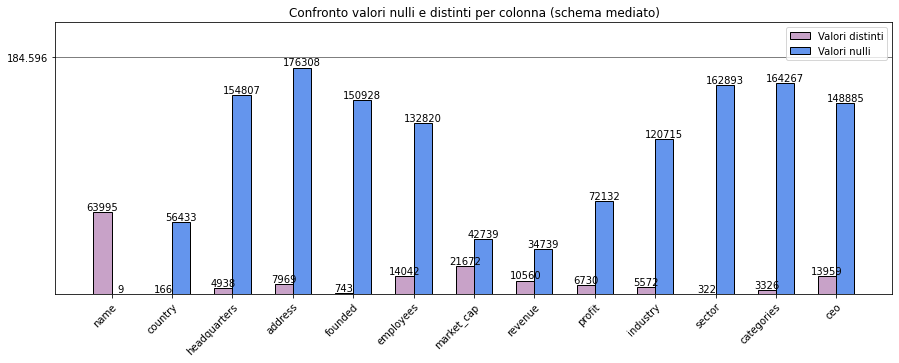

In [40]:
values1 = list(distinct_value1.values())
values2 = list(null_value1.values())

label1 = "Valori distinti"
label2 = "Valori nulli"

keys = list(null_value1.keys())

title = "Confronto valori nulli e distinti per colonna (schema mediato)"

v_max = df_info1.loc["#righe"][0]
two_bar_plot(keys, values1, values2, label1, label2, title, v_max)

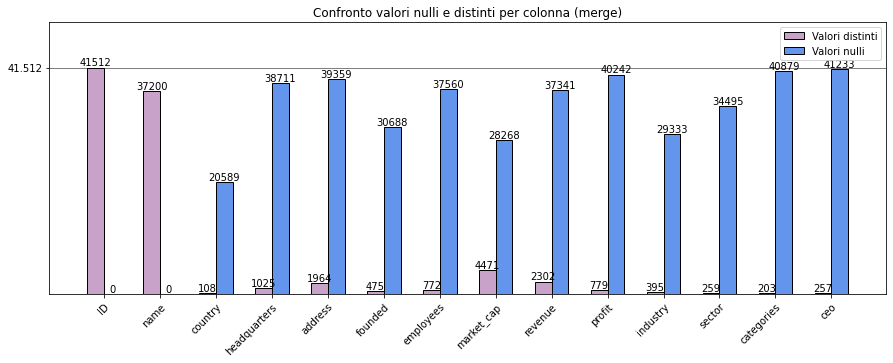

In [41]:
values1 = list(distinct_value2.values())
values2 = list(null_value2.values())

label1 = "Valori distinti"
label2 = "Valori nulli"

keys = list(null_value2.keys())

title = "Confronto valori nulli e distinti per colonna (merge)"

v_max = df_info2.loc["#righe"][0]
two_bar_plot(keys, values1, values2, label1, label2, title, v_max)

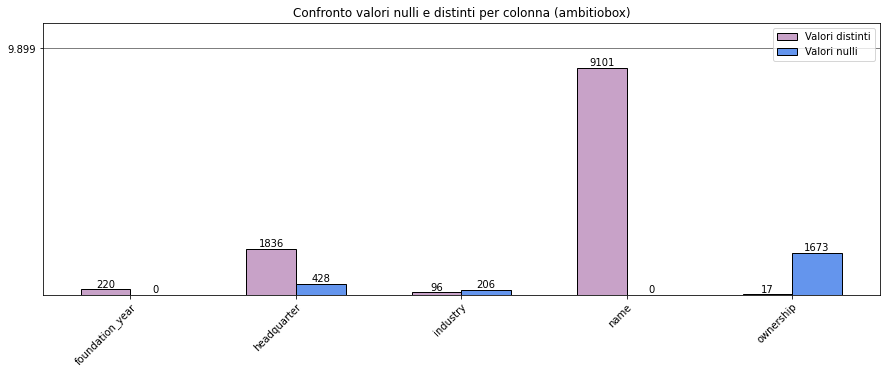

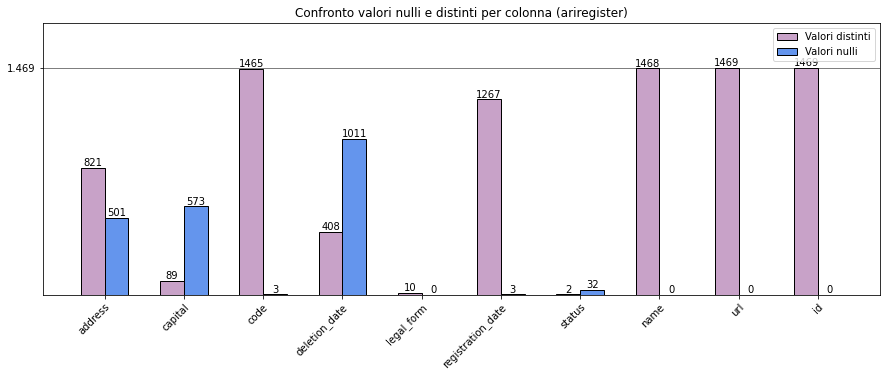

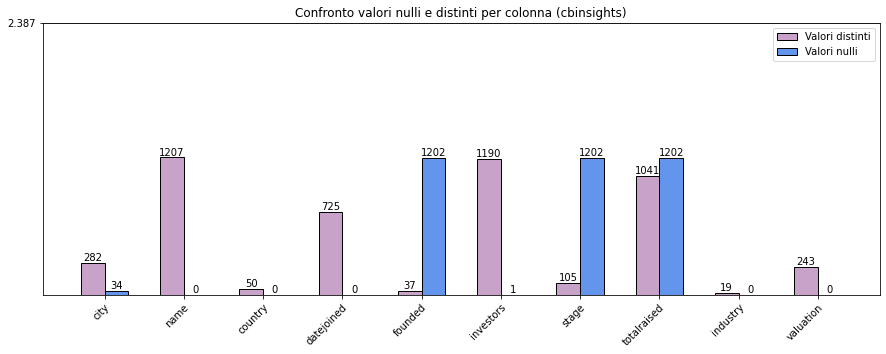

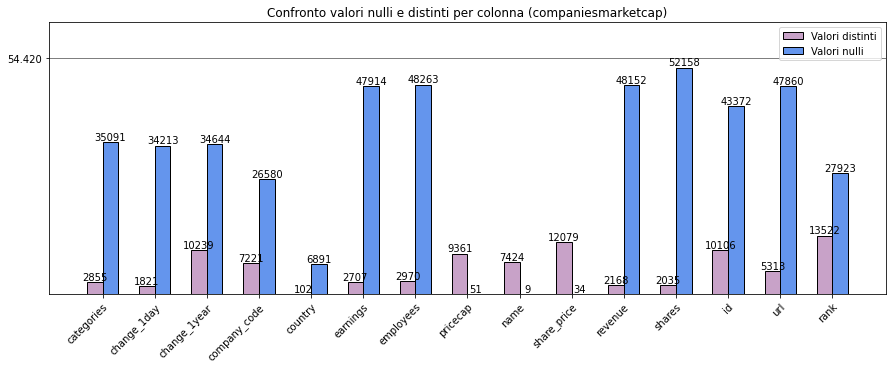

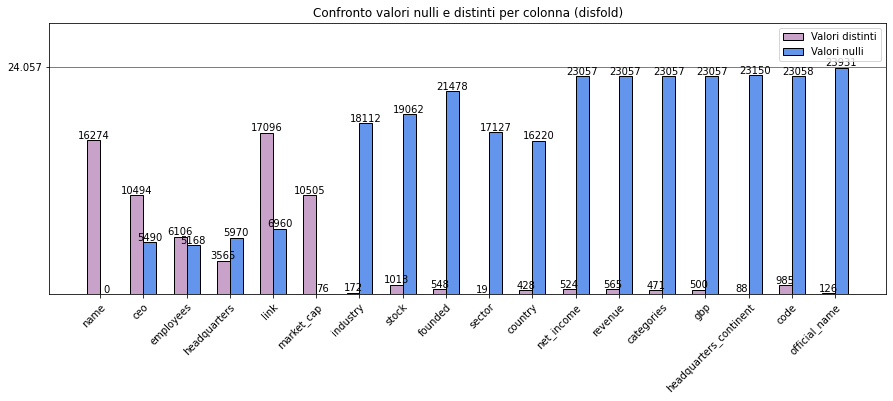

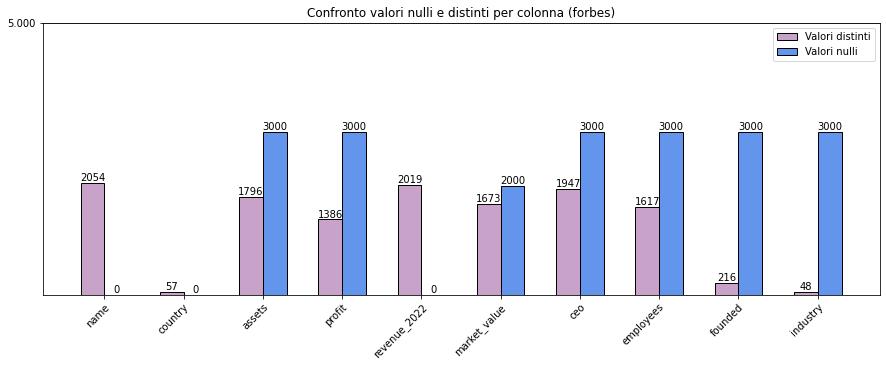

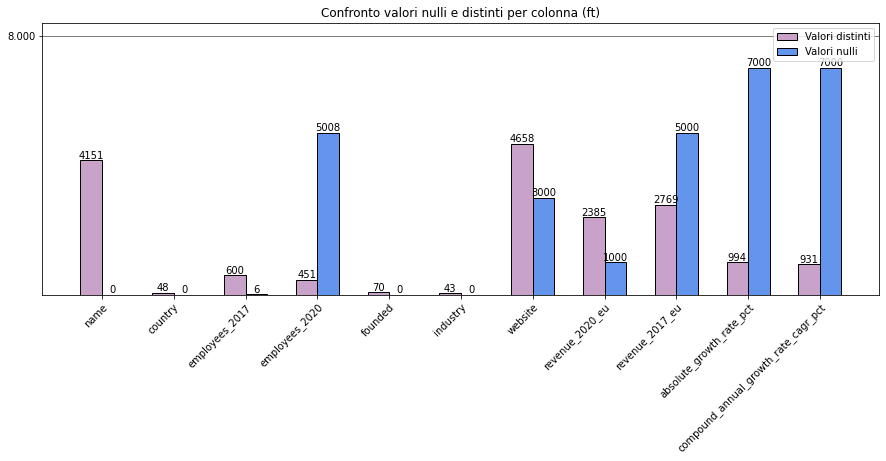

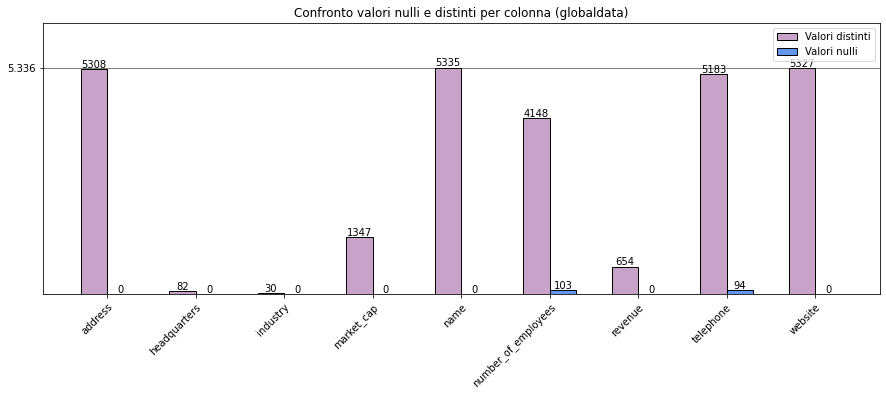

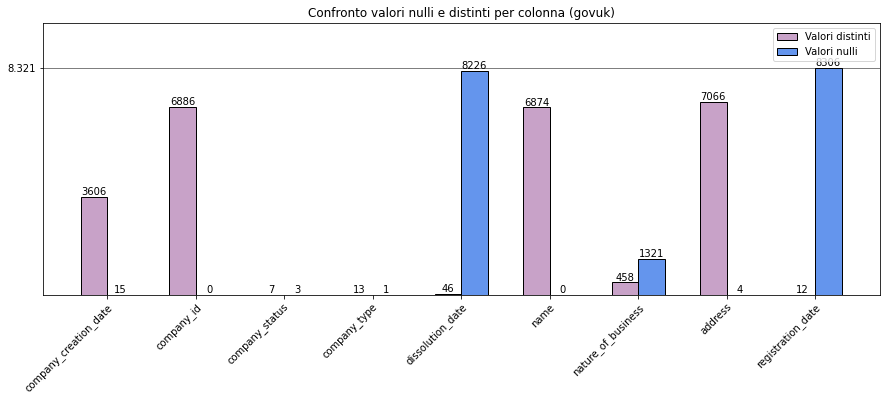

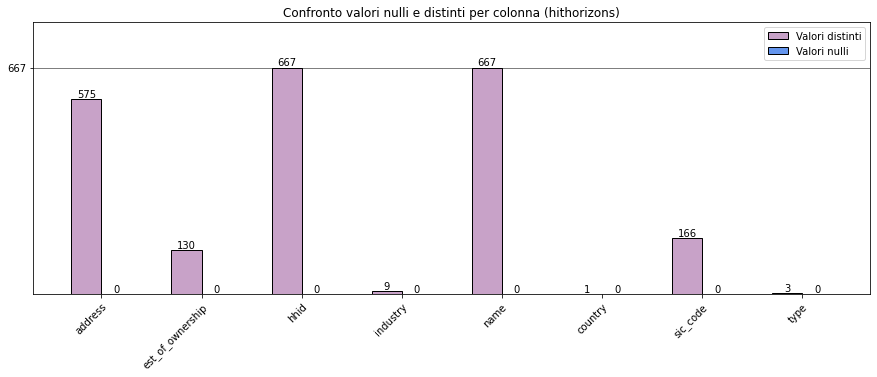

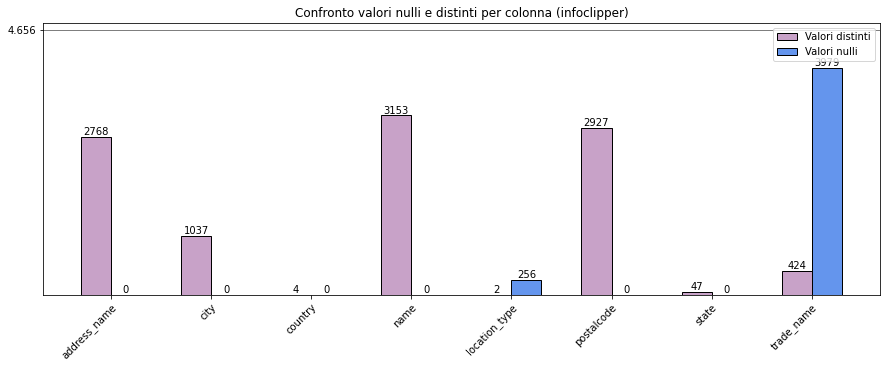

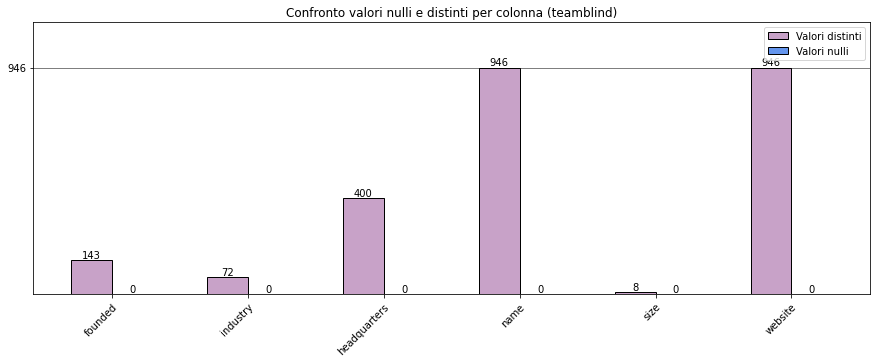

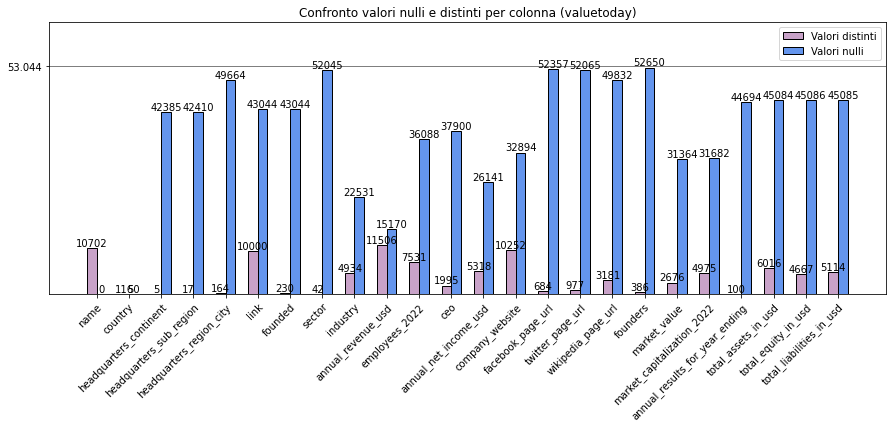

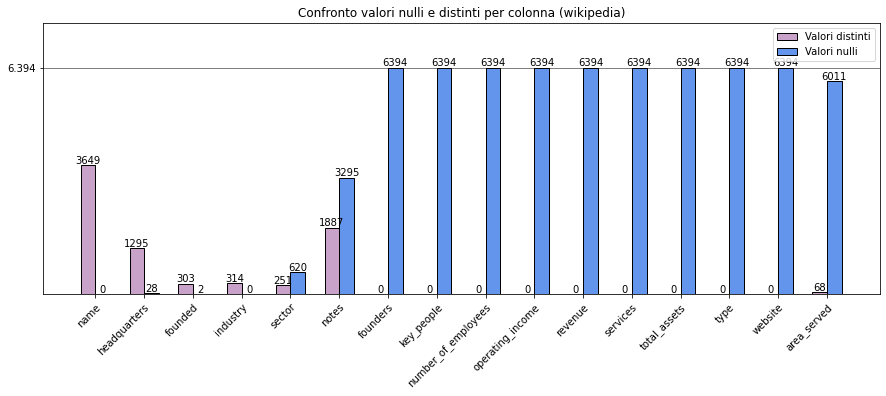

In [43]:
for filename in os.listdir("..\\..\\Dataset\\Schema\\"):
    file = os.path.join("..\\..\\Dataset\\Schema\\", filename)
    df = pd.read_csv(file, low_memory=False)
    info = extract_data_from_df(df)
    distinct_value = info.pop("#valori_distinti_per_colonna")
    null_value = info.pop("#valori_nulli_per_colonna")
    df_info = pd.DataFrame(info, index=["value"]).T
    
    values1 = list(distinct_value.values())
    values2 = list(null_value.values())

    label1 = "Valori distinti"
    label2 = "Valori nulli"

    keys = list(null_value.keys())

    title = "Confronto valori nulli e distinti per colonna (" + filename.split(".")[0] + ")"

    v_max = df_info.loc["#righe"][0]
    two_bar_plot(keys, values1, values2, label1, label2, title, v_max)

In [14]:
def most_frequent(l):
    if len(l) > 0:
        return max(set(l), key = l.count)
    return 0

In [15]:
def merge_list_of_dict(list_of_dict):
    keys = list(list_of_dict[0].keys())
    dict_of_merge = {k: [] for k in keys}
    for e in list_of_dict:
        for k, v in e.items():
            if v is not np.nan:
                dict_of_merge[k].append(v)
    return {k: most_frequent(v) for k, v in dict_of_merge.items()}

In [17]:
unique_name = set(list(df1["name"]))
res = []
i = 0
for name in unique_name:
    i += 1
    print(str(i)+"-"+str(name))
    df_tmp = df1.loc[df1['name'] == name]
    if len(df_tmp) > 2:
        dict_tmp = df_tmp.to_dict(orient="index")
        tmp = []
        for index, item in dict_tmp.items():
            tmp.append(item)
        res.append(merge_list_of_dict(tmp))

1-nan
2-grup montaner
3-serenita'
4-sunworks
5-v. & f. parker limited
6-kanani industries ltd
7-s a charlesworth renovations limited
8-green cross corporation
9-social capital hedosophia holdings corp. vi
10-ramkhamhaeng hospital public company ltd
11-japan real estate investment corp
12-roblox
13-ponsse
14-amarin printing and publishing public company ltd
15-spx flow inc
16-teranga gold corporation
17-link holdings ltd
18-xp power
19-phenofarm
20-private media group
21-codekunst systems
22-osaãâ¼hingaarspak(10166769)
23-petrofac limited
24-alujain holding corp
25-labevolution
26-oriental carbon & chemicals ltd
27-food and drink marketing limited
28-vontobel holding ag
29-mitsui chemicals inc
30-manor farm (solar power) ltd
31-agfa-gevaert nv
32-bmi group uk limited
33-z cars bury ltd
34-shoucheng holdings limited
35-bolt technology ou
36-deloitte mcs limited
37-global industrial company
38-iron road limited
39-onfolio holdings
40-peerless hospital
41-dye & durham limited
42-beauty bl

331-jpmorgan smaller companies investment trust plc
332-sandmani grupi as
333-aditya auto products & engineering
334-backbase
335-applovin corp
336-holman parts distribution careers
337-sonic interfreight public company ltd
338-mercer
339-eurasia groupe sa
340-software analysis and design limited
341-davide campari-milano
342-bad times ltd
343-squarespace, inc.
344-northern ireland transport holding company
345-tul corp
346-angells takeaways ltd
347-albaraka türk katilim bankasi a.s.
348-boss zhipin
349-global x management company llc
350-mighty kingdom
351-china energy development holdings ltd
352-red river resources limited
353-edeka
354-fermentalg
355-ichor holdings
356-cornerstone strategic value fund
357-dana inc
358-new albion energy ltd
359-nnit a-s
360-hengli petrochemical co ltd
361-p & a plant supplies limited
362-mitsui chemicals
363-pt bank harda internasional tbk
364-weg sa
365-shenzhen comix group co ltd
366-victory capital holdings
367-sundial growers inc.
368-sykes busi

648-workhuman
649-q 888 limited
650-kimball international
651-lg soft india
652-johnson service group plc
653-bank of ireland group
654-zendesk inc
655-s a garage services limited
656-bavaria film studios
657-good brand group ltd
658-af marcotec
659-computacenter plc
660-wipro enterprises ltd
661-radhakrishna foodland
662-alleghany
663-anhui honglu steel construction(group) co. ltd
664-ourpalm
665-ibu-tec advanced materials ag
666-a. ahmed & co (acctt) ltd
667-eesticavalierkingcharlesspanielitetãâ¢uãåhing(80186705)
668-h & b consulting limited
669-gep worldwide
670-trident royalties plc
671-aircall
672-mphasis ltd
673-hon corp ltd
674-ratnatris pharmaceuticals private limited
675-city & country bramshill lettings ltd
676-yamaha
677-automotives keim
678-valvoline cummins
679-h & a direct limited
680-discovery ltd
681-portman ridge finance corporation
682-pine cliff energy ltd.
683-fronteo, inc.
684-banka bioloo ltd
685-tata steel
686-innodata isogen
687-teamviewer careers
688-imco i

980-qatar national cement company (q.p.s.c.)
981-carvana
982-srr projects
983-armour residential reit
984-first capital real estate investment trust
985-akçansa çimento sanayi ve ticaret anonim sirketi
986-aersale
987-linnaaruãâ¤ri-jatãâ¶ãâ¶stusparkoãå(16363973)
988-preferred networks
989-first citizens bank careers
990-northland power
991-smith & nephew plc
992-vital metals limited
993-tohoku electric power co inc
994-general capital ltd
995-u i a trading ltd
996-amplitude analytics
997-caci international inc
998-beijing wandong medical technology
999-tokai rika
1000-m&sehituspartneroãå(14094677)
1001-verisk analytics, inc.
1002-3sbio, inc.
1003-ash-sharqiyah development co.
1004-enel generacion chile sa
1005-migdal insurance and financial holdings ltd
1006-idfc first bank limited
1007-dboi global services
1008-pik group
1009-datang international power generation
1010-nuovo banco ambrosiano
1011-bräutigam
1012-bio-rad laboratories
1013-northeast bank
1014-benesse holdings, inc.

1293-gilera
1294-p & a properties (sw) limited
1295-matica hrvatska
1296-international bancshares corporation
1297-ernest borel holdings ltd
1298-titan cement
1299-delhi police
1300-famous brands ltd
1301-refreshment product services, inc.
1302-nextera energy partners
1303-mohawk industries
1304-finance shared services ltd
1305-sanrio company
1306-good day coffee ltd
1307-laulasmaaspaapteekosaãâ¼hing(10989578)
1308-mercialys
1309-visera technologies company ltd
1310-go straight solutions ltd.
1311-japan prime realty investment corp
1312-all about hair ltd
1313-mangal industries
1314-spacevisionoãå(12109475)
1315-dongguan yutong optical technology
1316-exeter property group, llc
1317-mirae asset financial group
1318-grandvision nv
1319-sineng electric co.,ltd.
1320-huaneng power international inc
1321-pharmaron beijing
1322-penguin international ltd
1323-united microelectronics
1324-expeditors international of washington, inc.
1325-bad apple hair uk ltd
1326-servicetitan
1327-new air

1619-britannia
1620-souche holdings
1621-daifuku
1622-eatelcorp, l.l.c.
1623-aptinyx
1624-china transinfo technology
1625-ntt (nippon telegraph & telephone)
1626-totetsu kogyo co. ltd
1627-ldc sa
1628-state farm mutual automobile insurance co
1629-sdiptech ab 
1630-k&s corporation limited
1631-interglobe aviation
1632-glovo
1633-axio
1634-all about maintenance limited
1635-carillion alawi llc
1636-jiangsu hengshun vinegar-industry co.,ltd
1637-white & case llp
1638-t allen metal finishers limited
1639-zenbusiness
1640-goodbarber
1641-alpha real estate
1642-hyatt hotels corporation
1643-german high street properties a/s
1644-mrc logistics
1645-quanta storage, inc.
1646-field solutions holdings limited
1647-onto innovation
1648-k7 computing
1649-jsw
1650-dream unlimited corp.
1651-collective mining ltd
1652-beauty & nature ltd
1653-zevia
1654-blackstone group holdings l.l.c.
1655-accuray
1656-nepa ab
1657-daewoo shipbuilding & marine engineering co ltd
1658-salesforce inc
1659-renishaw p

1936-xpo logistics
1937-republic bank
1938-koninklijke dsm
1939-kuber enterprises
1940-midwich group plc
1941-industrial & commercial bank of china ltd
1942-trabitzsch dittrich architekten
1943-servizi in rete 2001 srl
1944-yatas yatak ve yorgan sanayi ve ticaret a.s.
1945-pensana plc
1946-z & a asset management limited
1947-vinco ventures
1948-bondada engineering
1949-asensus surgical
1950-cy4gate s.p.a.
1951-harmony gold mining co ltd
1952-cadmaxx solutions
1953-wekiwi srl
1954-united community bank
1955-waterco limited
1956-canada nickel co
1957-worldwide healthcare trust
1958-t a dickson ltd
1959-nuance communications inc
1960-food & wine events limited
1961-luxspaoãå(12764010)
1962-courtois sa
1963-bad transport limited
1964-federal reserve bank of boston careers
1965-sunopta inc.
1966-cr construction group holdings ltd
1967-akbank t.a.s.
1968-united aircraft corporation
1969-f45 training holdings inc.
1970-seagate technology plc
1971-b?m birle?ik ma?azalar
1972-pt petrosea tbk


2251-valuelabs
2252-traktech construccions mecàniques
2253-viom networks
2254-cts international logistics corporation
2255-japan petroleum exploration
2256-gea mechanical equipment us, inc.
2257-maxspanoãå(16412035)
2258-xiaomi  
2259-sky ict public company ltd
2260-sinopac financial holdings company
2261-provident financial holdings
2262-greencore group
2263-united industrial corporation
2264-disaronno ingredients spa
2265-bansal classes
2266-fis (company)
2267-banca popolare di milano
2268-rxo, inc.
2269-lilavati hospital & research centre
2270-century communities inc
2271-pt. indika energy tbk
2272-u & i accounting ltd
2273-lai group holding company ltd
2274-sacha engineering
2275-gildan activewear inc
2276-zhongnongfa seed industry group
2277-tus airways
2278-top resource conservation & environment
2279-merito desenvolvimento imobiliario i fii - fundo de investimento imobiliario
2280-software center black limited
2281-facilicon
2282-sembcorp marine
2283-montage gold corp
2284-uni

2576-clearside biomedical
2577-ark infosolutions
2578-software and code ltd
2579-third point investors limited
2580-good apple limited
2581-ratch group public company ltd
2582-abb group
2583-triglav group
2584-s a edwards ltd
2585-redwood pharma ab
2586-curaleaf holdings
2587-keli motor group
2588-bad wolf (ihs) ltd
2589-crombie real estate investment trust
2590-s p industries, inc.
2591-opentext technologies
2592-fusheng precision co. ltd
2593-north sea capital
2594-nordic id oyj
2595-shanghai daimay automotive interior co. ltd
2596-nitto denko corporation
2597-indutrade
2598-elbrewery
2599-oekoworld ag
2600-viohalco s.a.
2601-reventics
2602-jobvertising crossmedia
2603-edelweiss tokio life insurance
2604-zurich insurance group
2605-supercom ltd.
2606-lucisano media group s.p.a.
2607-mysoda
2608-bechtel careers
2609-türkiye sise ve cam fabrikalari a.s.
2610-dbg technologies pvt
2611-aagna global solutions
2612-president chain store (pscs)
2613-b3 s.a. - brasil, bolsa, balcao
2614-dili

2886-global menkul degerler anonim sirketi
2887-chr. hansen holding as
2888-mrc global inc
2889-yoodle careers
2890-new air southern limited
2891-cavatina holding spólka akcyjna
2892-merrill lynch international
2893-rascal industry
2894-nomura holdings
2895-iguatemi empresa de shopping centers sa
2896-united microelectronics corp
2897-digital wine ventures limited
2898-paphos general hospital
2899-4f (company)
2900-charter communications, inc.
2901-meril
2902-on semiconductor
2903-reclaims global ltd
2904-reply s.p.a.
2905-serverworks
2906-s p v i public company ltd
2907-unico
2908-beijing enterprises
2909-lot mobiles
2910-5d uk operations ltd
2911-q & c mechanical services limited
2912-suzlon energy
2913-nippon steel nisshin co. ltd
2914-finance systems limited
2915-bulgarian postbank
2916-vedanta resources
2917-sparkline equipments
2918-maslavi construction company ltd
2919-pjsc tatneft
2920-ultimate games
2921-all about aggregates ltd
2922-laser photonics
2923-spartan motors
2924-sc

3201-v & p motors limited
3202-takuma
3203-bright horizons family solutions inc.
3204-sgs sa
3205-africa oil
3206-property for industry ltd
3207-genkyotex sa
3208-intercure ltd
3209-sterling & wilson solar
3210-suzhou anjie technology
3211-q & s developments ltd
3212-rewalk robotics
3213-bester new energy italia srl
3214-asia capital group public company ltd
3215-aiandusãâ¼histuaespa-nurme(80064190)
3216-guarani
3217-the sunday times limited
3218-ariston holding n.v.
3219-cycloid
3220-tower bersama infrastructure
3221-icon outsourcing*
3222-imugene limited
3223-tongwei group co ltd
3224-redes energéticas nacionais (ren)
3225-marui group co. ltd
3226-jiangsu gian technology
3227-gcp student living plc
3228-arvee laboratories 
3229-midsummer ab
3230-pininfarina s.p.a.
3231-eml payments limited
3232-netgear
3233-burcon nutrascience corporation
3234-king island scheelite limited
3235-indigo
3236-aihuishou international co. ltd.
3237-nos s.g.p.s
3238-d-energy
3239-venture corp ltd
3240-nex

3518-tway air
3519-vetrya s.p.a.
3520-beauty and jewellery uk ltd
3521-egea commerciale
3522-softcreate holdings corp
3523-u digit ltd
3524-xpressbees
3525-safeway
3526-istituto comprensivo 'cavallermaggiore'
3527-distribuidora internacional de alimentacion sa
3528-rockwool
3529-h. a. lyken & sons
3530-netspi careers
3531-isdn holdings ltd
3532-lakã³gã©p kft.
3533-sandy spring bank
3534-italcer spa
3535-blackrock smaller companies trust
3536-pt tridomain performance materials tbk
3537-shanghai east-china computer
3538-nanosonics
3539-denso kirloskar industries
3540-bombardier transportation italy spa
3541-tikamoon
3542-22nd century group
3543-rodrigo tekstil sanayi ve ticaret a.s.
3544-tmbthanachart bank (ttb)
3545-combined motor holdings ltd
3546-mediaset s.p.a.
3547-bg finances ltd
3548-talkspanishoãå(14973887)
3549-floer
3550-konoike transport co. ltd
3551-u a modern communication ltd
3552-colt technology services
3553-brf
3554-dish network
3555-american states water
3556-chubu e

3838-finlibera
3839-matrix holdings ltd
3840-guangdong investment ltd
3841-software alliance services limited
3842-dimar spa
3843-computershare
3844-paragon banking group plc
3845-sinopec shanghai petrochemical company limited
3846-hitachi zosen corporation
3847-a alexander plumbing and heating limited
3848-food affairs limited
3849-namaste credit
3850-ito en
3851-cimb group
3852-kumiai chemical industry co. ltd
3853-xintec
3854-sistemas informáticos de negocio
3855-kose corp
3856-irkut corp
3857-asetek a/s
3858-kiatnakin bank public company
3859-vodafone
3860-withsecure srl
3861-trillium gold mines
3862-pantheon international plc
3863-itaãºsa
3864-alico
3865-revolutionrace
3866-usa compression partners lp
3867-indian institute of science education and research
3868-i-sheng electric wire & cable co. ltd
3869-cno financial group inc
3870-h & a building construction ltd
3871-science 37
3872-prism johnson limited - rmc (india) division
3873-spacelaboãå(12550800)
3874-u grow ltd
3875-gua

4148-mewah international inc
4149-sing fuel
4150-pt jasuindo tiga perkasa tbk
4151-bss microfinance
4152-allete
4153-stord
4154-h&r real estate investment trust
4155-grupo lo monaco
4156-nn group
4157-zf rane automotive
4158-han river technology
4159-dte energy co
4160-food creations ltd
4161-tennispaperoãå(11697487)
4162-ashtead
4163-rcl-priya cement
4164-sing lee software 
4165-cigna corp
4166-qu mei home furnishings group
4167-citrix
4168-shenzhen seg
4169-ntn corp
4170-rpmglobal holdings limited
4171-kyushu financial group
4172-thanachart capital public company
4173-genereach
4174-the hour glass limited
4175-wrap technologies
4176-escalade sports
4177-shanghai electric group company
4178-the i t service management forum international limited
4179-ofz, a.s., istebné
4180-technique control facility management
4181-sinolink securities
4182-solten business international
4183-jk lakshmi cement
4184-osaãâ¼hingspacetech(11458914)
4185-droneshield limited
4186-animalcare group plc
4187-

4467-new age it solutions limited
4468-mobvoi
4469-gol linhas aereas inteligentes
4470-china merchants port group
4471-great lakes dredge & dock corporation
4472-balfour beatty
4473-zhejiang dingli machinery co.,ltd
4474-elia system operator sa
4475-amazon (company)
4476-ameren careers
4477-mtr
4478-osotspa public company
4479-deepverge plc
4480-variosan
4481-weber
4482-u and health ltd
4483-university of michigan health system
4484-rewalk robotics ltd.
4485-dr b lal clinical laboratory
4486-greatek electronics, inc.
4487-match group inc
4488-overstock careers
4489-highly electrical appliances india
4490-5th planet games a/s
4491-takasago international corp
4492-t a lancaster contracting limited
4493-omnicom media group
4494-hil
4495-broadwind
4496-star petroleum refining public company
4497-v & p property services limited
4498-baroda global shared service
4499-asefa public company ltd
4500-mmx mineracao e metalicos sa
4501-integra lifesciences holdings corporation
4502-tamara t limite

4770-aditya birla nuvo
4771-agl energy
4772-kodak spa
4773-netenrich technologies
4774-ixellion as
4775-verizon communications inc.
4776-dbv technologies
4777-china lesso group
4778-atlas technical consultants
4779-petronas gas bhd
4780-westpac banking corp
4781-autogrill
4782-azimut yachts
4783-tokmanni group oyj
4784-biomã©rieux
4785-q & q interiors ltd
4786-magnetic resources nl
4787-design capital ltd
4788-cocreation grass co., ltd
4789-nampak ltd
4790-datong coal industry
4791-orient securities co ltd
4792-parsvnath developers
4793-guangzhou guangri stock
4794-oportun financial
4795-zs
4796-chico's fas inc
4797-blackrock
4798-air transport services group inc
4799-kwality pharmaceuticals
4800-rocket pharmaceuticals
4801-uniqlo
4802-stem learning
4803-sime darby property
4804-indo gulf fertilisers
4805-r a design limited
4806-lidl italia srl
4807-sumou real estate company
4808-beauty and bravado ltd
4809-ihlas gazetecilik a.s.
4810-psl ltd
4811-sampo corp
4812-oasis
4813-belgian bee

5091-king yuan electronics co. ltd
5092-mercantile investment trust (the)
5093-ksb limited - irrigation & process division (ipd)
5094-r a brown consultancy limited
5095-ems-chemie holding ag
5096-ican bpo
5097-quintoandar
5098-tiaa global business services
5099-dsv as
5100-public joint stock company tambov power supply company
5101-mayfair hotels & resorts
5102-appsfactory
5103-jagran prakashan
5104-bergs timber ab
5105-nfa engineering service
5106-s a digital marketing ltd
5107-pt aneka tambang persero tbk
5108-el corte inglés
5109-scsk corp
5110-acne studios
5111-merian chrysalis investment co., ltd.
5112-erie indemnity
5113-udr apartments
5114-labrador gold corp
5115-orsted a/s
5116-all about people (mediation and hr) ltd
5117-first bancorp
5118-software connextions ltd
5119-sparklestudiooãå(12568415)
5120-pnm resources
5121-henderson diversified income trust plc
5122-tigi ltd
5123-ipek dogal enerji kaynaklari arastirma ve üretim a.s.
5124-all about appliances ltd
5125-pt soho glo

5400-hong leong asia ltd
5401-emerald resources nl
5402-longshine technology
5403-scholastic careers
5404-xi'an shaangu power co. ltd
5405-arthur j. gallagher
5406-datadog
5407-sigal & sapiro real estate
5408-public joint-stock company vyborg shipyard
5409-software radio technology limited
5410-jacobs solutions inc
5411-xoxoday
5412-philip morris international inc.
5413-familymart
5414-wallenius lines
5415-food & beverage (rrl) limited
5416-weyerhaeuser co
5417-sallie mae
5418-indexia group
5419-curefit
5420-applegreen
5421-american express co
5422-orca security
5423-all about home care limited
5424-you mawo
5425-steel authority of india
5426-good & good investments limited
5427-iamgold corporation
5428-all ring tech co. ltd
5429-asiamedic ltd
5430-ing group nv
5431-tvn group
5432-federated hermes
5433-radius residential care ltd
5434-engagesmart, inc.
5435-korn ferry careers
5436-futaba industrial gujarat
5437-pt alfa energi investama tbk
5438-finances by naomi limited
5439-parcel com

5740-ums holdings ltd
5741-lasertec
5742-bahema educacao sa
5743-nippon steel corp
5744-moonscoop group
5745-fawer automotive parts company
5746-malamatina
5747-zto express (cayman) inc.
5748-yukon sky
5749-weihai guangtai airport equipment
5750-aptos
5751-eris lifesciences
5752-equipmentshare
5753-havells india ltd
5754-toho holdings co ltd
5755-hikari tsushin inc
5756-nkt a/s
5757-kbr, inc.
5758-v & a building limited
5759-skillmatics
5760-sri mookambika infosolutions
5761-huang hsiang construction corp
5762-s a e associates limited
5763-goldstone cements
5764-eurocash s.a.
5765-stella-jones inc.
5766-quidelortho corporation
5767-yara limited
5768-yuexiu real estate investment trust
5769-certification europe italia srl
5770-laboratoires dermosun
5771-beijing kunlun tech
5772-karbicastudiospaoãå(12606529)
5773-hanwha life insurance co ltd
5774-kami
5775-yantai zhenghai biotechnology
5776-hubei juneyao health drinks co., ltd
5777-meritor
5778-pacray international holdings ltd
5779-fl

6064-livzon pharmaceutical group co ltd
6065-commscope holding company
6066-kingston financial group
6067-red badger consulting
6068-q build pvt ltd
6069-xingyun group
6070-passat
6071-bml inc
6072-china national software & service company
6073-t a consultancy limited
6074-himax
6075-q elite ltd
6076-z a pizza limited
6077-karularahvuspargiadministratsioon(70001892)
6078-software services (uk) limited
6079-datapro
6080-new wave holdings ltd
6081-alsea
6082-innogenetics
6083-tritax big box reit
6084-isadora
6085-the players t s limited
6086-q ball snooker & sports bar limited
6087-mittetulundusãâ¼hingvãâ¤hifond"spasjenije"(80576300)
6088-orion engineered carbons
6089-shyam ferro alloys
6090-galecto, inc.
6091-takuma co ltd
6092-sonos careers
6093-cerevel therapeutics
6094-g & m holdings ltd
6095-bangchak corp public company ltd
6096-kingstate
6097-arabian fal holding
6098-bunka shutter co ltd
6099-baoji titanium industry
6100-papilly ab
6101-sol cuisine ltd
6102-alps alpine co ltd
610

6382-alenia aermacchi
6383-sirenum
6384-united community banks, inc.
6385-leverage edu
6386-autodis italia srl
6387-himalaya
6388-santé formapro
6389-t and a boyle llp
6390-manfrotto
6391-ibstock plc
6392-grupo aeroportuario del pacifico
6393-ador welding
6394-ever harvest group holdings ltd
6395-grifal s.p.a.
6396-société marseillaise du tunnel prado carénage
6397-tecnicas reunidas sa
6398-jinhui liquor co.,ltd.
6399-martin tool works inc
6400-aberdeen asian income fund limited
6401-eurocash sa
6402-cashpor micro credit
6403-r a k v supreme limited
6404-r a j convenience store ltd
6405-taboola.com ltd.
6406-ebroker group ltd
6407-p & a grounds maintenance limited
6408-met film limited
6409-boehringer ingelheim
6410-shankar electricals
6411-dexco sa
6412-a a catering equipment services limited
6413-fico
6414-neocom multimedia
6415-tirupati group
6416-tdk corp
6417-materialise nv
6418-gesco ag
6419-humm group limited
6420-acheter-louer.fr
6421-shinva medical instrument co ltd
6422-owkin

6703-tee international ltd
6704-yanbu national petrochemical company
6705-edge network services limited
6706-gaussian robotics
6707-arcbest corporation
6708-pt mas murni indonesia, tbk
6709-mycamper
6710-daifuku co ltd
6711-raydium semiconductor corp
6712-p a gardens and landscaping ltd
6713-a. a. chemical cleaning company limited
6714-software business ltd
6715-ug healthcare corp ltd
6716-vascon engineers
6717-true north commercial real estate investment trust
6718-pt ekadharma international tbk
6719-real
6720-good cost apartments ltd
6721-global unichip
6722-coca-cola hbc eesti as
6723-food chain kitchen limited
6724-gryphon audio designs
6725-dic india
6726-tcg lifesciences
6727-glencore plc
6728-quisitive technology solutions, inc.
6729-viatris inc.
6730-solaria energia y medio ambiente
6731-gambling.com group ltd
6732-shanxi luan environmental energy development co ltd
6733-fintech group ag
6734-shanghai weaver network
6735-pt j resources asia pasifik tbk
6736-ningbo haitian preci

7027-caesars entertainment corporation
7028-greenbrier companies
7029-gruppo arena spa
7030-pt lion metal works tbk
7031-z & h consulting limited
7032-all about the face ltd
7033-creades ab
7034-samsung fire & marine
7035-camp k-12
7036-jaya hind montupet (p) ltd. pune
7037-mitsuuroko group holdings co.,ltd.
7038-villa kunalai public company ltd
7039-bad seed vintage ltd
7040-airboss of america
7041-orica
7042-worthington industries inc
7043-eastborder promotion
7044-tmtl
7045-saputo inc
7046-beauty at the bay ltd
7047-christian dior se
7048-r agency limited
7049-kayne anderson mlp/midstream investment company
7050-serco
7051-picc
7052-enercotec servicios
7053-bad harvest ltd
7054-lybrate
7055-a a hutton llp
7056-certik
7057-national gas & industerialization
7058-cargolux
7059-new alisha (wolverhampton) supermarket ltd
7060-ngk insulators
7061-seb sa
7062-l&t heavy civil infrastructure
7063-ion acquisition corp 1 ltd.
7064-abrdn plc
7065-construtora tenda sa
7066-the botanical club
706

7343-dtw 1991 underwriting limited
7344-spedition ibov
7345-the timken co
7346-star comgistic capital co. ltd
7347-bennet
7348-beijing vrv software corporation
7349-mazzoni etech
7350-esosphera
7351-frontera energy corporation
7352-food dream international limited
7353-al ahleia switchgear
7354-longino & cardenal s.p.a.
7355-hanwa
7356-new alley limited
7357-carrozzeria scaglietti
7358-la saponaria
7359-workinprogress italia
7360-zhejiang tiantie industry
7361-v & m (victoria) ltd
7362-glen appliances
7363-sociedad química y minera de chile sa
7364-black peony (group)
7365-ubi banca
7366-manufacturaspaceoãå(16349874)
7367-park hotels & resorts
7368-th1ng ab 
7369-posco-thainox public company ltd
7370-zhejiang wansheng
7371-randstad nv
7372-portugal telecom
7373-qarmatek services
7374-beijing sanju environmental protection & new materials co. ltd
7375-spark infrastructure group
7376-banco de chile
7377-elixir energy limited
7378-new age builds limited
7379-amway international inc.
738

7663-team consulting engineering and management public company ltd
7664-mobilityone limited
7665-food bench ltd
7666-conneqt business solutions
7667-great lengths spa societa' benefit
7668-r a adair surgical services ltd
7669-sistema public joint stock financial corporation
7670-highlight tech corp
7671-tencent
7672-berkshire hills bancorp
7673-beijing dahao technologyltd
7674-golden tulip hotels
7675-dfi, inc.
7676-jumia technologies ag
7677-zhejiang huace film & tv
7678-care it solutions
7679-haci ömer sabanci holding a.s.
7680-hansa biopharma ab
7681-livedigital marketing solutions
7682-acer e-enabling service business, inc.
7683-invitation homes inc
7684-service stream ltd
7685-thai polycons public company ltd
7686-p allen decorating ltd
7687-bh macro limited
7688-sichuan road & bridge
7689-bgt corp public company ltd
7690-a. allsopp marketing ltd
7691-first gulf bank
7692-ozderici gayrimenkul yatirim ortakligi a.s.
7693-finanziaria d'investimento fininvest spa
7694-société hôteliè

7965-golden entertainment
7966-software imaging group limited
7967-sichuan kelun pharmaceutical
7968-kehaspaoãå(12886144)
7969-celldex therapeutics
7970-tangrenshen group co. ltd
7971-y tree limited
7972-taidoc technology corp
7973-avicopter
7974-pt bayan resources tbk
7975-draper esprit
7976-orco
7977-occidental petroleum corp
7978-blohm+voss
7979-topbuild corp.
7980-skills rh
7981-piramal realty
7982-scotiabank chile, sa
7983-wai chi holdings company ltd
7984-citizen watch
7985-forrester research
7986-teemage precast in
7987-conagra brands inc
7988-integral university
7989-worldline global services
7990-we doctor
7991-rumble resources limited
7992-pathways world school
7993-mmc infotech services
7994-das offshore engineering
7995-fn factory outlet public company ltd
7996-cp group
7997-post danmark
7998-pyrum innovations ag
7999-halliburton co
8000-r a electrical services limited
8001-creative garments
8002-civica india
8003-pg&e corporation
8004-sasmos het technologies
8005-hufvuds

8284-city of london investment trust
8285-birra ichnusa
8286-maksat technologies
8287-viktormaspanov(12105827)
8288-china daye non-ferrous metals mining ltd
8289-all about assets limited
8290-l’exception
8291-ehituspartneroãå(12198480)
8292-accuster technologies
8293-flywire corp
8294-ironbark capital limited
8295-amc networks international central europe
8296-pinnacle bank
8297-sesa s.p.a.
8298-emperor watch & jewellery ltd
8299-a-check global
8300-good business solutions ltd
8301-annikaraimconsultancyoãå(14064647)
8302-american electric power careers
8303-transpanticaretoãå(10839465)
8304-klarna
8305-l&t smart world & communication
8306-aspire systems
8307-beijing capital development
8308-new age solar systems ltd
8309-dutch bros
8310-the web plant
8311-worthington industries
8312-papa
8313-mg export
8314-dustin group ab
8315-puma se
8316-maire tecnimont spa
8317-inaba denki sangyo co ltd
8318-camlachie cooperage limited
8319-kei industries
8320-hai kwang enterprise corp
8321-b

8594-multi mantech international
8595-bjarke ingels group
8596-pal holdings inc
8597-breach candy hospital trust
8598-glintt
8599-theradiag sa
8600-l1 long short fund limited
8601-henkel ag
8602-guangdong guanghua sci-tech
8603-signor prestito
8604-balticspaoãå(12238735)
8605-iit kanpur
8606-good autos limited
8607-s a a installations ltd
8608-ricoh uk limited
8609-jpmorgan china growth & income plc
8610-vistry group
8611-opko health inc
8612-impax environmental markets
8613-crédit agricole sa
8614-a a hair ltd
8615-exidea
8616-hefei urban construction development co. ltd
8617-perfetti van melle
8618-hannes kã¶nig
8619-edition ltd
8620-life insurance corporation of india (lic)
8621-petrofac international ltd
8622-croatia airlines
8623-shandong gold mining co. ltd
8624-maverit careers
8625-tristan capital partners llp
8626-ridley bikes
8627-lidl great britain limited
8628-equensworldline se
8629-maxinfra
8630-ces
8631-proceram
8632-custom computer specialists careers
8633-dali foods g

8913-formosa petrochemical corporation
8914-hongkong and shanghai hotels
8915-legimi
8916-stitch fix inc
8917-argo group us, inc.
8918-pt m cash integrasi tbk
8919-first sponsor group
8920-latvian mobile telephone
8921-shanghai zijiang enterprise group co ltd
8922-medplus(optival health solutions)
8923-the merchants group limited
8924-avingtrans plc
8925-bigtree entertainment
8926-onemain holdings, inc.
8927-cettire limited
8928-kohl's
8929-ave line
8930-eurostar international limited
8931-j. b. chemicals & pharmaceuticals
8932-balmer lawrie
8933-a a & s j faulkner limited
8934-hilton international hotels (uk) limited
8935-thermoairrakennuspalvelutoãå(12593815)
8936-felda global ventures holdings berhad
8937-solvay s.a.
8938-guangdong great river smarter logistics
8939-entera bio ltd.
8940-rb uk commercial limited
8941-inepar s.a. industria e construcoes
8942-mas financial services
8943-warehouses de pauw
8944-nexthink
8945-tyler technologies
8946-bad apple hair stratford limited
894

9223-par formulations
9224-harvatek corp
9225-woojin, inc.
9226-software cloud limited
9227-america movil
9228-hokkyokusei corporation
9229-zovio
9230-rvl pharmaceuticals
9231-metalmeccanica tiberina srl
9232-gs engineering & construction corp
9233-hutchison port holdings trust
9234-volvo penta
9235-kioleides
9236-green team
9237-rosen hotels and resorts, inc.
9238-valtra
9239-shenwan hongyuan (h.k.) ltd
9240-rogers communications
9241-beauty barks ltd
9242-grab a grub services
9243-grasim industries ltd
9244-kakel max ab
9245-sipl
9246-moneymax financial services ltd
9247-pettenati s.a. industria textil
9248-videocon telecommunications
9249-enerjisa enerji
9250-ascent hr
9251-renaissance hotels
9252-hilton grand vacations
9253-yield go holdings ltd
9254-orsero s.p.a.
9255-lithium australia nl
9256-acegasapsamga spa
9257-global stones
9258-all about logistics ltd
9259-new abode limited
9260-medinaliberhispanicaoãå(14821433)
9261-castor & pollux
9262-p a m developments limited
9263-sa

9538-lions gate entertainment inc.
9539-linklaters business services
9540-wns
9541-unione di banche italiane
9542-mtar technologies
9543-yealink network technology
9544-adler real estate
9545-synthetic genomics careers
9546-daiichi sankyō
9547-fertilisers and chemicals travancore
9548-advantage oil & gas ltd.
9549-bt ireland
9550-arch resources inc
9551-the siam cement public co ltd
9552-food & body peace ltd
9553-polarstern
9554-nonthavej hospital public company ltd
9555-united natural foods inc
9556-block, inc.
9557-glass express
9558-radcom
9559-crmnext
9560-asahi intecc
9561-core & main, inc.
9562-vydehi institute of medical sciences and research centre
9563-kx concept
9564-tianjin faw
9565-arzooo.com
9566-eagers automotive ltd
9567-ab costruzioni
9568-bad bear transport ltd
9569-ivl dhunseri petrochem industries
9570-mfine
9571-aptorum group
9572-mercadolibre, inc.
9573-new concepts holdings ltd
9574-exeo group inc
9575-calbee, inc.
9576-sopra banking software
9577-beauty barn tra

9859-central plaza hotel public company
9860-orrefors glassworks
9861-shop cj network
9862-ceco environmental
9863-st. joseph's school
9864-good cod london ltd
9865-spring airlines
9866-orange business services
9867-altech chemicals limited
9868-george weston
9869-versa design zycle
9870-matsalurahvuspargiadministratsioon(70003141)
9871-summit financial group
9872-global innovations germany
9873-mittetulundusãâ¼hingsebheategevusfond(80231417)
9874-parkland corporation
9875-bluefocus communication group co ltd
9876-agentsync
9877-ping an insurance
9878-pangaea logistics solutions
9879-ethosenergy italia spa
9880-national commercial bank
9881-klay schools
9882-osaãâ¼hingrukkilillespar(10683514)
9883-enhabit
9884-esense-lab ltd
9885-costa group holdings limited
9886-k a j finances ltd
9887-sdf holding spa
9888-china lng group ltd
9889-housing.com
9890-house to house
9891-acanthe conseil
9892-hyundai development co
9893-merck sharp & dohme llc
9894-bluescope steel ltd
9895-blumar sa
9896

10175-s a group services ltd
10176-lesparkoãå(16269497)
10177-kvh industries
10178-amoda group of industries
10179-bristow group
10180-eje 
10181-dmg blockchain solutions, inc.
10182-da.dif. consulting
10183-ryman hospitality properties, inc.
10184-kopran
10185-dell technologies inc.
10186-asiana idt, inc.
10187-nation international edutainment public company ltd
10188-anheuser-busch inbev sa/nv
10189-burlington stores, inc.
10190-hyakugo bank
10191-jiangsu hongdou industrial co. ltd
10192-onxeo sa
10193-immo-team allgäu
10194-arco vara as
10195-oasis petroleum
10196-zhejiang runtu
10197-shenzhen kaifa technology
10198-all about training limited
10199-red bull technology limited
10200-arrow enterprise computing solutions limited
10201-xinjiang yilite industry co.,ltd
10202-v aero training ltd
10203-makino milling machine co. ltd
10204-super league gaming
10205-california bancorp
10206-catella ab
10207-innocan pharma corp
10208-grupa kety sa
10209-v a enterprises limited
10210-doma
10

10485-bussan auto finance
10486-dnb asa
10487-itochu corporation
10488-terranet ab
10489-coreo ag
10490-mother goose
10491-exabeam
10492-p a cook & co (high wycombe) ltd
10493-wp midco1 limited
10494-azbil corp
10495-alma media oyj
10496-cisco systems inc
10497-a allen electrical ltd
10498-havertys
10499-sonoscape medical
10500-fiordelmondo lubrificanti
10501-relativity space
10502-surin automotive
10503-beretta
10504-highspot
10505-jefferies financial 
10506-talktalk telecom group
10507-silkroad nickel ltd
10508-pluristem therapeutics inc.
10509-pt mitra pinasthika mustika tbk
10510-rekor systems
10511-biz gateways ltd
10512-oãådreamspace(12741115)
10513-kolmar korea co ltd
10514-cummins inc.
10515-jet time
10516-akumentis healthcare
10517-haseko corp
10518-alignment healthcare, inc.
10519-beauty bay limited
10520-vanke overseas investment holding company ltd
10521-brembo s.p.a.
10522-@health saca
10523-new alisha (tipton) supermarket ltd
10524-china oil and gas group ltd
10525-rish

10791-elemy
10792-ezcater
10793-innovaccer
10794-kingfa sci. & tech. co. ltd
10795-new age coach ltd
10796-q a s international limited
10797-mullen group ltd.
10798-electrosteel casting
10799-universal music investments, inc.
10800-japan pulp and paper co ltd
10801-amrita vishwa vidyapeetham
10802-bwx technologies inc
10803-sotetsu holdings, inc.
10804-valartis group ag
10805-intesa sanpaolo spa
10806-inspur electronic information industry
10807-grimaldi industri
10808-samsung display
10809-mark+technik verlag
10810-infinities tech (jiu zun digital)
10811-eisler capital (ts) ltd
10812-xalta food and beverages
10813-qinetiq group
10814-morguard
10815-humana inc.
10816-swedish match ab 
10817-dagi yatirim holding a.s.
10818-invesco income growth trust plc
10819-deinove sa
10820-umedia
10821-shenzhen megmeet electrical co. ltd
10822-downing one vct plc
10823-avangrid
10824-olin
10825-irani papel e embalagem sa
10826-midea real estate holding ltd
10827-bolt technology
10828-aak ab (publ.)


11097-yes!devs
11098-tf1 group
11099-toho bank
11100-new addington peoples' carnival
11101-towers watson italia srl
11102-steps
11103-compucase enterprise co. ltd
11104-sichuan languang justbon services group
11105-first horizon national
11106-the guardians real estate advisory
11107-software engineering and entrepreneurship development group ltd
11108-prinetti & stucchi
11109-sparvoãå(12455792)
11110-dee piping system
11111-electrica
11112-active energy solutions
11113-audience serv
11114-apptech payments
11115-focus edumatics
11116-umicore sa
11117-aaa life insurance co
11118-seibu holdings, inc.
11119-dhipaya insurance public company ltd
11120-birla sun life mutual fund
11121-zylox-tonbridge medical technology co., ltd.
11122-sinjia land ltd
11123-swades foundation
11124-macquarie group ltd
11125-ultrapar participacoes sa
11126-zhejiang medicine
11127-swedbank ab (publ)
11128-serica energy plc
11129-sakata seed corporation
11130-willdan group
11131-mann + hummel vokes-air limited


11411-liaoning wellhope agri-tech joint stock
11412-estonianchairoãå(12323895)
11413-grace fabric technology
11414-t & a services (hull) limited
11415-türkiye petrol rafinerileri a.s.
11416-u belper limited
11417-dhl it services
11418-dun & bradstreet
11419-china merchants bank co ltd
11420-payfare, inc.
11421-pepkor
11422-posiflex technology, inc.
11423-sire group holding
11424-all about the core limited
11425-mindchamps preschool ltd
11426-equinox gold corp
11427-dp eurasia n.v.
11428-biocon ltd
11429-richinfo technology
11430-groupimo
11431-software development services ltd
11432-helpage india
11433-j. smart & co. (contractors) plc
11434-bio energy solutions
11435-era finances real estate investments ltd
11436-fashion box spa
11437-s a elite group limited
11438-rimowa
11439-latam airlines group sa
11440-zurich airport
11441-calsoft
11442-tainan spinning co. ltd
11443-mailgun technologies careers
11444-addtech ab
11445-sumco corp
11446-z and f motors ltd
11447-ecloudvalley
11448-xa

11719-caplin point laboratories
11720-bruno magli
11721-sang hing holdings 
11722-b-gaming sa
11723-new albion wind limited
11724-lion asiapac ltd
11725-maspex
11726-cssc offshore & marine engineering (group) company ltd
11727-kadimastem ltd
11728-softcat plc
11729-pole to win
11730-sweef furniture
11731-le petit vapoteur
11732-leo pharma
11733-ferrovial construcción s.a.
11734-aht cooling systems
11735-phoenix esd
11736-bravado international group limited
11737-huhtamaki india
11738-indofood agri resources ltd
11739-gkn
11740-osg corporation
11741-insurance australia group ltd
11742-alpha and omega semiconductor
11743-s a h transport limited
11744-washington h. soul pattinson and company limited
11745-longwell company
11746-r a grigg electrical services ltd
11747-neurocuticals
11748-arcbest corp
11749-brooge energy
11750-uol group
11751-mdc holdings
11752-abaco systems, inc. careers
11753-idemia
11754-dba group s.p.a.
11755-pt arkadia digital media tbk
11756-rungta mines
11757-extende

12025-rostovoblgaz pjsc
12026-dvs technology ag
12027-morneau shepell inc.
12028-as one corporation
12029-north media as
12030-planet fitness, inc.
12031-deloitte
12032-terago inc.
12033-contact energy limited
12034-sokolovaspaceoãå(16212342)
12035-enel distribucion chile sa
12036-rank group
12037-comviva technology
12038-ideas2it technologies
12039-first national of nebraska
12040-sb supply
12041-tipco asphalt public company ltd
12042-sumitomo dainippon pharma co. ltd
12043-hager electro
12044-windstream holdings inc
12045-gequity s.p.a.
12046-axogen
12047-good brothers trading co. ltd
12048-shikoku electric power co inc
12049-mälarenergi
12050-apex hospital
12051-pwc acceleration centers
12052-tf1
12053-trabzon liman isletmeciligi anonim sirketi
12054-ctx life science
12055-filva
12056-suttons tankers limited
12057-the realreal
12058-discovery limited
12059-havi logistics srl
12060-wells fargo india
12061-overstock.com
12062-p a dental lab services ltd
12063-greenland minerals limi

12338-vanjia corp
12339-e pack polymers
12340-beijing urban construction investment & development co. ltd
12341-arteris
12342-good companions limited
12343-relx (holdings) limited
12344-general shopping e outlets do brasil sa
12345-v & m guildford ltd
12346-rapidapi
12347-wuxi taiji industry company ltd
12348-rusalkaspa&beautyoãå(16292571)
12349-hengkang medical group
12350-idt corporation
12351-kintetsu world express inc
12352-a-mark precious metals
12353-national railway company of belgium
12354-lerado financial group company ltd
12355-münsterland plus
12356-shree technocrat communication systems
12357-fositek corp
12358-trammo, inc.
12359-beijing tianyishangjia new material
12360-tgc-1 pjsc
12361-canon inc
12362-westlake chemical partners
12363-makkah construction & development
12364-sia engineering company
12365-tibet rhodiola pharmaceutical holding
12366-mohani tea leaves
12367-sabyasachi couture
12368-enalyzer a/s
12369-fox solutions
12370-anz bank
12371-embibe
12372-a a delive

12646-varite
12647-xiamen international trade group
12648-atl careers
12649-ineos acetyls uk limited
12650-transtema group ab
12651-bavarian nordic
12652-lörcher bauunternehmen
12653-software box limited
12654-bauer ag
12655-nakedspacestudiosoãå(14325898)
12656-r a lands limited
12657-mashgin
12658-patrick industries
12659-food dreams ltd
12660-zinkia entertainment
12661-qonto
12662-mangalam cement
12663-mol hungarian oil
12664-netwealth group limited
12665-t aestheticã¢â¬â¢s ltd
12666-alphaville sa
12667-indofood cbp
12668-kion group
12669-pksha technology, inc.
12670-first mid-illinois bancshares
12671-lennar
12672-advanced energy industries, inc.
12673-bicecorp sa
12674-ss construction
12675-shikun & binui
12676-alligator energy
12677-smartone telecommunications holdings ltd
12678-ambuja cements ltd
12679-rába
12680-kamigumi co ltd
12681-estonia capital ou
12682-oriental bank of commerce
12683-visang education, inc.
12684-stumbras
12685-hero corporate services
12686-money owl lt

12952-kore
12953-all about patisserie ltd
12954-food and fitness from chris ltd
12955-sappi
12956-hainan huluwa pharmaceutical group co., ltd.
12957-eurizon capital sgr spa
12958-creativespacestudio(80602457)
12959-spatimeoãå(14420600)
12960-admiral group
12961-sci pharmtech, inc.
12962-chongqing water group
12963-beauty and the bride limited
12964-yamaha motor company
12965-kiewit corp
12966-grom social enterprises
12967-essent group
12968-dorf ketal chemicals
12969-jefferies financial
12970-usana health sciences
12971-invoca
12972-ichigo
12973-john hancock tax-advantaged dividend income fund
12974-csi compressco
12975-dm consultants
12976-workhorse group
12977-diebold nixdorf careers
12978-i-net.creation
12979-ccs computers
12980-super group
12981-uber
12982-multiplan
12983-rinac india
12984-placer.ai
12985-merkkur*
12986-kurita water industries
12987-uniqure n.v.
12988-jiomart
12989-endeavor group holdings, inc.
12990-humanwell healthcare group co ltd
12991-della leaders club
1299

13276-dr. martens plc
13277-media access solutions
13278-angelo, gordon & co., l.p.
13279-sbm offshore
13280-sdcl energy efficiency income trust plc
13281-seah besteel corporation
13282-info-tech systems integrators
13283-supple tek
13284-lic mutual fund
13285-hess
13286-telesia s.p.a.
13287-sleep cycle
13288-international game technology plc
13289-nettbureau
13290-tattooed chef
13291-parkway life real estate investment trust
13292-guangzhou automobile group
13293-rema-solutions
13294-the grand new delhi
13295-beauty boost beauty and hair saloon ltd
13296-perusahaan perseroan (persero) pt telekomunikasi indonesia tbk
13297-optibase ltd.
13298-unipar carbocloro
13299-kotak securities
13300-tat gida sanayi a.s.
13301-de' longhi appliances srl
13302-via chem group
13303-hyster-yale materials handling
13304-spartoo sas
13305-good afternoon ltd
13306-osaãâ¼hingkespar(10078227)
13307-eda warehousing
13308-formfactor
13309-rivian automotive inc
13310-hexpol ab
13311-chongqing taiji industry(

13598-z. d. drive limited
13599-nordiska kompaniet
13600-luyang energy-saving materials
13601-the digital group infotech
13602-edp - energias de portugal sa
13603-aydington partners ltd ltd
13604-alcadon group ab
13605-asia pacific telecom co. ltd
13606-express housekeeper
13607-acer, inc.
13608-dustin group ab (publ)
13609-cushman & wakefield
13610-software competitiveness international ltd
13611-admicom oyj
13612-enefit energiatootmine as
13613-merus n.v.
13614-the emirates group
13615-tpximpact holdings plc
13616-kent gida maddeleri sanayii ve ticaret a.s.
13617-dã¤twyler
13618-believe sa
13619-cambata aviation
13620-new age sport management ltd
13621-shree amba industries
13622-kyoritsu maintenance co. ltd
13623-medicalsystem biotechnology
13624-great elm capital
13625-piippo oyj
13626-bambuser ab
13627-polsteam
13628-gorman-rupp company, the
13629-chinese universe publishing and media group
13630-sorrento therapeutics
13631-the conygar investment company plc
13632-donaldson compan

13910-eurofins scientific
13911-riocan real estate investment trust
13912-prosperity bancshares inc
13913-colony capital
13914-pacific legend group ltd
13915-tiger brands ltd
13916-fabryka samochodów małolitrażowych
13917-jio platforms
13918-repco home finance
13919-wotso property
13920-bad bot studio limited
13921-healthsouth acquisition holdings, llc
13922-intai technology corp
13923-svxr careers
13924-bad bambi ltd
13925-r a deakins limited
13926-the allstate corp
13927-l'oréal
13928-foghorn therapeutics
13929-everstruction
13930-sos tariffe
13931-gansu qilianshan cement group co ltd
13932-bristlecone
13933-global education ltd
13934-antichi sapori dell'etna
13935-mott macdonald limited
13936-tibet rhodiola pharmaceutical holding co.
13937-philips international careers
13938-xxentria technology materials co. ltd
13939-man group
13940-kinder morgan
13941-eqt ab
13942-fast ejendom danmark a/s
13943-cohen & steers tax-advantaged preferred securities and income fund
13944-mavoco
13945-v

14220-spotify technology sa
14221-taro pharmaceutical industries ltd.
14222-nirmal bang
14223-ait global
14224-tcf financial corporation
14225-workmate
14226-recruit holdings
14227-hiiemãâ¤eseiklusparkoãå(14336695)
14228-add
14229-all about freight limited
14230-jobindex a/s
14231-sasa polyester
14232-iaa inc
14233-orient international enterprise
14234-terna s.p.a. 
14235-u homecare ltd
14236-serosoft
14237-scorpion express
14238-cooperativa sociale integra
14239-aculife healthcare
14240-memphis opco, llc
14241-qualtech consultants
14242-nuvoton technology corp
14243-lorne park capital partners, inc.
14244-liaoning cheng da
14245-éditions philippe amaury
14246-inphi corporation
14247-adentra inc
14248-smartblue
14249-q & a traders ltd
14250-nordnet ab (publ)
14251-pioneer natural resources co
14252-omega therapeutics
14253-haglöfs
14254-all about telecoms ltd
14255-ingles markets inc
14256-topbuild
14257-spray engineering devices
14258-luen thai holdings ltd
14259-siemens gamesa ren

14538-mudge finances limited
14539-z and z management ltd
14540-deutsche post
14541-golbriakspaceoãå(14353890)
14542-talent sprint
14543-mph health care ag konv
14544-p & a management services ltd
14545-bharat heavy electricals
14546-dazhong transportation (group)
14547-f.h. wheel center
14548-q asset management limited
14549-bad boy barber ltd
14550-ravi infrabuild projects
14551-wix.com ltd.
14552-playtika holding corp.
14553-schmitz cargobull
14554-sterling infosystems
14555-mtu aero engines
14556-comet holding ag
14557-food dudes mobile catering limited
14558-royal research
14559-synergy group holdings international ltd
14560-japan aviation electronics industry
14561-uranium participation corporation
14562-de'longhi s.p.a.
14563-century real estate
14564-e-ng
14565-national gypsum company
14566-p a j property agency limited
14567-four star pizza
14568-osaãâ¼hingrospa(11718491)
14569-mahube infrastructure ltd
14570-park24 co. ltd
14571-green gear trasmissioni
14572-q & e key solu

14834-fundo invest imobiliario agencias caixa - fii fund
14835-ingram micro (uk) limited
14836-redishred capital corp
14837-remerge
14838-q c shopfitters limited
14839-good barber club limited
14840-asml holding nv
14841-u ewy ltd
14842-phoenix group holdings
14843-gulf general cooperative insurance company
14844-amount
14845-occidental petroleum corporation
14846-supreme petrochem
14847-east japan railway co
14848-wirecard ag
14849-daishi hokuetsu financial group
14850-murphy usa inc.
14851-group ten metals, inc.
14852-gilat telecom
14853-food asia supermarket ltd
14854-resonance eduventures
14855-sin heng heavy machinery ltd
14856-medix careers
14857-adacel technologies limited
14858-tootmispartneroãå(16029514)
14859-wartsila corp
14860-dominion energy
14861-myoung shin india automotive
14862-hankook tire & technology co. ltd
14863-fj trading (jomodo)
14864-flowers foods, inc.
14865-skf
14866-1st class finances pjmo ltd
14867-business-intelligence of oriental nations corporation
14

15142-asa & associates
15143-yamaha corp
15144-jd health
15145-amp limited
15146-ferro corp
15147-aditya birla memorial hospital
15148-encompass health corp
15149-a adams supervisory solutions limited
15150-lucid software
15151-giorgio gori srl
15152-nuveen amt-free quality municipal income fund
15153-ruffer investment company ltd
15154-izola (dimitriou group)
15155-cia. hering
15156-global japan
15157-grassroots bpo
15158-atlas copco
15159-narayana medical college & hospital
15160-silver spark apparel
15161-orad ltd
15162-smeg spa
15163-nobia
15164-contactengine
15165-winc
15166-p a catering limited
15167-ru-rakennuspalvelutoãå(14309942)
15168-vvsparteloãå(12384135)
15169-magna international inc.
15170-value partners group ltd
15171-valuemax group ltd
15172-virbac group
15173-open orphan plc
15174-sonda sa
15175-coffee day
15176-zhefu holding group co ltd
15177-beauty and the teacup ltd
15178-comifar spa
15179-sopan
15180-pharmacielo ltd
15181-regis resources limited
15182-integra

15446-furlan retail
15447-nippon steel trading americas, inc.
15448-archer daniels midland co
15449-next games oyj
15450-cyprium metals limited
15451-meilleursbiens.com
15452-xo group careers
15453-kfm kingdom holdings ltd
15454-reliance trends
15455-ayo technology solutions ltd
15456-ramky infrastructure
15457-lufax
15458-asiainfo technologies
15459-itm power
15460-labmix24
15461-arcadis
15462-wus printed circuit co. ltd
15463-saia
15464-oge energy
15465-american water careers
15466-suddath relocation systems of orlando, inc
15467-wingspanoãå(14117697)
15468-h & a midlands limited
15469-mbh corporation plc
15470-balwin properties ltd
15471-software engineering consultancy ltd
15472-livetiles limited
15473-onecard
15474-v & a coatings limited
15475-dec infra
15476-alphawave ip group plc
15477-sam woo construction group ltd
15478-bullmen realty
15479-national stock exchange of india
15480-avgol industries 1953 ltd
15481-jiangsu lopal tech.co.,ltd.
15482-raven logistic
15483-the arabic

15756-old dominion freight line
15757-p10
15758-energizer holdings inc
15759-blackrock taxable municipal bond trust
15760-luther burbank
15761-adnh compass
15762-sp plus corporation
15763-farfetch limited
15764-gl events sa
15765-philogen s.p.a.
15766-fabbri group
15767-aakash hospital
15768-bad brownie ltd
15769-spicespaceoãå(11273480)
15770-emerson automation solutions final control italia srl
15771-hitgen inc.
15772-napco security technologies
15773-jianxi lianchuang opto-electronic science & technology
15774-hexo corp.
15775-crispr therapeutics
15776-wameja limited
15777-quilter investors limited
15778-pwr holdings limited
15779-atom spa
15780-china reinsurance group
15781-d.l.s.i.
15782-thermote & vanhalst
15783-integra resources corp.
15784-thai beverage public co ltd
15785-sisecam flat glass south italy srl
15786-readly international ab 
15787-crh
15788-great bear royalties corp
15789-live nation entertainment
15790-jsfc sistema
15791-gabelli dividend & income trust
15792-indr

16056-p a logistics t/a st james home improvements ltd
16057-abba seafood
16058-sealy corporation
16059-prima industrie spa
16060-salter brothers emerging companies ltd
16061-enish
16062-bluelinx
16063-smartsearch
16064-godrej consumer products
16065-enwave corp
16066-tops security
16067-p/f bakkafrost
16068-wind hellas
16069-a. adams & son limited
16070-pan ocean
16071-bad habits label limited
16072-cofarim
16073-sunbeam auto
16074-acesian partners ltd
16075-osmii
16076-smart global holdings inc
16077-bytedance
16078-billa
16079-pride technologies
16080-famoco
16081-p & a global ltd
16082-a a late shop limited
16083-radiodetection limited
16084-aidea
16085-ansaldo energia
16086-h & a construction ltd
16087-allianz spa
16088-glacier bancorp
16089-irish ferries
16090-k3 capital group plc
16091-energix renewable energies
16092-aztech global ltd
16093-minda sai
16094-z a i construction limited
16095-scuderia ferrari club scarl
16096-bathurst resources limited
16097-screen holdings co. ltd

16365-amarprakash developers
16366-scsk corporation
16367-rcs mediagroup
16368-loews
16369-pidilite
16370-oil and natural gas corp ltd
16371-software academy limited
16372-zhongtai securities co. ltd
16373-sterlite power transmission
16374-cred
16375-kingston technology
16376-bb fundo de investimento imobiliario progressivo
16377-lactalis ingredients italia srl
16378-skipper
16379-winmate, inc.
16380-mcdermott international
16381-classdojo
16382-wisekey international holding ag
16383-chorus limited
16384-bajaj finserv
16385-bigbasket
16386-shenzhen hemei group
16387-newlat food s.p.a.
16388-osaãâ¼hingsparossia(11168688)
16389-mittetulundusãâ¼hingkasparovchessfoundation(80342298)
16390-jiangsu sanfangxiang industry co. ltd
16391-bukalapak.com
16392-come sure group (holdings) ltd
16393-software contingency limited
16394-z commerce ltd
16395-grupo mateus sa
16396-hindustan petroleum corp ltd
16397-mensch und maschine
16398-guild studio
16399-crunchyroll, llc
16400-ontrak
16401-filoblu
1

16682-gangavaram port
16683-varonis systems
16684-cementos bio bio sa
16685-dayal group
16686-prostatype genomics ab 
16687-golan plastic products ltd
16688-t a fisher (mortimer) ltd
16689-pacific smiles group limited
16690-usertesting, inc.
16691-cummins turbo technologies
16692-igb eletronica sa
16693-gavs technologies
16694-h & a medical services limited
16695-osino resources corp
16696-nationwide life insurance company
16697-codiceplastico
16698-fubon financial holding co ltd
16699-sanok rubber company spólka akcyjna
16700-green dot corp
16701-poalim i.b.i.-managing & underwriting ltd
16702-pan hong holdings group ltd
16703-hugo boss ag
16704-s a e book-keeping & accountancy services limited
16705-solinair
16706-renergetica s.p.a.
16707-russel metals
16708-china longyuan power
16709-all about children limited
16710-greensill
16711-energy vault
16712-odostrimitasoãå(11945732)
16713-carsales
16714-helpshift careers
16715-blueprint medicines
16716-jupiter finances ltd
16717-corvus g

16987-triangle tyre co ltd
16988-frosta ag
16989-gps alliance holdings limited
16990-schneider national inc
16991-whoop
16992-topsports international holdings
16993-ds smith
16994-forbo holding ag
16995-legend biotech
16996-integrated diagnostics holdings
16997-banca farmafactoring
16998-qassim cement company
16999-cdk global careers
17000-new adventures in enterprise limited
17001-oxford university press
17002-lassonde industries inc
17003-holley
17004-oãåbeautypro(10639536)
17005-eason & co public company ltd
17006-sanoma corp
17007-finance station limited
17008-ita airways
17009-sma solar technology
17010-spacex
17011-pt siloam international hospitals tbk
17012-ruya finances limited
17013-z consult limited
17014-loncor gold inc.
17015-longevity partners
17016-adimmune corp
17017-spaheeoãå(16135802)
17018-jhsf participacoes sa
17019-panoramic group of companies
17020-nespresso usa, inc.
17021-cosco shipping international (singapore) co. ltd
17022-yamato kogyo
17023-sapiens intern

17300-golden minerals
17301-bad penny limited
17302-florida department of environmental protection careers
17303-paramount bed holdings
17304-thomas crosbie holdings
17305-israel shipyards industries ltd
17306-enlink midstream llc
17307-vindhya telelinks
17308-niit foundation
17309-divergent 3d
17310-beehive finances limited
17311-h a l property limited
17312-adecoagro
17313-elias neocleous & co llc
17314-federal signal corporation
17315-ingevity corporation
17316-thoughtspot
17317-northern star
17318-kwong lung enterprise co. ltd
17319-btg hotels 
17320-pentanet limited
17321-sensec holding ab
17322-squad
17323-csp s.r.l.
17324-vnv global ab 
17325-telecom italia sparkle spa
17326-alight solutions
17327-universal music group
17328-freedom foods group limited
17329-putzmeister
17330-e2open
17331-weibo
17332-r. a. backhouse farms limited
17333-hefei jianghang aircraft equipment corporation ltd.
17334-agf a-s
17335-5 star cars northampton ltd
17336-mitac holdings corporation
17337-amplit

17611-asml
17612-area51 careers
17613-q cleaners ltd
17614-lloyd's register emea
17615-oshkosh corporation
17616-digital bros
17617-techstyle fashion group
17618-regal hotels international holdings ltd
17619-chunghwa telecom
17620-srinsoft technologies
17621-uttam sugar mills
17622-software co-operative limited
17623-sumitomo osaka cement co. ltd
17624-kaisa group holdings ltd
17625-baker hughes company
17626-sensetime
17627-celanese holdings llc
17628-transocean ltd.
17629-adn
17630-i.century holding ltd
17631-thaifoods group public company ltd
17632-eaton vance municipal bond fund
17633-komercni banka as
17634-rd public school
17635-ripple
17636-appcino technologies
17637-iwatani corp
17638-alliant energy corp
17639-balmerk estonia ou
17640-omniactive health technologies
17641-nike
17642-columbia banking system
17643-eukon
17644-gt company
17645-shanghai kinlita chemical
17646-super micro computer inc
17647-sandy spring bancorp
17648-romtelecom
17649-tesserent limited
17650-ncr corpo

17930-qingdao gaoce technology co., ltd
17931-lookers plc
17932-beer52
17933-seiko holdings corp
17934-dwarves foundation
17935-eptisa
17936-northrop grumman
17937-visionarea audiovisual events
17938-bossdom digiinnovation
17939-a acquisitions ltd
17940-sankyu
17941-chongqing zaisheng technology
17942-onefifty consultancy
17943-grupo bolivar sa
17944-cimolai holding spa
17945-autolus therapeutics
17946-catering international & services sa
17947-capital power corp
17948-tam media research
17949-imint image intelligence ab
17950-amorepacific corporation
17951-taylored finances limited
17952-framery
17953-t a colbourne projects ltd
17954-naftna industrija srbije ad
17955-fibra shop
17956-alelion energy systems ab
17957-v & i drylining ltd
17958-oil & natural gas
17959-lazza ice creams
17960-first national financial
17961-software design smart ltd
17962-meritnation
17963-novozymes as
17964-new wave group ab (publ)
17965-townsquare media
17966-upl
17967-v & p child neuro consultants limited

18247-el paso electric company
18248-ayesa
18249-watsons indonesia
18250-lear
18251-allcargo logistics limited
18252-xinjiang goldwind science & technology co ltd
18253-sweco ab 
18254-procept biorobotics corp
18255-changzhou tronly new electronic materials
18256-v & j holdings limited
18257-p & a quinn facilities limited
18258-skf seals italy spa
18259-atisreal
18260-paranjape autocast
18261-volocopter
18262-james halstead
18263-u international group co., ltd
18264-lkq
18265-good barbers guide limited
18266-aj bell
18267-kang yong electric public company ltd
18268-pnc process systems
18269-quatrro mortgage solutions
18270-a a a scaffold yorkshire ltd
18271-girnarsoft
18272-first national of nebraska inc
18273-v & c property developments ltd
18274-ic financial services uk limited
18275-sino-platinum metals
18276-hdfc bank limited
18277-guangdong xinbao electrical appliances holdings co ltd
18278-finance support (midlands) limited
18279-desai construction
18280-netscout systems uk holdi

18550-a a homes ltd
18551-dkw
18552-barclays
18553-wibmo
18554-bad thursday ltd
18555-tianyu digital technology (dalian)
18556-sei investments company
18557-clarity insights careers
18558-koninklijke ahold delhaize nv
18559-singer thailand public company ltd
18560-s ahmad and sons limited
18561-avidly oyj
18562-atreyu capital markets ltd
18563-tesco ireland
18564-johnson electric asti srl
18565-franchise group
18566-munchener ruckversicherungs-gesellschaft aktiengesellschaft (munich re)
18567-mkc infrastructure
18568-hlspaceoãå(16472741)
18569-hannes könig
18570-beyondspring
18571-jsw steel ltd
18572-ive group limited
18573-novelis inc.
18574-heidelberg pharma ag
18575-fortive corporation
18576-xiamen intretech
18577-kazo fashion
18578-r a facility management limited
18579-in time tec visionsoft
18580-compass diversified holdings
18581-exl india
18582-broadcom
18583-raplakaubandus-jatãâ¶ãâ¶stusparkoãå(11444958)
18584-dyaco international, inc.
18585-pt. andira agro, tbk
18586-q ah

18868-ackerdemia
18869-major drilling group international inc.
18870-continental electrical construction careers
18871-enbridge
18872-kujiraterrace
18873-workable technology
18874-danske bank a/s
18875-multienergia verde
18876-eneti
18877-jacquet metal service sa
18878-old republic international corp
18879-cliqéo
18880-iws group holdings ltd
18881-e-attestations
18882-oyster
18883-maaden phosphate company
18884-trubnaya metallurgicheskaya kompaniya
18885-salty dot, inc.
18886-kingsoft corporation
18887-akal academy
18888-snam spa
18889-vishay intertechnology inc
18890-u & g murtaza services limited
18891-zhejiang huatong meat products
18892-technicolor sa
18893-thyssenkrupp group
18894-i yogi technical services
18895-nextory
18896-sawai group holdings co., ltd.
18897-genfit sa
18898-bad habit eastbourne ltd
18899-q and q limited
18900-sagesure insurance managers careers
18901-ideal bike corp
18902-spaceventureoãå(12744272)
18903-ecole globale international girls school
18904-credit a

19170-sasseur real estate investment trust
19171-cyden (ipulse)
19172-eiroholdingsestoniaoãå(11662611)
19173-state street global advisors, inc.
19174-a a and t (wm) ltd
19175-vallianz holdings ltd
19176-osaãâ¼hingspate(11392479)
19177-target
19178-attijariwafa bank
19179-portobello s.p.a.
19180-t a knox limited
19181-magellan midstream partners, l.p.
19182-kenvelo
19183-quale infotech
19184-murray income trust plc
19185-jabal omar development
19186-rush factory oyj
19187-rajthanee hospital public company ltd
19188-il&fs transportation networks ltd
19189-victrex
19190-nitori holdings co ltd
19191-grosvenor capital management
19192-oversea-chinese banking corporation
19193-finden careers
19194-dish network corp
19195-vector informatik
19196-cogniter technologies
19197-world wrestling entertainment inc
19198-xtep
19199-cprime, inc.
19200-house foods group
19201-kingfa science and technology co ltd
19202-fives oto spa
19203-food & wine se7 ltd
19204-telekom malaysia bhd
19205-itron inte

19486-doble mercado financiero
19487-sdp & associates (office)
19488-interfor corporation
19489-doubleugames
19490-al-one
19491-altair engineering
19492-sf urban properties ag
19493-efecte oy
19494-bilibili inc.
19495-papadopoulos
19496-chr estates limited
19497-pangeanic bi europa
19498-china sports industry group
19499-diehl defence
19500-lumina group ltd
19501-skako a/s
19502-catalent
19503-anyscale
19504-knowlarity
19505-gale pacific limited
19506-revolve group
19507-china pacific insurance
19508-doosan bobcat
19509-z cars bristol limited
19510-metals x limited
19511-etem
19512-comforia residential reit, inc.
19513-stream ideas group ltd
19514-venrex abc i nominees limited
19515-map systems
19516-en-japan, inc.
19517-kaival brands innovations
19518-sca investments (gousto)*
19519-natuzzi
19520-medtronic
19521-aixin life international
19522-osisko mining inc.
19523-paz oil company
19524-brimag digital age ltd
19525-shiksha financial services india
19526-national standard (india)
195

19798-elekta ab (publ)
19799-the procter & gamble company
19800-tucows inc.
19801-manitou bf sa
19802-pra health sciences inc
19803-companhia energetica do ceara - coelce
19804-botron software solutions
19805-hyundai capital america careers
19806-cnq consorzio nazionale qualità
19807-spiber
19808-emis group plc
19809-kenda rubber industrial co. ltd
19810-chetana publications
19811-pc partner group ltd
19812-turner broadcasting system europe limited
19813-tsmt technology india
19814-compagnie plastic omnium
19815-adnp gmbh
19816-p a fire and security ltd
19817-colbãºn
19818-loandepot, inc.
19819-appronto
19820-mazda
19821-opko health, inc.
19822-hawa valves
19823-premier foods
19824-iluspaatoãå(11676479)
19825-clarivate plc
19826-pt tourindo guide indonesia tbk
19827-inspire medical systems
19828-dev information technology
19829-igarashi motors
19830-landec
19831-shaftesbury
19832-bioksan
19833-sl green realty
19834-brandshield systems plc
19835-guangdong hybribio biotech co.,ltd.
198

20111-axiata
20112-mölnlycke health care
20113-reddoorz
20114-resolute forest products inc.
20115-sumco corporation
20116-trevi - finanziaria industriale s.p.a.
20117-iks health
20118-king kong
20119-paris direkt
20120-poczta polska
20121-bellway plc
20122-tze shin international co. ltd
20123-regional express
20124-cast careers
20125-pinnacle west capital
20126-china metal products co. ltd
20127-zhongshan broad-ocean motor
20128-freyr solutions
20129-cincinnati financial corporation
20130-webedge
20131-v & n limited
20132-hirequest
20133-catraport
20134-stamps.com
20135-raja ferry port public company ltd
20136-silvergate capital corporation
20137-equitrans midstream corporation
20138-tmdrive management consulting
20139-phathom pharmaceuticals
20140-ames centro polidiagnostico strumentale
20141-new age media enterprises limited
20142-astel garden group ou
20143-aplab
20144-spaavaadeoãå(14900842)
20145-sbanken asa
20146-jp group
20147-pan ocean co ltd
20148-venky's 
20149-acs actividad

20419-okta
20420-indigo star holdings ltd
20421-brunel international n.v.
20422-the stikets company
20423-woowa brothers
20424-exact sciences corporation
20425-ctci corp
20426-globalwafers
20427-exscientia plc
20428-db schenker
20429-nokia networks
20430-black&whiteehitusoãå(12448102)
20431-fortescue metals group limited
20432-surat municipal corporation
20433-industria de diseã±o textil, sa
20434-santander bank polska sa
20435-lokman hekim engürüsag saglik, turizm, egitim hizmetleri ve insaat taahhüt a.s.
20436-teoco software
20437-all about electric services limited
20438-arista networks
20439-w. w. grainger
20440-eastern bankshares
20441-suominen oyj
20442-eat 'n' fit agro foods
20443-cp aquaculture
20444-itc group
20445-acadia healthcare
20446-nebag ag
20447-genius group
20448-polenergia sa
20449-eos
20450-h & a r ellis cyf
20451-fortumo
20452-netto marken-discount
20453-pt sekar laut tbk
20454-ingenico italia spa
20455-zuora
20456-nbcuniversal media, llc
20457-equniox asset mana

20745-missionspaceoãå(14954163)
20746-lithium technologies careers
20747-remedy entertainment
20748-yungtay engineering
20749-build-a-bear
20750-tokyo century corp
20751-t. & a. mcclelland limited
20752-swedish orphan biovitrum ab
20753-hermès international sca
20754-nedap n.v.
20755-basso bikes
20756-o.y. nofar energy ltd
20757-sabre corporation
20758-duroshox
20759-majid al futtaim retail
20760-iqor global services
20761-govt of karnataka
20762-pathways schools
20763-peloton interactive, inc.
20764-u & a beds ltd
20765-usf international holdings, llc
20766-tan chong international
20767-global dominion access, sa
20768-keihanshin building co. ltd
20769-netlink nbn trust
20770-logly
20771-barclays execution services limited
20772-pt ateliers mecaniques d'indonesie tbk
20773-eurotex (btp) corporation limited
20774-global payments inc.
20775-becton dickinson
20776-vidrala sa
20777-shimamura co ltd
20778-industrial securities
20779-sinofibers technology co.,ltd.
20780-jolidon
20781-glob

21034-fidelity national financial
21035-kinder morgan inc
21036-rbb bancorp
21037-grupo mã©xico
21038-construction business of daelim industrial co. ltd
21039-keihin fie
21040-west burton property limited
21041-artprice.com
21042-joyful honda co. ltd
21043-pace power systems
21044-yantai eddie precision machinery
21045-corrohealth
21046-your family entertainment ag
21047-azzure it
21048-husky energy, inc.
21049-genertellife spa
21050-beijer alma ab (publ)
21051-björn borg
21052-successive technologies
21053-endesa
21054-spacetimeanalyticsoãå(16156170)
21055-minerva surgical
21056-menif financial services ltd
21057-hanison construction holdings ltd
21058-bb seguridade participacoes sa
21059-impre.do
21060-g a electrical contractor (south west) limited
21061-seafarms group limited
21062-irobot corp
21063-mighty craft limited
21064-bad omen records ltd.
21065-ege seramik sanayi ve ticaret a.s.
21066-pt armada berjaya trans tbk
21067-uk commercial property reit limited
21068-continental 

21326-an post
21327-linekong interactive
21328-resource creation
21329-public joint stock company united aircraft corp
21330-l'occitane international sa
21331-partners bancorp
21332-moxian, inc.
21333-kingdee international software group co ltd
21334-a&aspamarketoãå(11945353)
21335-changzhou xingyu automotive lightingsystem
21336-heeton holdings ltd
21337-t&g global ltd
21338-bank of india
21339-solnet green energy
21340-güler yatirim holding a.s.
21341-the home depot, inc.
21342-ale property group
21343-financiera independencia s.a.b. de c.v. sofom e.n.r.
21344-kingsland global ltd.
21345-jorgensen engineering
21346-goodway machine corp
21347-moveworks
21348-diagnostic medical systems-pais
21349-genova property group ab
21350-tbc bank group
21351-ergomed plc
21352-dürr
21353-biochem srl
21354-bihl
21355-epiroc ab 
21356-zenith leisure holidays
21357-kohinoor technical institute
21358-nexans
21359-nutryfarm international ltd
21360-mantex ab
21361-polytronics technology corp
21362-eas

21627-intraco ltd
21628-hotel grand central ltd
21629-elanor retail property fund
21630-shenzhen honor electronic co., ltd.
21631-turner broadcasting system hungary
21632-huber suhner electronics
21633-scb (siam commercial bank)
21634-glocal net
21635-nanga systems
21636-vda infosolutions
21637-kingland systems careers
21638-golden faith group holdings ltd
21639-joincare pharmaceutical group industry
21640-pjt partners inc
21641-shubhalakshmi polyesters
21642-qatar gas transport co ltd
21643-cheng shin rubber ind
21644-izumi
21645-p&r infraprojects
21646-china cssc holdings
21647-autosalon uhingen
21648-p & a mitchell limited
21649-surgery partners
21650-u haitch ltd
21651-dover corporation
21652-dealernet
21653-sai life sciences
21654-procter & gamble india
21655-dialog group berhad
21656-b engineering
21657-tajsats air catering
21658-micro leasing public company ltd
21659-otsuka corp
21660-boston tapes spa
21661-b9 beverages
21662-grazziotin sa
21663-utopya turizm insaat isletmecilik

21932-ci resources limited
21933-heaven music
21934-ultratech india
21935-university of nicosia
21936-morarjee textiles
21937-bank mega
21938-tulikivi corp
21939-medibank private limited
21940-torrent pharmaceuticals
21941-bloomreach
21942-huron consulting group
21943-q connect training solutions limited
21944-ghella spa
21945-b-soft
21946-aberdeen diversified income and growth trust plc
21947-global bioenergies sa
21948-alliancebernstein
21949-kasparpokk(11907387)
21950-the property franchise group plc
21951-apollo global management, inc.
21952-jbm auto
21953-uae exchange & financial services
21954-jsw group
21955-dimerco data system corp
21956-g a d a m b a limited
21957-hekta?
21958-turkiye kalkinma ve yatirim bankasi
21959-charter hall social infrastructure reit
21960-wilmar international
21961-heart apartments
21962-grupa kety s.a.
21963-nazara technologies
21964-siae microelettronica
21965-mtn group ltd
21966-jenoptik
21967-the black t company ltd
21968-zuventus healthcare
21969-

22251-good boy london ltd
22252-fdm group (holdings)
22253-two harbors investment
22254-beijing kunlun tech co. ltd
22255-beauty banks
22256-dong suh companies
22257-nutanix inc
22258-zur rose group ag
22259-hotel sahara star
22260-mildef group ab 
22261-general cavi spa
22262-p & a properties services ltd
22263-kamakura shinsho
22264-coventry building society
22265-workable software
22266-pro-pipe, inc.
22267-ceres associates ltd
22268-diageo plc
22269-asia vital components
22270-alpha tv
22271-williams-sonoma, inc.
22272-chubb ltd
22273-dvb bank
22274-new age hipster limited
22275-risk strategies careers
22276-t&m services consulting
22277-banco del pichincha ca
22278-indus projects
22279-godaddy inc.
22280-brightspire capital, inc.
22281-seg automotive
22282-all about the home limited
22283-jct
22284-petrã³leo brasileiro s.a. - petrobras
22285-p a henery ltd
22286-osaãâ¼hingmarkspark(10744262)
22287-pt kabelindo murni tbk
22288-it's hanbul co. ltd
22289-bc technology group ltd
2229

22560-jakpaisan estate public company ltd
22561-swappie
22562-central european media enterprises
22563-zhuguang holdings group company
22564-tricida
22565-pt bakrie sumatera plantations tbk
22566-pt energi mega persada tbk
22567-shinko electric industries co. ltd
22568-wuxi biologics
22569-digilife technologies ltd.
22570-generix group sadir
22571-fiskars corp
22572-vectron systems ag
22573-kockums naval solutions
22574-evraz group
22575-g a davies limited
22576-suez water technologies and solutions
22577-guangzhou baiyun international airport
22578-spaceimpulseoãå(14527857)
22579-kamada
22580-ab industrivarden (publ)
22581-scandinavian tobacco group
22582-länsförsäkringar
22583-france bieres
22584-bjc heavy industries public company ltd
22585-drilling co of 1972 a-s-the
22586-liaoning cheng da co. ltd
22587-sam india built well
22588-xinyu iron & steel co. ltd
22589-fission uranium corp.
22590-fratelli cosulich spa
22591-huaneng renewables corporation
22592-formosa plastics corp
225

22863-metropolitan bank & trust co
22864-hitachi astemo
22865-techmagnate
22866-bigspacedigitaloãå(14905302)
22867-first advantage corp
22868-csw industrials
22869-nissan
22870-starglory holdings company ltd
22871-beauty bounce ltd
22872-machine zone
22873-bavaria industries group ag
22874-crane co.
22875-v & a auto repairs ltd
22876-cp all public company ltd
22877-orbia advance corp, s.a.b. de c.v.
22878-zim integrated shipping services ltd.
22879-food capital 24 limited
22880-general electric company
22881-caamaño, concheiro & seoane
22882-l&t technology services careers
22883-skc
22884-xi'an bright laser technologies
22885-v & m (staines) ltd
22886-pyjama bosses
22887-dnata
22888-alessandro patane' srl
22889-gigliocom
22890-brogent technologies, inc.
22891-software consultant ltd
22892-tokyo ohka kogyo co. ltd
22893-telia company
22894-vilmorin & cie
22895-v aesthetics ltd
22896-prysmian powerlink srl
22897-afton chemical limited
22898-magnaki holding srl
22899-excelsior alimentos

23186-shandong shanda wit science and technology
23187-raymond james financial inc
23188-s a johnson medical services limited
23189-kirloskar toyota textile machinery
23190-newmark
23191-hang chi holdings ltd
23192-lob careers
23193-brane enterprises
23194-k92 mining inc.
23195-ally
23196-nz automotive investments ltd
23197-public joint-stock company tns energo nizhny novgorod
23198-ola electric mobility
23199-gujarat co operative milk marketing federation ltd. (amul)
23200-clearabee
23201-all balanced finances limited
23202-levi strauss & co.
23203-u and m consultants ltd
23204-fortra, llc
23205-religare securities
23206-3d systems corporation
23207-lbf travel
23208-sohgo security services co.,ltd.
23209-p a & c a medical ltd
23210-hemnet group ab 
23211-dmi housing finance
23212-magnetite mines limited
23213-sjl finances ltd
23214-tg therapeutics
23215-urban outfitters inc
23216-despegar.com
23217-hyve group plc
23218-ipg careers
23219-arenduspartnerinfosãâ¼steemidjaãâriprotsessi

23499-zenlist careers
23500-florida ice and farm sa
23501-auto blackbox
23502-artictwenty ltd
23503-iss facility services
23504-svenska handelsbanken ab
23505-taiga motors corp
23506-s group
23507-ambev sa
23508-penneys
23509-bank linth llb ag
23510-tdi careers
23511-dhatsol it solutions
23512-fuso chemical co.,ltd.
23513-termotecnica cavatton
23514-a1ehituspartneroãå(16451101)
23515-hoshino resorts reit
23516-align technology
23517-bambridge accountants
23518-ebay inc.
23519-abes engineering college
23520-ppg industries, inc.
23521-idorsia ltd
23522-go internet s.p.a.
23523-s a fernando limited
23524-enel chile
23525-jiangsu xinquan automotive trim
23526-om careers
23527-avient corporation
23528-central bank of india
23529-inversora juramento sa
23530-p a environmental services limited
23531-bt wealth industries public company ltd
23532-v & e consulting ltd
23533-tegna inc
23534-trinity capital
23535-nordon industrias metalurgicas s/a
23536-g5 entertainment ab
23537-recticel ou
2353

23798-suzlon group
23799-jpmorgan chase & co
23800-nordic flanges group ab
23801-sinoseal holding
23802-salsify careers
23803-shandong yuanli science and technology
23804-netdragon websoft
23805-magellan financial group
23806-itron
23807-37 interactive entertainment
23808-dai-ichi life holdings, inc.
23809-ve.ma.
23810-p & a legacy holding ltd
23811-safespaceoãå(16158855)
23812-bionomics
23813-tc energy corporation
23814-hankook tire & technology
23815-pt citra tubindo tbk
23816-rural funds group
23817-zhejiang hisun pharmaceutical co ltd
23818-eternal asia supply chain management ltd
23819-the city of london investment trust plc
23820-e2logy software solutions
23821-eckerö line
23822-soochow securities co. ltd
23823-hkt trust and hkt
23824-taiwan glass industry corp
23825-prada spa
23826-coviam
23827-cambridge technology enterprises
23828-videlio hms italy srl
23829-paras buildtech
23830-fusion
23831-aurubis
23832-hansae co. ltd
23833-ncdex
23834-rsh global
23835-food and deserts co

24118-turntide technologies
24119-reorg careers
24120-bilt
24121-suny cellular communication ltd
24122-heartbeam
24123-mackay goodwin
24124-entigrity solutions
24125-leggett & platt careers
24126-vz holding ag
24127-awestsparkoãå(14315581)
24128-metro s.a.
24129-vespa
24130-aeries technology
24131-pt aneka gas industri tbk
24132-biogen inc
24133-u island cic
24134-fluxys belgium sa
24135-healthgrades careers
24136-sogou
24137-alliance trust
24138-good company management ltd
24139-jusfoun big data
24140-yield10 bioscience
24141-bovis homes group
24142-yangzhou yangjie electronic technology co. ltd
24143-nuvista energy
24144-q.beyond ag
24145-lealea enterprise co. ltd
24146-agripure holdings public company ltd
24147-bird global
24148-swedbank p&c insurance as
24149-new adventures services limited
24150-nyxoah
24151-seneca global it services
24152-g a autocentre limited
24153-karmarts public company ltd
24154-t a aiken consulting ltd
24155-findomestic banca spa
24156-wangfujing group co

24431-daiwabo holdings
24432-avance consulting services
24433-hind rectifiers
24434-ube industries
24435-fuji soft, inc.
24436-wiwie transport
24437-china resources double-crane pharmaceutical co.,ltd.
24438-dorchester group limited
24439-websolute s.p.a.
24440-ramkhamhaeng hospital public company
24441-pt bank cimb niaga tbk
24442-ferrovial, sa
24443-access intelligence plc
24444-distribuciones murshe
24445-software acquisitions & licensing limited
24446-meitetsu nagoya railroad
24447-sony pictures networks distribution india pvt.ltd
24448-a a lovell ltd
24449-mrf ltd
24450-orange belgium sa
24451-lbbz 
24452-toung loong textile mfg. co. ltd
24453-shirodkar preci comp
24454-adamas one
24455-mobilshop
24456-all about the bounce ltd
24457-bonus biogroup ltd
24458-jay jay mills
24459-onepoint careers
24460-united paper public company ltd
24461-transalta renewables
24462-nuveen amt-free municipal credit income fund
24463-postnord sverige
24464-ecovacs robotics co. ltd
24465-jianzhi educat

24737-t a blair funeral directors limited
24738-taiwan cement corp
24739-keisei electric railway co ltd
24740-gcl-poly energy holdings
24741-l&j's passion for finances limited
24742-beauty advance skin & laser clinic limited
24743-bugraptors
24744-ks bauchemie
24745-beauty bench limited
24746-playworld systems incorporated
24747-adbri limited
24748-pandora as
24749-expeditors international
24750-spaceanalyzeroãå(14044293)
24751-all ltd.
24752-rogers communications inc
24753-zippo
24754-cordlife sciences india
24755-scansource
24756-hbis company limited
24757-mister spex se
24758-u designs ltd
24759-sociedad de inversiones pampa calichera s.a.
24760-beijing xinleineng technology co. ltd
24761-cgn mining company ltd
24762-japan post bank
24763-ameren illinois company
24764-sawai group holdings co. ltd
24765-pt baramulti suksessarana tbk
24766-intertrend communications careers
24767-skandinaviska enskilda banken
24768-evercommerce
24769-sasol ltd
24770-commercial metals company
24771-bi

25047-tikun olam - cannbit pharmaceuticals ltd
25048-cts international logistics corp ltd
25049-mda ltd
25050-honeywell international inc.
25051-rea group limited
25052-beauty bet ltd
25053-china merchants commercial real estate investment trust
25054-roofoods ltd
25055-alorica
25056-myovant sciences ltd.
25057-al rajhi banking and investment corporation
25058-a & a administration limited
25059-z corp ltd
25060-long yuan construction group co ltd
25061-ppg asian paints
25062-luxi chemical group co ltd
25063-absa manx holdings limited
25064-shaw toyota
25065-cashify
25066-cox & kings
25067-blackrock investment management (uk) limited
25068-lite-on technology corporation
25069-tvs mobility
25070-ningbo yongxin optics co. ltd
25071-dmall
25072-abir infrastructure
25073-inspired energy plc
25074-beauty and spa ltd
25075-microbot medical
25076-aeroports de paris sa
25077-adria airways
25078-trainers house oyj
25079-kusum healthcare
25080-avalonbay communities
25081-power assets
25082-aes br

25354-u & i connect healthcare ltd
25355-p10, inc.
25356-matador resources company
25357-a. menarini india
25358-zsolnay
25359-xerox
25360-lpl financial
25361-smartiks yazilim a.s.
25362-kuehne + nagel
25363-ducati
25364-astrazeneca
25365-mp materials corp.
25366-fastighets ab balder
25367-irongate group
25368-le labo holding llc
25369-euro ressources sa
25370-beck's brewery
25371-river and mercantile group plc
25372-finsbury food group plc
25373-lingsen precision industries ltd
25374-toda corp
25375-ferroglobe
25376-gemdale properties and investment corporation
25377-great american alliance insurance company
25378-eestihispaaniakeeleãâ¢petajateliit(80378209)
25379-lundin energy ab
25380-solo.io
25381-staffbase
25382-software solutions india limited
25383-doosan fuel cell co. ltd
25384-china evergrande new energy vehicle group ltd
25385-cboe global markets, inc
25386-cib bank
25387-ma tek
25388-gumi
25389-sleep country canada holdings inc.
25390-pricewaterhousecoopers
25391-fountaine

25663-qualcomm inc
25664-hexatronic group ab
25665-jd logistics
25666-mohawk industries, inc.
25667-chhaya prakashani
25668-uniper uk limited
25669-southside bancshares
25670-phenisys
25671-bad company events limited
25672-rimi baltic
25673-harmonia renewable energy
25674-ruby hall clinic
25675-frank's international n.v.
25676-new age plant ltd
25677-macnica fuji electronics holdings
25678-jk paper
25679-huali industrial group company limited
25680-pra group inc
25681-elgi rubber company ltd
25682-tourmaline oil corp.
25683-chongqing rural commercial bank co ltd
25684-ucb sa
25685-universal health realty income trust
25686-benetti
25687-empresa metropolitana de aguas e energia sa
25688-all about u ltd
25689-procredit holding ag & co kgaa
25690-pt bukit darmo property tbk
25691-ritu kumar
25692-mie holdings corp
25693-busy infotech
25694-grasim industries
25695-beauty alone ltd
25696-murray international trust
25697-ferronordic ab
25698-toppscholars
25699-ramevirakennuspalvelutoãå(122

25975-nanhua bio-medicine
25976-bank of guiyang
25977-william hill ltd
25978-wuestenrot & wuerttembergische ag
25979-more supermarket
25980-optim
25981-sietel limited
25982-superawesome
25983-i.m.a. industria macchine automatiche
25984-khd humboldt wedag
25985-nippon shinyaku co ltd
25986-transcend information
25987-tii india
25988-zetwerk manufacturing businesses
25989-wuhan keqian biology co.,ltd
25990-clicks group ltd
25991-jsti group
25992-müller
25993-rch
25994-engie brasil
25995-tuifly belgium
25996-echs polyclinic
25997-haarhoff
25998-nagoya railroad co ltd
25999-apex group
26000-appsdaily
26001-trigránit
26002-pt wintermar offshore marine tbk
26003-a2a
26004-qhtalbros
26005-suzhou slac precision equipment
26006-kajima corp
26007-yabao pharmaceutical group co. ltd
26008-msa safety
26009-admiral markets as
26010-zurich italy bank spa
26011-a a consortium ltd
26012-a  almuhaimeef ltd
26013-v & m engineering limited
26014-baikowski sa
26015-tvs sundram fasteners
26016-china constru

26285-royal imtech n.v.
26286-yechiu metal recycling (china) ltd.
26287-nissin electric
26288-all abodes ltd
26289-shokes
26290-sparqoãå(14721602)
26291-z & i construction ltd
26292-kenedix retail reit corporation
26293-tauron polska energia sa
26294-bonterra energy corp.
26295-spalvexoãå(16297060)
26296-health italia s.p.a.
26297-endeavour group limited
26298-trans-siberian gold plc
26299-btn turbo charger service limited
26300-ic plus corp
26301-southwest gas
26302-arihant capital markets ltd
26303-banque centrale populaire
26304-arbro pharmaceuticals
26305-software creations limited
26306-guanajuato silver company ltd
26307-trivium education services
26308-webuild s.p.a.
26309-ad efficiency
26310-cyprus civil aviation authority
26311-kurlon
26312-suncor energy inc
26313-p & a henderson limited
26314-h & a joinery services limited
26315-verxo
26316-mindtree
26317-aspen technology services corporation
26318-bettwork industries, inc.
26319-iris clothings ltd
26320-polar power
26321

26601-china medical system holdings
26602-tainan spinning
26603-capital foods
26604-first resources ltd
26605-r a global media ltd
26606-indian public school
26607-tokai rika co ltd
26608-ytl corporation bhd
26609-banco inter sa
26610-mt højgaard holding a/s
26611-heartland group holdings
26612-sembcorp energy india
26613-z avenue records ltd
26614-nustar energy
26615-milan station holdings ltd
26616-vonage holdings corp
26617-qatar fuel (woqod)
26618-green organic dutchman holdings ltd.
26619-circle careers
26620-iptp networks
26621-mvs acmei technologies
26622-iivimaspanov(11747908)
26623-agrimin limited
26624-eastern commercial leasing public company ltd
26625-banco del bajio sa
26626-cyfrowy polsat sa
26627-manpower srl
26628-arag se
26629-khatib & alami
26630-nahar group of companies
26631-thermo systems india
26632-topoint technology co. ltd
26633-delivery hero se
26634-al alamiya for cooperative insurance company
26635-r a landscaping ltd
26636-fox factory holding corp
26637-msc

26905-sig (semen indonesia)
26906-si group
26907-p a mechanical limited
26908-webjet limited
26909-rajesh exports ltd
26910-k. wah international holdings ltd
26911-ceconomy
26912-chemours company
26913-beijing airport
26914-asp isotopes
26915-petco health and wellness company, inc.
26916-ritek corp
26917-flex legal
26918-plaid
26919-henkel italia srl
26920-ventech (india)
26921-grupo lala
26922-ty holdings
26923-ds smith logistics limited
26924-vinci sa
26925-pt lotte chemical titan tbk
26926-t-systems international gmbh
26927-china youran dairy group limited
26928-cogent biosciences
26929-middlesex water company
26930-tecnopol snetor spa
26931-verve therapeutics
26932-v & a arts and crafts limited
26933-soltec power holdings, sa
26934-mfar constructions
26935-groupe adp
26936-p a  bartholomew limited
26937-heran co. ltd
26938-illumina inc
26939-ratos ab (publ)
26940-hawaiian holdings inc
26941-allied security holdings llc
26942-z & d trading ltd
26943-al meera consumer goods company
2

27213-ping an bank
27214-mcewen mining inc.
27215-exelon
27216-pine technology holdings ltd
27217-skai group
27218-log-in logistica intermodal sa
27219-grupo bimbo
27220-berjaya corporation berhad
27221-health care global enterprises
27222-concentrix
27223-fis sg italia srl
27224-yieh hsing enterprise co. ltd
27225-all about wipes ltd
27226-pearson
27227-swiss life holding
27228-advanced info service public company
27229-allstate corporation
27230-panariagroup industrie ceramiche spa
27231-accel solutions group ltd
27232-grupo lala sab de cv
27233-voltas
27234-digital realty trust, inc.
27235-sra holdings
27236-linkinpartner europe
27237-the hartford
27238-finance shop limited
27239-strategic learning solutions
27240-t & b builders (holdings) limited
27241-ekachai medical care public company ltd
27242-palo alto networks inc
27243-garanti faktoring a.s.
27244-nichi-iko pharmaceutical co ltd
27245-done deliveries
27246-nitto boseki co. ltd
27247-cloudkaptan
27248-jiangsu toland alloy co.

27513-fev
27514-beauty bando limited
27515-multispaceoãå(10428532)
27516-tirupati medicare
27517-electric connector technology co. ltd
27518-transcosmos
27519-kcc buildcon
27520-rete ferroviaria italiana spa
27521-resrei srl
27522-youlovewords
27523-kenshoo careers
27524-obrascon huarte lain sa
27525-eurovo srl
27526-zoom video communications inc
27527-baumer sa
27528-tongkun group
27529-bank of america
27530-soft & cloud
27531-primo water corporation
27532-bio-thera solutions, ltd.
27533-acron
27534-cimolai spa
27535-mangalam global enterprise ltd
27536-strandline resources limited
27537-nordea investment funds s.a.
27538-shandong bohui paper industry
27539-astegic
27540-a. a. locum solutions limited
27541-bad baby ltd
27542-prima solutions
27543-giorgio armani retail srl
27544-pharnext sa
27545-monday.com ltd
27546-beijing funshine culture media co., ltd.
27547-targa resources partners lp
27548-corporacion financiera alba
27549-establishment labs holdings
27550-alamar foods company

27823-clicks group
27824-check point software technologies ltd
27825-carbios sas
27826-hyfusin group holdings ltd
27827-little nap recliners
27828-capricor therapeutics
27829-string real estate information services
27830-avalara, inc.
27831-bank of communications co. ltd
27832-powszechny zakład ubezpieczeń
27833-ge healthcare technologies inc
27834-tenpath
27835-r. a. k. construction ltd
27836-the pride hotel
27837-quadlabs technologies
27838-milkbasket
27839-general mills
27840-vistry group plc
27841-aurcana silver corp
27842-rigetti computing
27843-pt bank neo commerce tbk
27844-factiva limited
27845-shalag industries ltd
27846-brightgene bio-medical technology co. ltd
27847-finvolution group
27848-china everbright environment group ltd
27849-emporio elettrico
27850-avia solutions group
27851-upm-kymmene
27852-htc
27853-gujarat mineral development
27854-food delivery app ltd.
27855-qnb group
27856-victora tool engineers
27857-china great wall securities
27858-first advantage careers


28134-daqo new energy corp.
28135-sunera technologies
28136-madison square associates, ltd.
28137-scientific brain training
28138-aedge group ltd
28139-nvidia
28140-encore wire corporation
28141-karuna greentech
28142-the bank of london
28143-u b computer solutions ltd
28144-renewbuy
28145-vinculum solutions
28146-akoustis technologies
28147-millennial precious metals corp
28148-vereit, inc.
28149-perennial real estate holdings
28150-upside
28151-tammi talot
28152-ekya schools
28153-ecogreen international group ltd
28154-mittetulundusãâ¼hingspartasport(80295564)
28155-q & a pharma limited
28156-twilio
28157-the trade desk
28158-t & b blasting services limited
28159-technip energies
28160-finance staff payroll limited
28161-impulse
28162-amplus solar
28163-signet jewelers
28164-knorr-bremse
28165-basler ag
28166-koristuspartneroãå(16460063)
28167-synesthesia
28168-la boulangerie des gourmets
28169-beauty boutique zim ltd
28170-s a groceries ltd
28171-panasonic corporation
28172-3a an

28451-maruichi steel tube ltd
28452-vserv infosystems
28453-mueller water products inc
28454-food and drink sector council limited
28455-gartner
28456-porsche automobil holding
28457-bad gyal envy ltd
28458-vsm group
28459-diehl metall
28460-z admin services ltd
28461-b3
28462-united parcel service of america, inc.
28463-z consulting ltd
28464-clavister holding ab
28465-ana holdings
28466-fancystage unipessoal
28467-volkerwessels uk ltd
28468-apollo global management
28469-a.i.m.m. - italia
28470-japfa comfeed
28471-all about sports events ltd
28472-icf international
28473-greenlam industries ltd
28474-kirin holdings company ltd
28475-sistemas informáticos de negocio (sidn)
28476-videlio
28477-lot polish airlines
28478-coty italia srl
28479-fercam spa
28480-savvy careers
28481-grinm advanced materials
28482-levi strauss & co
28483-sunflower pharmaceutical group
28484-trad group limited
28485-egl holdings company ltd
28486-shurgard self storage
28487-kangwon land
28488-redbubble
28489-s

28752-food como ltd.
28753-guolian securities co. ltd
28754-zhejiang china commodities city group
28755-home instead
28756-mdxhealth sa
28757-kaspi.kz jsc
28758-bad boy investments limited
28759-iqra finances (uk) limited
28760-united industrial corp ltd
28761-hongda xingye co., ltd.
28762-self practice
28763-scandit
28764-agrogeneration
28765-gyada cosmetics
28766-pt bank tabungan pensiunan nasional syariah tbk
28767-matrix it
28768-continente
28769-1-800-flowers.com inc
28770-lument finance trust
28771-american water works company, inc.
28772-take-two interactive software, inc.
28773-commerce bancshares, inc.
28774-evolution adv
28775-yash technologies
28776-polar capital holdings
28777-spin master corp
28778-omnicom
28779-translated
28780-western union company
28781-beauty & botox ltd
28782-d4t4 solutions plc
28783-spacefexfinanceusaldusfond(16518360)
28784-prologis, inc.
28785-5paisa capital
28786-adani enterprises
28787-bartec us corporation
28788-star
28789-epiroc
28790-sac engin

29056-software dynamics (uk) ltd
29057-muthoot pappachan group
29058-jilin electric power
29059-citic ltd
29060-adtheorent
29061-sanken electric co ltd
29062-pan german universal motors
29063-kalburgi cement
29064-amber enterprises india
29065-corticeira amorim
29066-st dupont sa
29067-far careers
29068-telrad networks ltd
29069-corsair gaming, inc.
29070-sicagen
29071-en+ group international
29072-x4 pharmaceuticals
29073-von roll holding ag
29074-aries agro
29075-q electrical industrial services limited
29076-jcdecaux
29077-per aarsleff holding a/s
29078-ryman healthcare
29079-radiant hitech eng
29080-gcl system integration technology
29081-gaming factory
29082-trane technologies plc
29083-oãåshnellispa(11710762)
29084-granite point mortgage trust
29085-cadence capital limited
29086-g-tech optoelectronics corp
29087-pt metro realty tbk
29088-p. & a. properties (1989) limited
29089-guangzhou automobile group co ltd
29090-conad centro nord soc coop
29091-hondos center
29092-m.d.g. co

29365-honeywell international india
29366-fiserv inc
29367-sekisui dljm molding
29368-lifestyle china group ltd
29369-burning rock biotech ltd
29370-arshiya international
29371-bdo unibank inc
29372-banco bpm vita spa
29373-dsj communications ltd
29374-hyprop investments ltd
29375-love energy savings.com limited
29376-beauty & the beach limited
29377-u dream we build ltd
29378-classklap
29379-polyard petroleum international group ltd
29380-wuxi apptec co. ltd
29381-tribal group plc
29382-yulon motor co ltd
29383-china dili group
29384-a a nails limited
29385-trc construction public company ltd
29386-pilot corp
29387-china success finance group holdings ltd
29388-huaming power equipment
29389-kingspan group
29390-icg-longbow senior secured uk property debt investments
29391-trackem pty ltd
29392-gati
29393-onex corp
29394-mitsubishi ufj financial group
29395-shuttle, inc.
29396-sompo holdings, inc.
29397-seven bank
29398-breda
29399-anduril
29400-nfon ag
29401-water oasis group ltd
2940

29677-petrolina
29678-yara international
29679-china resources beer (holdings) company ltd
29680-magna international inc
29681-bure equity
29682-resona holdings
29683-iskon internet
29684-vrl logistics
29685-wovvtech
29686-aston martin lagonda global holdings plc
29687-food art design ltd
29688-indiamart intermesh limited
29689-oãåspactum(12800786)
29690-techland
29691-vedang cellular services
29692-voxx international
29693-bse ltd
29694-tekfen holding as
29695-eurobank ergasias
29696-clevo co.
29697-finanzchef24
29698-u just cook ltd
29699-food delight ltd
29700-all aboard nursery (stockport) ltd
29701-verianos se
29702-pt pembangunan jaya ancol tbk
29703-cosan limited
29704-integral ad science holding corp.
29705-neorion
29706-dfs corporate services llc
29707-eif innovation
29708-ac immune sa
29709-hydratec industries nv
29710-fixstream careers
29711-the yokohama rubber company ltd
29712-matra marconi space
29713-nutonomy careers
29714-coopservice societa' cooperativa per azioni
29

29984-kulicke and soffa industries
29985-mpmkvvcl
29986-taiwan business bank
29987-hyper anna
29988-t and aa ltd
29989-p & a cross investments ltd
29990-v & s group limited
29991-shenzhen sunline tech
29992-qnb finansleasing
29993-sitael spa
29994-energias de portugal sa
29995-marelli
29996-pt surya fajar capital tbk
29997-geisinger health
29998-barramundi ltd
29999-via optronics ag
30000-verofin srl
30001-nxp semiconductors
30002-meridian energy limited
30003-brain corp careers
30004-u kay energy ltd
30005-august storck
30006-metso outotec corp
30007-pets at home group
30008-nordic iron ore ab
30009-servicenow inc
30010-società torinese automobili rapid
30011-clove dental
30012-budget group limited
30013-wind world
30014-the bank of east asia ltd
30015-khivraj motors
30016-pt city retail developments tbk
30017-h & m hennes & mauritz ab
30018-o2 czech republic
30019-hkscan
30020-snorkel ai
30021-blackhawk network careers
30022-nanofilm technologies international
30023-eenadu
30024-kyow

30288-dic corp
30289-centrais eletricas brasileiras - eletrobras
30290-elica s.p.a.
30291-hokuhoku financial group
30292-goldquest mining corp
30293-cardekho
30294-americana restaurants international
30295-ihlas holding a.s.
30296-nan ya plastics
30297-earlypay ltd
30298-q e decorating ltd
30299-livemusicspaceoãå(12562815)
30300-pt kimia farma (persero) tbk
30301-ergode it services
30302-predica
30303-metro global business services
30304-fomento económico mexicano, s.a.b. de c.v.
30305-poya international
30306-sdf spa
30307-morningstar
30308-sanjay ghodawat international school
30309-redfin corp
30310-stefanini
30311-h & b asset management limited
30312-pt apexindo pratama duta tbk
30313-exlservice holdings inc
30314-eve energy co. ltd
30315-crescent point energy corp.
30316-altivolt
30317-europa locks
30318-grupo sanborns, s.a.b. de c.v.
30319-ball corp
30320-food + drink limited
30321-spire global
30322-will semiconductor co. ltd
30323-europlasma sa
30324-librerie feltrinelli srl
3

30595-pt bima sakti pertiwi tbk
30596-shanthi gears
30597-great-west lifeco inc
30598-all india radio
30599-vicom ltd
30600-firstsource solutions
30601-beauty and serenity ltd
30602-pt metropolitan kentjana tbk
30603-best corporation
30604-infospaoãå(14657399)
30605-itau unibanco holding
30606-piramal foundation
30607-takeda pharmaceutical co ltd
30608-kolon industries, inc.
30609-msl driveline systems
30610-foxconn technology co ltd
30611-b.a.d consultancy ltd
30612-t. addison plumbers ltd.
30613-bacardi
30614-accelerate property fund ltd
30615-the siam commercial bank public company ltd
30616-octo telematics spa
30617-ingenic semiconductor co.,ltd.
30618-orora
30619-crã©dit agricole sa
30620-apollo global management inc
30621-new plus knitting public company ltd
30622-v & a drylining ltd
30623-performance54
30624-ziehl-abegg se
30625-baradine invest sl
30626-infrastructure leasing & financial services
30627-emperor capital group ltd
30628-modivcare
30629-ritdisplay corp
30630-bajaj

30894-el.en. spa
30895-altri
30896-academy sports & outdoors, inc.
30897-new industries biomedical engineering
30898-2u
30899-lianhua supermarket holdings co ltd
30900-colex holdings ltd
30901-vermilion energy inc.
30902-curio group
30903-nishat mills ltd
30904-virgin orbit
30905-eqt corp
30906-ibis
30907-jiangsu nata opto-electronic material co. ltd
30908-américa móvil
30909-african dawn capital ltd
30910-nova cannabis, inc.
30911-wharf real estate investment company ltd
30912-jmdc, inc.
30913-celebi delhi cargo terminal management
30914-hatsun agro products
30915-ose immunotherapeutics sa
30916-axyware
30917-pt trisula textile industries tbk
30918-chipone
30919-dollarama inc
30920-hmvod ltd
30921-advanced micro-fabrication equipment china
30922-ensign group
30923-energeticky a prumyslovy holding as
30924-skybridge group limited
30925-international automotive components
30926-oncolytics biotech inc.
30927-carrera sunglasses
30928-mi ming mart holdings ltd
30929-e-distribuzione spa
309

31203-elysium pharmaceuticals
31204-alpine summit energy partners
31205-huayu automotive systems company ltd
31206-orient overseas (international) ltd
31207-j.k. cement ltd
31208-sanitär leitermann
31209-keyence corp
31210-oãåspasanitaartehnika(10921899)
31211-ypf sociedad anónima
31212-arista networks inc
31213-formind
31214-ihi corporation
31215-gigastorage corp
31216-gea service
31217-osaãâ¼hingespaada(10073081)
31218-vadeca facility services
31219-companhia habitasul de participacoes
31220-bonheur asa
31221-sinolink securities co. ltd
31222-insulet corporation
31223-new alchemy limited
31224-tejon ranch
31225-hawthorn bancshares
31226-saku brewery
31227-facephi biometria
31228-haier electronics group co ltd
31229-spartanoãå(16602882)
31230-turk telekomunikasyon as
31231-r a carnell limited
31232-gulf energy development public company ltd
31233-bluespoon
31234-upc magyarország
31235-gulf oil corporation
31236-umt united mobility technology ag
31237-glorious insight
31238-pinnac

31514-morpheus advisor
31515-peg perego
31516-crowd bank
31517-south32 ltd
31518-gibraltar industries inc
31519-rochem separation systems
31520-xiamen itg group
31521-beauty and the button limited
31522-s a goldsmith limited
31523-sinew pharma, inc.
31524-allied tecnologia
31525-pt zebra nusantara tbk
31526-g. a. d. estates limited
31527-baker hughes co
31528-hubei dinglong
31529-alpha networks, inc.
31530-m&g investment management limited
31531-american airlines group inc.
31532-fortress transportation
31533-asia cement co.,ltd.
31534-mininglamp technology
31535-e-solutions
31536-sse renewables limited
31537-mssr retail ltd
31538-medicinova
31539-amazon italia services srl
31540-koito manufacturing
31541-voyageurs du monde
31542-the hi-tech robotic systemz
31543-a a c finance limited
31544-food & health safety ltd
31545-unicredit spa
31546-del monte foods
31547-r. a. lawrence limited
31548-michaels companies
31549-stifel financial
31550-minicrm
31551-thai mui corp public company ltd
3

31829-boc hong kong
31830-zhejiang kaishan compressor
31831-shanghai wanye enterprises co.,ltd
31832-grupo carso, s.a.b. de c.v.
31833-lendlease group
31834-asian paints
31835-the western union company
31836-ascend telecom infrastructure
31837-chugai pharmaceutical co. ltd
31838-vivatrakennuspalvelutoãå(14684203)
31839-nextera energy partners, lp
31840-himax technologies, inc.
31841-minardi
31842-domator24.com
31843-salasar techno engineering
31844-becle
31845-hubei dinglong co.,ltd.
31846-s a & d e dixon limited
31847-thatgamecompany
31848-alpha studios london ltd
31849-boc hong kong holdings ltd
31850-beautyspailusalongoãå(11647035)
31851-gir natureview resorts ltd
31852-pko bank polski sa
31853-ase group
31854-ishan group
31855-zhejiang zhongxin fluoride materials
31856-provana
31857-union tool co.
31858-ellington financial
31859-nibe industrier ab 
31860-m & m financial services
31861-extreme networks inc
31862-neos spa
31863-gongniu group
31864-alpha maier
31865-central reserv

32122-pace setters business solutions
32123-bce
32124-maxcyte, inc.
32125-bangkok union insurance public company ltd
32126-optimus global services
32127-zemax careers
32128-ford romania
32129-sanquan food
32130-truworths international
32131-good carma limited
32132-argo group international holdings
32133-advanced share registry limited
32134-c-quel management services
32135-nextedia
32136-ama marine public company ltd
32137-broadridge financial solutions, inc.
32138-across
32139-pt pp 
32140-petrus resources ltd.
32141-dongguan rural commercial bank
32142-nvent electric
32143-z dar traders ltd
32144-roop automotives
32145-orthopediatrics
32146-galaxycore
32147-seek limited
32148-beauty & nutrition ltd
32149-optum
32150-zhangzhou pientzehuang pharmaceutical
32151-z & m global ltd
32152-textainer group
32153-u & r enterprise ltd.
32154-china ums
32155-angelalign technology, inc.
32156-acast ab 
32157-optex group company ltd
32158-reece limited
32159-rai way s.p.a.
32160-ingevec sa
32161-

32439-terex corporation
32440-kojamo
32441-newcity 
32442-tokai rika minda
32443-new wave group ab
32444-workcapital
32445-new action limited
32446-sociedad quimica y minera de chile
32447-lovisa holdings limited
32448-t a jones contracting ltd
32449-zensho holdings
32450-aros bostadsutveckling ab 
32451-gt advanced technologies, inc.
32452-wiraya solutions
32453-ab skf
32454-terna spa
32455-guangdong golden dragon development
32456-credo technology group holding ltd
32457-sterling talent solutions
32458-ocado group
32459-wapcos
32460-zoominfo
32461-iz hayvancilik tarim ve gida sanayi ticaret a.s.
32462-guangdong huiyun titanium industry co., ltd.
32463-toyota motor
32464-ctbc financial holding co. ltd
32465-apollo tyres ltd
32466-nornickel
32467-gree real estate
32468-toyoda gosei
32469-transfix careers
32470-ujjivan small finance bank
32471-velankani electronics
32472-automatic data processing (adp)
32473-monolithic power systems
32474-roctool
32475-population services international 

32760-pt sri rejeki isman tbk
32761-angel4future srl
32762-hykon
32763-emergent biosolutions
32764-tvsquared
32765-dayanand medical college & hospital
32766-coinshares international ltd
32767-oyak yatirim ortakligi as
32768-phi finances investment ltd
32769-arihant superstructures ltd
32770-areeya property public company ltd
32771-bajajsons
32772-reliance industries
32773-paragon digital services
32774-aquila
32775-karelia tobacco co inc
32776-primeone workforce
32777-intesa sanpaolo rbm salute spa
32778-longyan zhuoyue new energy
32779-münchener tierpark hellabrunn ag
32780-abn amro holdings usa llc
32781-fujian longking co ltd
32782-msg beauty
32783-tamil nadu newsprint and papers limited
32784-city chic collective limited
32785-satis tt
32786-sto express co ltd
32787-h & a motivation limited
32788-caspian sunrise plc
32789-bad panda limited
32790-hunter douglas nv
32791-shanghai dzh ltd
32792-allzone management solutions
32793-denholm port services limited
32794-egencia uk ltd
32795

33072-eniro ab
33073-bombay stock exchange
33074-marketspacefoundationoãå(14388781)
33075-software fusion technologies limited
33076-dixit infotech services
33077-beat
33078-ocular therapeutix
33079-nippon express holdings
33080-loop industries, inc.
33081-royal caribbean cruises ltd
33082-toyo gosei co.,ltd.
33083-fabege ab
33084-protection security
33085-3dstoãå(12454634)
33086-jooren
33087-t and a property management llp
33088-maman-cargo terminals & handling ltd
33089-chuan hup holdings ltd
33090-golden tulip chandigarh
33091-army medical corps
33092-centerpoint energy
33093-z & z investment ltd
33094-trikon
33095-spark systems
33096-stalprodukt sa
33097-bisu technology group international ltd
33098-electronic and optical sensing solutions srl in breve eoss srl
33099-ngk spark plugs
33100-norwegian cruise line holdings ltd.
33101-kasparkurve(16539362)
33102-theodo
33103-mitsui mining & smelting co ltd
33104-sprinklr, inc.
33105-experis careers
33106-viktor lenac shipyard
33107-

33385-liverpool football club limited
33386-zhong hua international holdings ltd
33387-cirio
33388-kimco realty corp
33389-svi public company
33390-par technology
33391-chung hwa pulp corp
33392-unit8
33393-reliance corporate it park
33394-carpenter technology corp
33395-siveco romania
33396-jinchuan group international resources
33397-q contracting ltd
33398-viraj profiles
33399-sk d&d co. ltd
33400-telecom argentina
33401-mabuchi motor co ltd
33402-kingsrose mining limited
33403-shandong xinchao energy corporation
33404-q & k services ltd
33405-chico's
33406-revenio
33407-jiangsu high hope international group corporation
33408-news nation
33409-lonking holdings
33410-shandong linglong tyre
33411-brasilagro - companhia brasileira de propriedades agrícolas
33412-p & a mcguigan limited
33413-bcits
33414-capital & counties properties plc
33415-events consultancy management ltd
33416-johnson electric holdings
33417-suzhou sushi testing group
33418-air mediterranean
33419-amrita vidyalayam

33680-people group
33681-kpm holding ltd
33682-clp group
33683-ahorn wohnmobile
33684-biancamano s.p.a.
33685-royal schiphol group
33686-sai consulting engineers
33687-vkl seasoning
33688-huscompagniet a/s
33689-yodogawa steel works ltd
33690-three squirrels
33691-q and s pharma solutions limited
33692-a a lions ltd
33693-agl energy limited
33694-ratch group pcl
33695-new age support services ltd
33696-samsung electronics co ltd
33697-wangfujing group co ltd
33698-acris court 27 a limited
33699-nippon suisan kaisha
33700-tata communications
33701-gp petroleums
33702-kumaran systems
33703-marlette funding, llc
33704-kłodawa salt mine
33705-good choice money limited
33706-trajan group holdings ltd
33707-pentamaster
33708-teleflex
33709-jiangsu yuyue medical equipment & supply
33710-salesloft careers
33711-wam capital limited
33712-phenom
33713-meicai
33714-intec pharma ltd
33715-ramsay générale de santé sa
33716-nippon television holdings inc
33717-u & i search ltd
33718-us ecology inc
3

33993-benchmark metals, inc.
33994-tsim sha tsui properties ltd
33995-r a k hospitality ltd
33996-xodus group limited
33997-medi lifestyle ltd
33998-xinjiang zhongtai chemical
33999-amazon pay
34000-ml system sa
34001-arko
34002-cfm holdings ltd
34003-entre prises usa, inc.
34004-via ingegneria
34005-grupo bar galleta
34006-seren automobili
34007-china high speed transmission equipment group
34008-larian studios
34009-continental engines
34010-woori financial group, inc.
34011-salzgitter ag
34012-all about the product ltd
34013-dongguan aohai technology co., ltd.
34014-vacasa
34015-suzhou electrical apparatus science academy
34016-telelogic
34017-engie servizi spa
34018-mochida pharmaceutical
34019-gersan elektrik ticaret ve sanayi anonim sirketi
34020-hygienic research institute
34021-aabsys it
34022-iida group holdings
34023-fairmat
34024-china aviation lithium battery co ltd
34025-bird rides
34026-zocdoc
34027-bahnhof ab 
34028-z & p barbers ltd
34029-new accrual limited
34030-prove

34295-mediamath
34296-fao consulting
34297-naturel yenilenebilir enerji ticaret a.s.
34298-chengzhi shareholding
34299-ntrust infotech
34300-zimmer biomet holdings, inc.
34301-johnson controls international
34302-wine lister limited
34303-biondvax pharmaceuticals ltd.
34304-pt pacific strategic financial tbk
34305-z and j group ltd
34306-shoei foods corp
34307-redbubble limited
34308-luxottica india eyewear
34309-sahakol equipment public company ltd
34310-sparebank 1 ostlandet
34311-tianjin port co. ltd
34312-indeed
34313-lohakit metal public company ltd
34314-indie campers
34315-tpg telecom
34316-lincoln electric holdings
34317-t & a shoe limited
34318-sociã©tã© gã©nã©rale sa
34319-u & a (mcr) ltd
34320-shanghai bright power semiconductor co. ltd
34321-galaxy digital holdings
34322-royal caribbean cruises ltd.
34323-inland homes plc
34324-castle alternative invest ag
34325-yang ming marine transport corporation
34326-mep infrastructure developers
34327-silver crest acquisition corp
34

34602-optum global solutions
34603-v & c (sw) commercials limited
34604-rainbow rare earths limited
34605-ima-pg
34606-taiyo yuden co ltd
34607-climeon ab
34608-moncler
34609-weis markets
34610-rlx technology
34611-anchorage digital
34612-v & n couriers limited
34613-regenxbio
34614-rcb bank
34615-all about helping consulting ltd
34616-continental automotive components
34617-fenix resources limited
34618-parason machinery
34619-landesbank baden-wurttemberg
34620-psa group
34621-giant network group
34622-vishnu chemicals
34623-immunovant
34624-talga group ltd
34625-bird construction inc.
34626-strategic education inc
34627-software quality limited
34628-saudi arabian mining company (ma'aden)
34629-camping world
34630-kkr
34631-simplex infrastructures
34632-mercari
34633-v and g management limited
34634-right tight fasteners
34635-giglio.com 
34636-piezomotor uppsala ab
34637-marmaris altinyunus turistik tesisler anonim sirketi
34638-hainan yedao (group)
34639-eaton fluid power
34640-bea

34917-aspen pharmacare
34918-sheng siong group ltd
34919-marimed
34920-ideria
34921-beauty and the bullz limited
34922-apple
34923-saya homes
34924-staples careers
34925-miliboo sa
34926-control print
34927-werksrã¤der24
34928-vantage towers ag
34929-moderna inc
34930-smr automotive systems india
34931-cecep solar energy co ltd
34932-sculptor capital management, inc.
34933-hektas ticaret t.a.s.
34934-west pharmaceutical
34935-ngk spark plug europe gmbh
34936-visional, inc.
34937-delta air lines, inc.
34938-xpeng
34939-daiki aluminium industry co. ltd
34940-s a boutique ltd
34941-cerved group
34942-parx materials n.v.
34943-perfect shape medical ltd
34944-metlife inc
34945-h achouch limited
34946-brindavan agro industries
34947-enertime
34948-brown & brown, inc.
34949-care's ratings
34950-mobexpert
34951-tourmaline oil
34952-alpargatas sa
34953-urbana corporation
34954-asbury automotive group inc
34955-u & m logistics ltd
34956-the estã©e lauder companies
34957-intesa sanpaolo s.p.a.
34

35242-thorney opportunities ltd
35243-t & a laing limited
35244-osaãâ¼hingturunduspartner(10526476)
35245-bad art limited
35246-joyy inc.
35247-tkh group n.v.
35248-ess tech
35249-p. ambrosch limited
35250-z & h brothers limited
35251-jasper engine exchange, inc.
35252-it link sa
35253-bookmyshow
35254-five motors
35255-jacobson pharma corp ltd
35256-majar – matzaridis bros
35257-zhejiang yinlun machinery
35258-csbc corp
35259-limestone bancorp
35260-gcl energy technology
35261-oda class
35262-dsm
35263-eskalia et nakupenda
35264-wpp aunz limited
35265-s a brown ltd
35266-ameren
35267-revolve
35268-michelin group
35269-qualitest careers
35270-v & k dukes engineering & fabrication limited
35271-china gas holdings ltd
35272-superior industries international
35273-hf sinclair
35274-chong fai jewellery group holdings company ltd
35275-q build limited
35276-solid cage careers
35277-marwincar
35278-mkcl
35279-capital on tap
35280-all aboard nursery ltd
35281-nyana careers
35282-beauty & bey

35550-js real estate multigestao - fii fund
35551-strike company,ltd.
35552-sidel spa
35553-samsung sds co ltd
35554-qb finances ltd
35555-power corporation of canada
35556-biacore
35557-hai leck holdings ltd
35558-towers watson
35559-arch capital group ltd
35560-q apartments (uk) limited
35561-tlv holdings ltd
35562-dangote industries
35563-silvaanspal(11770422)
35564-best italian selection
35565-nv5 global
35566-tis, inc.
35567-fashion b air sa
35568-capitol health limited
35569-fujisoft inc
35570-public joint stock oil company bashneft
35571-newfront careers
35572-just group plc
35573-joint stock commercial bank for foreign trade of vietnam
35574-u & b-star ltd
35575-adeptdc careers
35576-o-i glass
35577-match
35578-kornit digital ltd.
35579-ashirvad pipes
35580-dzs inc
35581-the andersons
35582-alterboutique
35583-forcecon technology co. ltd
35584-food by murry ltd
35585-ds smith packaging italia spa
35586-ryerson holding corp
35587-kelfred holdings ltd
35588-fujitec co.,ltd.
35589

35861-innovative systems careers
35862-themathcompany
35863-roku
35864-absolvent.pl
35865-byd auto
35866-paushak
35867-norinco international cooperation
35868-microspark software solutions
35869-peter warren automotive holdings ltd
35870-target publications
35871-digital china group
35872-catenon, sa
35873-new jersey resources
35874-fujian apex software
35875-lohilo foods ab 
35876-verily careers
35877-hastings group holdings
35878-pekabex sa
35879-shanying international holdings co ltd
35880-servicenow software development india
35881-hellenic seaplanes
35882-servizi italia s.p.a.
35883-chennai petroleum corp ltd
35884-good choice catering ltd
35885-tdk india
35886-e for l aim public company ltd
35887-clal biotechnology industries ltd
35888-yuexiu property co ltd
35889-p. a. k. o. hui ltd
35890-livzon pharmaceutical group
35891-big technologies plc
35892-ofz, a.s., istebné,
35893-inflarx
35894-klingelnberg ag
35895-unicredit s.p.a.
35896-iopex technologies
35897-aisin automotive harya

36182-affa.com
36183-duvaltex (us), inc.
36184-conagra brands careers
36185-knack global
36186-allegion
36187-segment invest ou
36188-mouser electronics
36189-essilorluxottica
36190-riverstone holdings ltd
36191-ellaktor
36192-b2digit
36193-hire glocal
36194-ssh communications security oyj
36195-verkkokauppa.com oyj
36196-osaãâ¼hingsparren(10931314)
36197-crowdstrike inc
36198-scope eknowledge center
36199-porcelanosa
36200-ezappsolution
36201-tongling jingda special magnet wire
36202-schneider electric se
36203-akero therapeutics
36204-vakifbank
36205-a.s. roma s.p.a.
36206-platinum investment management limited
36207-goldman sachs global holdings l.l.c.
36208-yunnan xiyi industry
36209-magneti marelli
36210-malam - team ltd
36211-gamestop corp
36212-a k inspiring ltd
36213-s a bell (west heath) limited
36214-european wax center, inc.
36215-kin and carta plc
36216-cmon
36217-d1000 varejo farma participações sa
36218-chewy, inc.
36219-nn group nv
36220-l'occitane international
36221-t

36494-aristocrat
36495-molinos juan semino sa
36496-a acklam (consulting) ltd
36497-albion development vct plc
36498-lifesparkleoãå(16293748)
36499-q & a people matter limited
36500-regal real estate investment trust
36501-guangzhou development group, inc.
36502-yunxuetang
36503-valecha engineering
36504-amalgamations valeo clutch
36505-telecom argentina sa
36506-a abraham limited
36507-games workshop group
36508-independence realty trust
36509-software mb limited
36510-chow sang sang holdings international
36511-bonnier group
36512-q & h financial services limited
36513-mind medicine
36514-cyprus university of technology
36515-alternatyva
36516-new adventurelands limited
36517-ugi corporation
36518-genocea biosciences
36519-chandan healthcare
36520-board infinity
36521-mathworks
36522-sticker transporte
36523-t. allen engineering services limited
36524-constellation brands
36525-a a c performance ltd
36526-etisalat
36527-youngcapital
36528-jiangsu zijin rural commercial bank co.,ltd

36801-allatini
36802-kardex ag
36803-roper technologies
36804-duxton water limited
36805-tsinghua tongfang
36806-bechtel
36807-cshg recebiveis imobiliarios bc fundo de investimento imobiliario - fii
36808-fork media group
36809-huaan securities
36810-dairy farm
36811-argenx
36812-halma public limited company
36813-gtl infrastructure
36814-v & l legal services limited
36815-pk
36816-iti group
36817-good choice cleaning service ltd
36818-gogo
36819-bad taste drinks company limited
36820-r a ilupeju ltd.
36821-v & k potatoes limited
36822-zhejiang publishing & media co., ltd.
36823-genertec universal medical group company
36824-everest blowers
36825-cosco shipping energy transportation co ltd
36826-h & a track and hire limited
36827-pac 2000 a soc coop
36828-renewi plc
36829-p a hanlan ltd
36830-kbr
36831-fullshare holdings limited
36832-adva careers
36833-pt multi prima sejahtera tbk
36834-r a hoggarth limited
36835-gokaldas images
36836-elcomponics sales
36837-pt mulia industrindo tbk
3

37104-global mastermind holdings ltd
37105-samurai 2k aerosol ltd
37106-sentry
37107-crowdfundme s.p.a.
37108-ck asset holdings ltd
37109-keysight technologies careers
37110-krazybee
37111-compagnie de l'odet sa
37112-netspaceoãå(12351302)
37113-aequs
37114-dominion hosting holding s.p.a.
37115-global finances and mortgages ltd
37116-maior srl
37117-calpion software technologies
37118-whirlpool corp
37119-interfor corp
37120-atresmedia corporación de medios de comunicación, sa
37121-trinet group, inc.
37122-meiji holdings co. ltd
37123-jb financial group
37124-h and a optical group limited
37125-havanna holding sa
37126-rossari
37127-nordcloud
37128-officine meccaniche
37129-kismet acquisition one corp
37130-srini pharmaceuticals
37131-tangshan port group
37132-shede spirits
37133-coldex logistics
37134-adc therapeutics sa
37135-intervacc ab
37136-urspuudenmaanrakennus-jasaneerauspalveluoãå(12436211)
37137-nauticawt ltd
37138-the interpublic group of companies inc
37139-dupont de n

37420-bigpanda
37421-new albany property developments ltd
37422-dampskibsselskabet torm
37423-saudi telecom company
37424-new age sports limited
37425-bank7
37426-zhongyu gas holdings
37427-sharda motor industries
37428-zcl chemicals
37429-pt suryamas dutamakmur tbk
37430-pt kedawung setia industrial tbk
37431-sichuan furong technology
37432-beach energy ltd
37433-a a empire ltd
37434-affine
37435-frequency therapeutics
37436-new fortress energy
37437-canadian imperial bank
37438-buckle
37439-elevate services
37440-imap
37441-zhongmin energy
37442-trusco nakayama corporation
37443-magnaki srl
37444-globant
37445-hera spa
37446-idapt
37447-all about skin studio ltd
37448-unilumin group
37449-dhani services
37450-technovator international ltd
37451-cts eventim ag & co kgaa
37452-g a chauffeurs ltd
37453-planet fitness
37454-orient corp
37455-waterdrop inc.
37456-powerlong real estate holdings
37457-byte london
37458-biosite systems
37459-mitsubishi tanabe pharma corp
37460-blackrock muni

37728-sparkleoãå(16349609)
37729-fissler
37730-g2park
37731-sherpa
37732-yaguang technology group company
37733-the howard hughes corporation
37734-offshore oil engineering co. ltd
37735-software consultants private limited
37736-fibra plus
37737-almaden minerals
37738-cashwerkz limited
37739-infinidat
37740-trl krosaki refractories
37741-q creative design limited
37742-pan pacific
37743-universal precision screws
37744-super energy corp public company ltd
37745-public joint stock company vladimir chemical plant
37746-li auto inc
37747-napier port holdings ltd
37748-caravel pelli pregiate spa
37749-sifars
37750-trimble inc
37751-software efficiency ltd
37752-ashland global holdings
37753-u j n martins housing and security company limited
37754-b. gaon holdings ltd
37755-effegi service group*
37756-chengdu ald aviation manufacturing corporation
37757-haddad trading h & h limited
37758-finance services limited
37759-navkar corp
37760-soulspainoãå(14414662)
37761-nwf group plc
37762-r

38027-bcghaldusoãå(10872209)
38028-calumet specialty products partners
38029-sja finances limited
38030-army public school
38031-technosoft global services
38032-d y patil hospital
38033-nau securities
38034-a ahmed solutions ltd
38035-thai mitsuwa public company ltd
38036-griep baulogistik
38037-chaowei power holdings ltd
38038-trane company, the
38039-pldt
38040-curtiss-wright
38041-energica motor company
38042-doubledragon properties corp.
38043-v & s catering supplies limited
38044-bank of jerusalem ltd
38045-katitas co. ltd
38046-sun finance
38047-fuller, smith & turner plc
38048-tokyo tsushin
38049-mcnally bharat engineering company
38050-qopper careers
38051-assent
38052-beta
38053-industria grafica eurostampa spa
38054-software buddies limited
38055-master group
38056-f.lli martini & c. spa
38057-loctek ergonomic technology
38058-jtekt sona automotive india
38059-cassa depositi e prestiti spa
38060-larco
38061-ratos ab
38062-king george's medical university
38063-rocket compa

38319-thinkopen
38320-minda furukawa electric
38321-touchstone exploration inc.
38322-vector group
38323-italdesign giugiaro
38324-international distributions services (royal mail)
38325-scor se
38326-purple group ltd
38327-taiwan steel union co. ltd
38328-zions bancorporation, national association
38329-groupe perspective
38330-strong recruitment group
38331-all about you hair & beauty ltd
38332-vedika credit capital
38333-workman
38334-bad apple mobile repair ltd
38335-mgm careers
38336-gentas dekoratif yuzeyler sanayi ve ticaret a.s.
38337-centrais electricas brasileiras
38338-lm wind power
38339-lux-spanishgrupoinversoroãå(14364786)
38340-pandox ab (publ)
38341-zhejiang gongdong medical technology co.,ltd.
38342-sunbelt rentals limited
38343-oaknorth bank
38344-good chauffeur ltd
38345-theta gold mines limited
38346-terreno realty corporation
38347-solar applied materials technology corp
38348-xpitax solutions
38349-atoss
38350-yuasa trading co. ltd
38351-learnbay
38352-oneok inc

38616-toshiba transmission & distribution systems
38617-jiangsu hengrui medicine co ltd
38618-leon's furniture ltd
38619-planet technology corp
38620-tenon facility management
38621-modec, inc.
38622-austal ltd
38623-haldex
38624-testbook.com
38625-wittenstein
38626-telenor
38627-eurofins scientific societe europeenne
38628-narva oil plant
38629-all about baby ltd
38630-new adventure (norfolk) limited
38631-wihlborgs fastigheter ab (publ)
38632-olympos
38633-cnooc energy technology & services ltd
38634-kãåehituspartneroãå(11005414)
38635-abbott nutrition international
38636-hdfc life insurance co ltd
38637-nippon yusen
38638-recordati spa
38639-natura & co holding sa
38640-osaãâ¼hingneospark(10461392)
38641-kier group plc
38642-simcere pharmaceutical group limited
38643-afyon çimento sanayi türk anonim sirketi
38644-india shelter finance corporation
38645-beauty bar one limited
38646-horace mann educators corporation
38647-john wiley & sons, inc.
38648-h a management (nw) limited


38922-huntington bank
38923-genus power infrastructures
38924-café du cycliste
38925-peyto exploration & development corp.
38926-ulta beauty, inc.
38927-technology one limited
38928-akamai
38929-sica
38930-dommo energia sa
38931-infrarail firenze srl
38932-dedeman
38933-orion security solutions
38934-allegro microsystems, inc.
38935-vossloh
38936-kepler healthcare
38937-nanobiotix sa
38938-eni fuel spa
38939-xinhu zhongbao
38940-nga hr
38941-a a homes and housing construction ltd
38942-astec lifesciences
38943-g commerce europe spa
38944-nimero
38945-zion oil & gas
38946-s a construction co limited
38947-tãâisãåhingspanik(10662280)
38948-ksh holdings ltd
38949-jiangnan group ltd
38950-kalyan jewellers india limited
38951-good data limited
38952-enser communications
38953-oxpay financial ltd
38954-pharma mar
38955-tecnosolo engenharia sa
38956-shin-etsu chemical co ltd
38957-cogstate limited
38958-digiwin software
38959-cgg sa
38960-dx finances limited
38961-shin kong financial hol

39229-wave entertainment public company ltd
39230-lanco infratech
39231-future lifestyle fashion
39232-anthem, inc.
39233-esentire
39234-highco
39235-powermatic data systems
39236-biolifegruppoãå(12045060)
39237-metemtur otelcilik ve turizm isletmeleri a.s.
39238-ni holdings
39239-q developments 2 limited
39240-pirelli & c. s.p.a.
39241-meic costruzioni
39242-rideos careers
39243-stena line
39244-magellan health inc
39245-purespacesystemsoãå(16143776)
39246-hochschild mining plc
39247-kokuyo
39248-hebei yangyuan zhihui beverage co. ltd
39249-affinity global advertising
39250-ocrolus east
39251-forward pharma a/s
39252-trumid
39253-sinotruk (hong kong) ltd
39254-ningbo jintian copper
39255-blueprint medicines corporation
39256-far-eastern shipping co plc
39257-lai fung holdings ltd
39258-thai president foods public company
39259-mtva
39260-eta engineering
39261-fives italy srl
39262-ecos (india), mobility and hospatility
39263-corporación financiera alba, sa
39264-atc india tower co

39542-first citizens bancshares, inc.
39543-pernod ricard
39544-frosta
39545-asm international nv
39546-soc experts
39547-conglomerati bituminosi
39548-threpsi solutions
39549-h and a 71 limited
39550-rhön-klinikum
39551-stride inc
39552-magnet networks
39553-sicit group s.p.a.
39554-huazhu group limited
39555-swile
39556-ono pharmaceutical
39557-taiyen biotech co. ltd
39558-bt e serv
39559-plus mobile limited
39560-bad card games ltd
39561-p.n. international
39562-arena reit
39563-all about demolition limited
39564-tua assicurazioni spa
39565-templeton dragon fund, inc.
39566-solo brands, inc.
39567-newamsterdam pharma company
39568-pt bank tabungan negara (persero) tbk
39569-tong kee 
39570-egalitarian finances ltd
39571-siemens gamesa renewable energy
39572-antarchile
39573-hokkaido electric power co inc
39574-zhengzhou coal industry & electric power
39575-all about electricals limited
39576-voltech
39577-finolex cables
39578-nippon konpo
39579-kasparalev(11570456)
39580-mcdonald's 

39848-spacetalk
39849-pt bank negara indonesia (persero) tbk
39850-veolia environnement sa
39851-mycronic ab
39852-powersoft s.p.a.
39853-hovnanian enterprises, inc. pfd dep1/1000a
39854-stendorren fastigheter ab (publ)
39855-apollo power systems
39856-shipt, inc.
39857-vodafone idea limited
39858-china national electric apparatus research institute
39859-beijing career international
39860-oil india
39861-government polytechnic college
39862-new aj services ltd
39863-qatargas
39864-grupo televisa, s.a.b.
39865-skandhanshi infra projects
39866-tekla healthcare opportunities fund
39867-new china life insurance company
39868-split careers
39869-minebea mitsumi, inc.
39870-barrick gold corporation
39871-ciena corp
39872-aristotle careers
39873-lindstrom services
39874-tmc bonds l.l.c.
39875-q books and accounts limited
39876-amorepacific group
39877-incredible health
39878-gsd denizcilik gayrimenkul insaat sanayi ve ticaret a.s.
39879-vyrus
39880-mediobanca - banca di credito finanziario s

40157-vicinity motor corp
40158-apyx medical
40159-energias de portugal (edp)
40160-hammer metals limited
40161-xinte energy co ltd
40162-hirogin holdings, inc.
40163-generation development group limited
40164-fine organics
40165-sellsy
40166-tpg re finance trust
40167-autek china, inc.
40168-trustandwealth srl
40169-swipbox
40170-rimini street
40171-n+a
40172-instart careers
40173-doshion
40174-fedex corporation
40175-forace polymers
40176-línea directa aseguradora, sa
40177-omnicom group inc
40178-racine restaurants limited
40179-wuhan zhongshang commercial group
40180-bma group
40181-t & a installations ltd.
40182-capstar financial
40183-enpal
40184-chun yuan steel industry co. ltd
40185-games operators
40186-zigma global
40187-softtech engineers
40188-sprint bioscience ab
40189-kaplamin ambalaj sanayi ve ticaret a.s.
40190-episurf medical ab
40191-eastern power group public company ltd
40192-h and a convenience store ltd.
40193-privilegdayspaoãå(12088230)
40194-comstar automotive

40469-jiangsu xinquan automotive trim co.,ltd.
40470-namoi cotton limited
40471-countryside properties plc
40472-catalent, inc.
40473-deutsche lufthansa ag
40474-r a hudson transport ltd
40475-marketplace careers
40476-bad apple hair salons uk limited
40477-hanger
40478-jupiter mines limited
40479-t & b engineering solutions ltd
40480-amtd international inc.
40481-pt garuda maintenance facility aero asia tbk
40482-bad apple hair lichfield limited
40483-muthoot finance
40484-fancl corporation
40485-iamgold
40486-mtm ruhrzinn
40487-beauty & style ltd
40488-intact financial corp
40489-zopa
40490-satyesh brinechem
40491-orior ag
40492-xiamen meiya pico information co.,ltd.
40493-softbank group
40494-beijing urban-rural commercial (group)
40495-values cultural investment ltd
40496-ces energy solutions corp.
40497-iqm selezione
40498-a and a blinds ltd
40499-fonterra co-operative group
40500-software solution design ltd
40501-shanghai mechanical & electrical industry
40502-cspacehostingsoãå

40772-boeing company
40773-hyrecar
40774-neolite zkw lightings
40775-psp projects
40776-jadranski naftovod
40777-all about sneakers ltd
40778-firebolt
40779-bioceres crop solutions corp.
40780-akamon entertainment
40781-uestra hannoversche verkehrsbetriebe ag
40782-ausnutria dairy corp ltd
40783-medallia
40784-lancesoft
40785-utron ltd
40786-stark corp public company ltd
40787-hms hydraulic machines & systems group plc
40788-halma
40789-grown up group investment holdings ltd
40790-hailiang education
40791-ålandsbanken abp
40792-zilltek technology corp
40793-ttm technologies inc
40794-celanese
40795-isoray
40796-jiumaojiu international holdings limited
40797-the norinchukin bank
40798-the mg 't' society limited
40799-kumiai chemical industry co ltd
40800-tsingtao brewery company
40801-calibre mining corp.
40802-syndax pharmaceuticals
40803-fujian aonong biological technology group incorp ltd
40804-alfa romeo
40805-gates unitta india company
40806-yotpo
40807-shinhan financial group co l

41070-pt bukit uluwatu villa tbk
41071-fujian anjoy foods co ltd
41072-acs group
41073-a & a asset management ltd
41074-prmd partners ltd.
41075-r adams holdings limited
41076-ctac n.v.
41077-aptus value housing finance india
41078-british american tobacco plc
41079-kuusalutãâ¶ãâ¶stusparkoãå(11663100)
41080-connect india e commerce services
41081-onoff ag
41082-grand t g gold holdings ltd
41083-identifyplus delivery services
41084-furlenco
41085-francesoir groupe sa
41086-jiangsu king's luck brewery joint-stock co. ltd
41087-kaman corporation
41088-ama corp plc
41089-couche tard
41090-episil-precision
41091-isec healthcare ltd
41092-ability opto-electronics technology co.,ltd.
41093-nutis
41094-renasant corp
41095-climate transition capital acquisition i b.v.
41096-bad management services ltd
41097-ta chen stainless pipe co. ltd
41098-teradata corporation
41099-gao tek
41100-philip morris international
41101-standex
41102-omnicell, inc.
41103-binani cement
41104-viva china holdings

41376-cano health
41377-manipal technologies
41378-airtel business
41379-pt buana lintas lautan tbk
41380-bladefar
41381-oci nv
41382-krollcosmetics
41383-v & e joiners limited
41384-coolberg beverages
41385-pt akasha wira international tbk
41386-pt astra international tbk
41387-northern energy limited
41388-grafana labs
41389-alva spa
41390-genomic vision sa
41391-bellus health inc.
41392-marc laboratories
41393-fonterra
41394-v. & m. developments limited
41395-fhb mortgage bank
41396-pedevco
41397-oasis midstream partners lp
41398-fuelcell energy
41399-camp systems
41400-smartsheet inc.
41401-brookfield business partners lp
41402-farvima holding srl
41403-aseritãâ¶ãâ¶stusparkoãå(14176300)
41404-china shipbuilding industry
41405-jacobs engineering
41406-bad whether ltd
41407-pt astra graphia tbk
41408-infinity lithium corporation limited
41409-sonetel ab
41410-crest premedia solutions
41411-shore capital partners, llc
41412-peyto exploration & development
41413-nxp semiconductors 

41688-insource
41689-jiangsu new energy development co. ltd
41690-good advice uk limited
41691-plintron global technology solutions
41692-definitive healthcare
41693-groupm media
41694-huizhou desay sv automotive co ltd
41695-lagie
41696-a a morrison ltd
41697-dunelm group plc
41698-alrov properties and lodgings ltd
41699-more return public company ltd
41700-sangoma technologies corp
41701-neometals ltd
41702-damedic careers
41703-central bancompany
41704-v & o hunch theatre ltd
41705-strides pharma
41706-marr s.p.a.
41707-bok financial corp
41708-isha foundation
41709-z dar ltd
41710-matterport, inc.
41711-rishabh software
41712-ftai aviation
41713-creative technology ltd
41714-guacci spa
41715-science applications international corp
41716-mega uranium ltd.
41717-alarm.com holdings
41718-a. o. smith corp
41719-z. bhanji limited
41720-inflarx n.v.
41721-pt saratoga investama sedaya
41722-cgi information systems and management consultants private limited
41723-edding ag
41724-cnova
4172

42003-voltalia sa
42004-installed building products inc
42005-kolon materials, inc.
42006-united rentals
42007-bardella s.a. indústrias mecânicas
42008-advanced microelectronic products, inc.
42009-pt solusi bangun indonesia tbk
42010-state farm mutual automobile insurance company
42011-hispaaniafoodsoãå(12582255)
42012-nuvalent
42013-stark corporation public company
42014-atc (assam)
42015-samse sa
42016-kalyani forge
42017-sun protection apparel
42018-spartaspordiselts(80272741)
42019-z and z delights limited
42020-yellow hat ltd
42021-cmge technology group
42022-a a max ltd
42023-burckhardt compression
42024-china unicom hong kong ltd
42025-truscreen group limited
42026-beauty addiction ltd
42027-nuevo conseil et formation
42028-yunnan wenshan electric power
42029-ministry of health, new delhi
42030-unitech plasto components
42031-china international marine
42032-trust stamp
42033-laminaar aviation infotech
42034-coats group plc
42035-earthasia international holdings ltd
42036-ihl

42323-dynamic beneficial accord marketing
42324-lenergetica
42325-marubeni corporation
42326-food superstores ltd
42327-s a b electrics limited
42328-hwashin automotive
42329-prem motors
42330-comfortdelgro
42331-murphy usa
42332-citycon oyj
42333-arinsiri land public company ltd
42334-l3harris technologies, inc.
42335-thomson reuters (professional) uk limited
42336-blackrock throgmorton trust plc
42337-avon beauty products
42338-pps international 
42339-e.w. scripps company
42340-arrow financial
42341-falabella
42342-arcadyan technology corporation
42343-gundel
42344-st international holdings company ltd
42345-swedbank life insurance se
42346-alliance resource partners
42347-d-link corp
42348-dunlop aerospace group limited
42349-grace toyota
42350-air water inc
42351-volvo group italia spa
42352-ningbo zhoushan port company
42353-ateam
42354-coinlist
42355-dlf brands
42356-equital ltd
42357-fcr immobilien ag
42358-v & b news limited
42359-arjohuntleigh healthcare
42360-jpmorgan global

42622-ab electrolux 
42623-pt kalbe farma tbk.
42624-essel infraprojects
42625-p a cassidy (mechanical services) limited
42626-bad manners vr ltd
42627-jade global
42628-venrex ix general partner limited
42629-u & a consultants limited
42630-megacable holdings, s. a. b. de c. v.
42631-gardaland
42632-suntec reit
42633-abc-mart inc
42634-dmg mori aktiengesellschaft
42635-beken corporation
42636-crestwood equity partners lp
42637-shree renuka sugars
42638-bristol-myers squibb
42639-jesons industries
42640-boot barn holdings
42641-z & k quality foods ltd
42642-progressive path group holdings ltd
42643-vertiv
42644-alicon castalloy
42645-o sorbet d'amour sa
42646-shenzhen jinjia group
42647-sinotrans shipping ltd
42648-bluecore
42649-v a gargett limited
42650-tongyu heavy industry co. ltd
42651-idp education limited
42652-alaska airlines inc
42653-new afro traders ltd
42654-smart works
42655-abrdn investment management limited
42656-univision communications careers
42657-vantea smart s.p.a

42920-harvest gold industries
42921-the aerospace corp.  careers
42922-addsino
42923-western midstream
42924-primeeng group
42925-triumphant institute of management education
42926-titagarh wagons
42927-live oak bancshares
42928-genprex
42929-pt waskita beton precast tbk
42930-cohen & steers quality income realty fund
42931-beauty bee cosmetics ltd
42932-riv capital inc.
42933-pioneer motor public company ltd
42934-nicorio
42935-saahas zero waste
42936-skf industrie spa
42937-chenzhou city jingui silver industry co., ltd.
42938-finecobank banca fineco
42939-innolux corporation
42940-zhejiang daily digital culture group
42941-tata investment corporation
42942-new age music limited
42943-orange romania
42944-tongdun technology
42945-motorola solutions inc
42946-compugroup medical se & co kgaa
42947-enterprise products partners lp
42948-onda mobile communication
42949-kyochon food&beverage co. ltd
42950-schouw & co a-s
42951-soul & tables
42952-siac skh india cabs manufacturing
42953-t. a

43232-the pennant group
43233-software defined consultancy ltd
43234-sparkonoãå(14717569)
43235-soundhound ai
43236-pt transcoal pacific tbk
43237-midea
43238-s a c developments ltd.
43239-huaibei miningholdings
43240-t a bates limited
43241-estfishpartnersosaãâ¼hing(10845922)
43242-ftac hera acquisition corp.
43243-jack in the box
43244-domo
43245-calm
43246-sandfire resources nl
43247-thaicom public company ltd
43248-aero club
43249-china international marine containers (group) co ltd
43250-merrill lynch europe limited
43251-netent ab (publ)
43252-sanofi india limited
43253-bagzone lifestyles
43254-savannah energy plc
43255-e.l.f. beauty
43256-forgerock
43257-escorts limited
43258-z abz limited
43259-biogaia ab
43260-milwaukee tool careers
43261-hoa phat group
43262-m.yochananof and sons 
43263-good care derby limited
43264-new age resource limited
43265-kiya.ai
43266-ecolab inc.
43267-red eléctrica de españa
43268-imsi
43269-beauty and the bullz ltd
43270-lennar corp
43271-sherwi

43533-viva energy reit
43534-edinburgh worldwide investment trust plc
43535-asrock incorp
43536-dycom industries inc
43537-samyroad
43538-benetton rugby treviso srl societa' sportiva dilettantistica
43539-icg enterprise trust
43540-olympia odos consortium
43541-focusrite plc
43542-ãrsted
43543-woodside energy group
43544-wizz air holdings
43545-conviva careers
43546-king slide works
43547-financial institutions
43548-the rmr group
43549-bank ochrony srodowiska sa
43550-create sd holdings co. ltd
43551-skillsday
43552-alabama, state of
43553-electrolux
43554-g a commercials limited
43555-marzotto
43556-select medical holdings
43557-millennial lithium corp
43558-munich re (münchener rück)
43559-daeduck electronics co.,ltd.
43560-oxwork
43561-hpp (hydro power plant)
43562-p allen plastering contractors ltd
43563-jan de nul
43564-hetero biopharma
43565-archosaur games inc.
43566-timoteo finances ltd
43567-allegis group
43568-bgi genomics
43569-all about adoption ltd
43570-goldensparkoãå

43850-aia group ltd
43851-v & s cleaning limited
43852-jinke property group
43853-platform.sh
43854-aspens services
43855-carl zeiss ag
43856-all about da vape ltd
43857-altheora sa
43858-wai chun group holdings ltd
43859-salcomp
43860-wintime energy
43861-sumitomo riko company ltd
43862-nippon steel
43863-okg technology holdings ltd
43864-dermtech
43865-p & a bakery limited
43866-sofidys
43867-advance residence investment corporation
43868-vashi electricals
43869-chenguang biotech group
43870-p a brooks ltd
43871-20cube logistics
43872-grand canyon education
43873-good citizens ltd
43874-elite engineering and construction
43875-elbit medical technologies ltd
43876-kothari sugars and chemicals ltd
43877-sporton international, inc.
43878-irkutskenergo pjsc
43879-pt adira dinamika multi finance tbk
43880-shippo
43881-bad monkey express ltd
43882-microbial control italy srl
43883-fanuc corporation
43884-redx pharma plc
43885-spartannash company
43886-plby group, inc.
43887-godsinlösen nor

44165-tod's s.p.a.
44166-sysnet global technologies
44167-meneta automotive components
44168-rm plc
44169-thai central chemical public company ltd
44170-v a b pelican ltd
44171-beauty bella boutique limited
44172-ap italian luxury
44173-exotic learning
44174-orix jreit, inc.
44175-television broadcasts ltd
44176-fermeture econ’home
44177-u & u ltd
44178-connectuw europe srl
44179-armada hoffler properties
44180-fu yu corp ltd
44181-viking line abp
44182-aparna constructions and estates
44183-clime capital limited
44184-shivani locks
44185-novagold resources inc.
44186-thomson reuters corp
44187-boltek holdings ltd
44188-good catch entertainment limited
44189-my club partnership ltd
44190-pbf energy
44191-intercept pharmaceuticals
44192-xl fleet
44193-dena co ltd
44194-guangdong provincial expressway development
44195-zhejiang medicine co. ltd
44196-thessaloniki waterbus
44197-datatracks
44198-basler kantonalbank
44199-casablanca group ltd
44200-ftapi software
44201-haemonetics corporat

44486-t.i.p. s.r.l.
44487-billdesk
44488-reispacitooãå(16263233)
44489-subsea 7 engineering limited
44490-roku, inc.
44491-osaãâ¼hingotepãâ¤ãâ¤seikluspark(11108195)
44492-blackrock capital allocation trust
44493-all about jobs limited
44494-guangdong ellington electronics technology
44495-sparkbestoãå(12871823)
44496-t. ali & sons limited
44497-ssy group ltd
44498-varsity education management
44499-food box planet ltd
44500-livevox
44501-suvidha engineers
44502-heijmans n.v.
44503-beauty at number 1 limited
44504-arcadia biosciences
44505-suzuki
44506-ibotech
44507-pennantpark floating rate
44508-t a g green limited
44509-obseva sa
44510-p & a group investments limited
44511-china banking corp
44512-rimac automobili
44513-sichuanhebang biotechnology co.,ltd.
44514-over the wire
44515-lion one metals limited
44516-china tower corp.
44517-cosmopolitan international holdings
44518-te chang construction co. ltd
44519-estia health limited
44520-rothschild & co.
44521-new albion ltd
4

44788-unipol gruppo spa
44789-ses-imagotag sa
44790-archer aviation
44791-changjiang runfa health industry
44792-duferco commerciale spa
44793-semac consultants
44794-industrias bachoco sab de cv
44795-s&ib services
44796-new age shutters ltd
44797-biogaia ab (publ)
44798-costco wholesale corp
44799-cordlife group ltd
44800-food control consultants ltd.
44801-buzzworks business services
44802-eplus inc
44803-destruction gaillon automobile dga
44804-conmed
44805-forbo holding
44806-muthoot capital services ltd
44807-al kathiri holding company
44808-gbl
44809-r aldridge electrical ltd
44810-b-stock solutions careers
44811-edp renovaveis
44812-polmon instruments
44813-raumweltenheiss
44814-azimut holding
44815-crown holdings limited
44816-blue moon group holdings limited
44817-redes energéticas nacionais
44818-sino ag
44819-wuxi paike new materials technology co.,ltd.
44820-lotes co. ltd
44821-diasorin
44822-singha estate public company ltd
44823-sbm offshore nv
44824-avery dennison corpo

45095-lizard storm
45096-pt delta djakarta tbk
45097-cap sa
45098-miura
45099-czech national bank
45100-allianz global investors gmbh
45101-china cyts tours holding
45102-test research, inc.
45103-finos film
45104-nk russneft
45105-charles river laboratories international
45106-hindustan syringes & medical devices
45107-hutchmed
45108-dedicare ab
45109-viela bio
45110-naspers ltd
45111-garda property group
45112-reqrea
45113-i2s sa
45114-minoan lines
45115-healthpeak properties inc
45116-hamilton lane
45117-tadano
45118-free to x srl
45119-forest river, inc.
45120-morning consult
45121-icandy interactive
45122-mons bank
45123-salcomp manufacturing
45124-my food bag group limited
45125-pt samudera indonesia tbk
45126-tailoradio
45127-lukoil oil co
45128-r abrams limited
45129-compx international
45130-software leaders limited
45131-longeveron
45132-osaãâ¼hingspacewind&twin(10573263)
45133-the hershey company
45134-gocl corp l
45135-things mobile srl
45136-easyjet plc
45137-daxin materi

45407-agile robots
45408-accurate engineering company
45409-hms networks ab
45410-china communications construction co ltd
45411-aviapartner handling spa
45412-wipro bps
45413-joint stock company "world trade center moscow"
45414-zhuan zhuan
45415-sk kaken co.,ltd.
45416-first hotel company ltd
45417-apogee enterprises inc
45418-hexaware technologies
45419-ãsterreichische post
45420-q division ltd
45421-encore energy
45422-m3
45423-signet industries ltd
45424-davita inc
45425-american tower corporation
45426-incitec pivot limited
45427-a2b australia limited
45428-risesun real estate development
45429-continental wood kft.
45430-q. court (winchester) management limited
45431-china hainan rubber industry group co., ltd.
45432-zume pizza careers
45433-shochiku
45434-netcare
45435-national company for learning and education
45436-fulton financial
45437-the interpublic group of companies, inc.
45438-senzime ab 
45439-diamondrock hospitality company
45440-good call marketing ltd
45441-shenz

45710-shs holdings ltd
45711-talking t's limited
45712-bank of hangzhou
45713-h a jewellers ltd
45714-j&t finance group
45715-vmoto limited
45716-bowlero
45717-universal scientific industrial shanghai co ltd
45718-coronado global resources inc.
45719-health and happiness (h&h) international holdings
45720-aptose biosciences inc.
45721-food alive limited
45722-nanoviricides
45723-esperite nv
45724-zilliant careers
45725-hobunespartsoãå(12309978)
45726-j&j snack foods
45727-vitesco technologies
45728-viva energy group
45729-media.link communications
45730-rexceed
45731-ally financial inc
45732-keyence corporation
45733-a  +  a ltd
45734-dura automotive
45735-macronix international
45736-furukawa electric co ltd
45737-hunan dakang international food & agriculture
45738-appier careers
45739-gmr group
45740-us tech solutions
45741-r a lawrence consulting limited
45742-modern biosciences limited
45743-secunet
45744-bloomage biotechnology corporation
45745-camping world holdings inc
45746-t

46023-filling and packing materials manufacturing company
46024-kede numerical control co., ltd.
46025-berry genomics
46026-abclon
46027-t & b prestige pressure wash ltd
46028-h adenwalla & co limited
46029-fujian aonong biological technology group incorporation
46030-trustpower ltd
46031-bad manners drinks ltd
46032-sljeme
46033-oxford nanopore technologies plc
46034-infac
46035-gcmmf
46036-watt+volt
46037-anta sports products ltd
46038-nesma & partners
46039-nicolas correa sa
46040-be shaping the future s.p.a.
46041-prestige consumer healthcare
46042-zur rose group
46043-mmc norilsk nickel pjsc
46044-budgetplaces
46045-vattenfall ab
46046-sdna global
46047-the new india assurance co.
46048-solomon technology corp
46049-iwamoto shoji
46050-lifeclean international ab
46051-nihon parkerizing co ltd
46052-bak ambalaj sanayi ve ticaret a.s.
46053-dorel industries inc
46054-chelyabinsk metallurgical plant pao
46055-rsl no.27 limited
46056-gilead sciences
46057-beijing oriental yuhong water

46335-hannover rück
46336-modern ekonomi sverige holding ab
46337-inkitt
46338-paragon polymer products
46339-pollux properti indonesia
46340-inteva products
46341-b+s banksysteme ag
46342-t & a essex limited
46343-shandong bohui paper industry co. ltd
46344-medtecs
46345-chilisin electronics corp
46346-china shanshui cement group ltd
46347-traqer
46348-centerpoint energy, inc.
46349-allgeier se
46350-trust industry
46351-credit suisse (uk) limited
46352-savola group co
46353-o9 solutions
46354-adobe
46355-transparentqualityoãå(16330099)
46356-advanced energy
46357-epp n.v.
46358-creation italia
46359-verizon international holdings inc.
46360-tkh group
46361-guizhou space appliance
46362-acast
46363-sony pictures entertainment inc.
46364-erex
46365-inergy technology
46366-t + a services uk ltd.
46367-patria
46368-perugina
46369-agarwal packers & movers
46370-l&t water & effluent treatment
46371-corsair gaming
46372-new age distribution ltd
46373-aamal company
46374-allianceinsay brok

46646-hearts and minds investments limited
46647-utopia lab
46648-e-mart, inc.
46649-v. & a. tamhankar ltd
46650-crédit agricole
46651-croatia osiguranje
46652-electra real estate
46653-li-cycle
46654-laurentian bank of canada
46655-beauty & laser studio ltd
46656-lumen technologies, inc.
46657-flatex ag
46658-virginia national bankshares
46659-tokyo electric power co holdings, inc.
46660-bayer cropscience
46661-enel russia pjsc
46662-u got jokes ltd
46663-guangzhou rural commercial bank co. ltd
46664-clicklearn aps
46665-ekspatehoãå(14527604)
46666-yokogawa bridge holdings corp
46667-sgt medical college hospital research institute
46668-h.g. infra engineering
46669-applause careers
46670-dytek solutions careers
46671-food belly group ltd
46672-ifresh
46673-compleo charging solutions ag
46674-qred
46675-grand brilliance group holdings ltd
46676-sg distribuzione srl
46677-comal ferlatta spa
46678-alpitronic
46679-livzon pharmaceutical group, inc.
46680-cet structures ltd.
46681-elkem


46945-yadea group holdings
46946-v a d engineering limited
46947-ree automotive
46948-shanghai friendess electronic technology corp ltd
46949-tablets (india)
46950-brawn laboratories
46951-arriyadh development company
46952-westrafo
46953-multiverse
46954-lin bioscience, inc.
46955-bluescope steel limited
46956-teva pharmaceutical
46957-universum events
46958-fetch media limited
46959-gett
46960-brightblue consulting
46961-north media
46962-pt andalan sakti primaindo, tbk
46963-owens & minor inc
46964-fidia s.p.a.
46965-toyota financial services
46966-beauty and therapy clinic limited
46967-somfy sa
46968-slovenské elektrárne
46969-storytel
46970-indus health plus
46971-predilife sa
46972-switch, inc.
46973-comforia residential
46974-godaddy.com, llc
46975-kinaxis
46976-interparfums
46977-cognyte software
46978-byd electronic international co ltd
46979-royal sundaram general insurance
46980-michelin italiana s.a.m.i. spa
46981-ultragenyx
46982-takara standard co.,ltd.
46983-bp plc
4698

47252-avis vérifiés
47253-quality houses hotel and residence freehold and leasehold property fund
47254-truly international holdings ltd
47255-hcl infotech
47256-elite material co ltd
47257-s a h gifts ltd
47258-performant financial
47259-ecovyst
47260-chengdu b-ray media
47261-eygbs
47262-at internet
47263-ta-yuan cogeneration company ltd
47264-makita corporation
47265-wellcare health plans inc
47266-evergreen marine corporation (taiwan)
47267-twilio inc.
47268-t a business european ltd
47269-supernus pharmaceuticals
47270-china cyts tours holding co ltd
47271-horizon therapeutics plc
47272-tenet healthcare corp
47273-telesoftas
47274-industrial bank co. ltd
47275-pt jaya agra wattie tbk
47276-hunet
47277-tung ho steel enterprise corp
47278-zehnder group ag
47279-impelsys
47280-tapi' spa
47281-aida engineering ltd
47282-alps industries
47283-idexx laboratories inc
47284-forbes & company
47285-socam development ltd
47286-banco macro sa
47287-viking line
47288-at&s austria technologie &

47553-finning international
47554-şişecam
47555-sorted group
47556-meritage homes
47557-chengsi japan
47558-bright horizons
47559-tamburi investment partners
47560-isoenergy ltd
47561-prysmian
47562-lyft inc
47563-v & o richmond limited
47564-ruehe healthcare
47565-kotak mahindra general insurance
47566-medgenome labs
47567-sparklingbeautyoãå(16272752)
47568-intellia therapeutics
47569-philip morris
47570-afc ajax nv
47571-arya omnitalk wireless solutions
47572-on the beach group plc
47573-enel x srl
47574-baozun
47575-intec capital
47576-hgears ag
47577-p alderman ltd.
47578-r a cash & carry ltd
47579-seder group
47580-h. ambler & sons limited
47581-kobenhavns lufthavne a/s
47582-elbit systems ltd.
47583-pt voksel electric tbk
47584-z & f trading limited
47585-food after limited
47586-coty
47587-pã¶hner hamburg
47588-welspun enterprises
47589-capital gearing trust plc
47590-thing on enterprise ltd
47591-shinvest holding ltd
47592-ci financial corp
47593-heiq plc
47594-89up
47595-ve 

47879-minebeamitsumi inc
47880-ordissimo saca
47881-telefonica sa
47882-children's place
47883-sj contracts
47884-jih sun financial holding
47885-lvmh moët hennessy - louis vuitton, se
47886-bank of montreal
47887-beghini
47888-bresnan broadband holdings, llc
47889-flowinspacedancestudio(80555060)
47890-qred företagslån*
47891-ppb group bhd
47892-public joint stock company kamchatskenergo
47893-senao networks, inc.
47894-cavalier corp ltd
47895-gurit holding ag
47896-mag silver
47897-msci inc
47898-caverion oyj
47899-netmeds.com
47900-gabriel india
47901-pennymac financial services
47902-mirae asset securities co., ltd.
47903-zebra technologies corp
47904-pt tower bersama infrastructure tbk
47905-tfi international inc
47906-hon hai precision industry
47907-lesaka technologies
47908-shimge pump industry group
47909-altice europe
47910-bnp paribas securities services
47911-ds-max properties
47912-chaoprayamahanakorn public company ltd
47913-stellar capital partners ltd
47914-ge
47915-sii

48185-ferroamp
48186-synovus
48187-china netcom technology holdings ltd
48188-sichuan hebang biotechnology corporation limited
48189-groupe minoteries sa
48190-ben lai
48191-allied healthcare products
48192-v.i.m. srl vendita ingrosso medicinali
48193-diaceutics plc
48194-robinhood insurance broker
48195-creotech instruments
48196-the zebra
48197-clal insurance enterprises holdings ltd
48198-q design limited
48199-triumph group inc
48200-gerolsteiner brunnen
48201-eon electric ltd
48202-software add-ons limited
48203-z b d enterprises limited
48204-lumentum
48205-atma participacoes sa
48206-florence consulting group
48207-hyundai energy solutions co.,ltd
48208-kkr real estate finance trust
48209-rakuten
48210-loopme
48211-tietoevry
48212-pt mahkota group tbk
48213-frontier developments
48214-lubrizol corporation
48215-shift4 payments
48216-bradespar sa
48217-fuzhou rockchip electronics co.,ltd.
48218-orthofix medical
48219-pt digital mediatama maxima tbk
48220-oriano clean energy
48221

48487-china logistics property holdings co. ltd
48488-transneft
48489-ab electrolux (publ)
48490-delhi public school
48491-regus
48492-astranis space technologies
48493-vertical aerospace
48494-nuvemshop
48495-hedge top fofii 3 fundo investimento imobilirio
48496-new flyer careers
48497-plasmapro
48498-everest industries
48499-mits global consulting
48500-smiths medical
48501-p & a painting & decorating contractors ltd
48502-hunan sokan new materials co., ltd.
48503-regional container lines public company
48504-smart energy water
48505-amundi real estate italia societa' di gestione del risparmio spa
48506-a ahad & co ltd
48507-japan petroleum exploration co. ltd
48508-finance squared ltd
48509-formosa sumco technology corporation
48510-cablevision holding
48511-alpha pro tech, ltd.
48512-urbania projekt
48513-yamana gold inc.
48514-hbis
48515-china medical & healthcare group ltd
48516-tokyo gas co.,ltd.
48517-nemak s. a. b. de c. v
48518-v & h investments ltd
48519-t & a concrete pumpi

48793-storpool storage
48794-plspaceoãå(12564587)
48795-good company escorts ltd
48796-s. a. boyd international limited
48797-the heritage school
48798-beauty at the barn ltd
48799-uniform color company
48800-v & a hydraulics limited
48801-tiffany & co. international
48802-precinct properties new zealand
48803-bredbandsbolaget
48804-optorun co.,ltd.
48805-beauty boosters ltd
48806-adherium limited
48807-medinet
48808-qatar airways
48809-aspo oyj
48810-bloomberg finance l.p.
48811-pko bp
48812-syneos health inc
48813-airbus group, inc.
48814-travelsky technology
48815-sunknowledge services
48816-hamburger hafen und logistik ag
48817-peritus.ai careers
48818-commercianti indipendenti associati soc coop
48819-wpp plc
48820-pt steadfast marine tbk
48821-jetairspaceoãå(14797522)
48822-ck franchising, inc.
48823-sustainable agro-commercial finance
48824-carasso motors ltd
48825-hung ching development & construction co. ltd
48826-oriental energy
48827-software guidance & assistance limite

49106-snp schneider-neureither & partner se
49107-casa holdings ltd
49108-rosbank pao
49109-camel group
49110-mercurius advisory services
49111-novorossyisk grain plant pjsc
49112-kosan crisplant
49113-formosa chemicals
49114-kandhari beverages
49115-sunoco
49116-bank of beijing
49117-s a builders and construction ltd
49118-icici bank ltd
49119-bmo uk high income trust plc
49120-shine justice ltd
49121-nantong jianghai capacitor
49122-worklete careers
49123-china gas holdings
49124-chiba bank
49125-nelco
49126-swagger
49127-bioera s.p.a.
49128-career mantra
49129-green landscaping group ab 
49130-gansu shangfeng cement
49131-tetsteboãå(14202718)
49132-pershing square holdings
49133-international games system co.,ltd.
49134-larnaca international airport
49135-sanastera spa
49136-hidden brains infotech
49137-labomar s.p.a.
49138-financiere de l'odet sa
49139-eidos therapeutics
49140-murphy oil
49141-hey-song corp
49142-türk hava yollari anonim ortakligi
49143-green energy options
49144

49422-yhi international ltd
49423-itc limited foods division
49424-la fortezza spa
49425-drdgold
49426-u furniture limited
49427-ypf sociedad anonima
49428-stv group plc
49429-a.c. mischke
49430-exchange income corporation
49431-gca corp
49432-orica ltd
49433-uroica precision information engineering
49434-kutcho copper corp
49435-encore energy corp
49436-heritage financial corporation
49437-vaisala
49438-cosco shipping specialized carriers co ltd
49439-r a arnold builder limited
49440-crowell development corp
49441-good comp limited
49442-barbastathis
49443-kasparvahtre(11621260)
49444-fidelity national financial, inc.
49445-cogeninfra spa
49446-makonis
49447-mutares se & co kgaa
49448-barbeque nation
49449-degreed
49450-acadian timber corp.
49451-acg associated capsules
49452-lingyuan iron & steel co., ltd.
49453-glatt systems
49454-knowledge economic city
49455-ser educacional sa
49456-integer holdings corporation
49457-nrg energy
49458-u charge limited
49459-dfm foods
49460-sugi hol

49731-upnest careers
49732-plazza ag
49733-navient careers
49734-p a green electrical limited
49735-sogei societa' generale d'informatica spa e in forma abbreviato sogei spa
49736-vivopower
49737-royal care super speciality hospital
49738-dine brands global
49739-a2a energia spa
49740-st. james's place plc
49741-bad boyz burgers ltd
49742-momentive global inc.
49743-e-mart 
49744-genetic technologies
49745-qinchuan machine tool & tool group share
49746-ogrodosfera.pl
49747-cathay real estate development
49748-nurture.farm
49749-demex limited
49750-haribo
49751-formpipe software ab
49752-india power corporation
49753-sparkcargosolutionsoãå(14540088)
49754-toast
49755-avanza bank holding ab
49756-emira property fund ltd
49757-xps pensions group plc
49758-sk group
49759-first financial holding co. ltd
49760-z a & shah ltd
49761-suez wts italy srl
49762-communicate technology
49763-velammal medical college hospital & research institute
49764-p a assist services limited
49765-ssangyong c&

50027-vienna airport
50028-sweco
50029-lincoln electric holdings, inc.
50030-amica sa
50031-hyundai motor
50032-beauty and the balloons ltd
50033-imi
50034-taiwan semiconductor manufacturing company limited
50035-bafna motors
50036-shenma industrial
50037-msn pharmachem
50038-ventura securities
50039-neuwagen24.de
50040-c.m.b. montaggi
50041-lyft
50042-software for information theoretic applications limited
50043-sian wholesale ltd
50044-ncc group plc
50045-next education india
50046-sunway
50047-south indian bank
50048-scottish oriental smaller companies trust plc
50049-kiran motors
50050-ncsoft corp
50051-black rifle coffee (brc)
50052-warwick street (ksi) llp
50053-banco macro
50054-visiontek
50055-arc resources ltd
50056-edwise international
50057-cobapharma
50058-aksh optifibre
50059-somany ceramics
50060-meritas group limited
50061-shandong nanshan aluminium co., ltd.
50062-samsung card
50063-4imprint group
50064-finauto
50065-fameglow holdings ltd
50066-dynamicom education
50067

50327-fnac darty sa
50328-pogliaghi
50329-seyitler kimya sanayi a.s.
50330-fii fundo investimento imobiliario nestpar
50331-tvisha technologies
50332-pldt inc
50333-aklamio
50334-rathi transpower
50335-yanghe
50336-microsoft srl
50337-adani gas
50338-indiabulls real estate
50339-danaher corp
50340-generali group
50341-vimi fasteners s.p.a.
50342-arena minerals, inc.
50343-h.i.s. co. ltd
50344-vidrala, sa
50345-cobalt blue holdings limited
50346-software automation solutions ltd
50347-he profilcenter
50348-amplio automatika
50349-osaãâ¼hingspars(10260736)
50350-medigen biotechnology corp
50351-baillie gifford uk growth
50352-revv
50353-givaudan uk limited
50354-shenzhen hopewind electric
50355-alfen n.v.
50356-adamant bionrg
50357-seoyon e-hwa co. ltd
50358-qc terme roma srl
50359-privi speciality chemicals limited
50360-cannae holdings, inc.
50361-cgn mining company
50362-knight therapeutics inc.
50363-viper energy partners lp
50364-pearson education india
50365-promisia healthcare lt

50655-scaler by interviewbit
50656-bitso
50657-leovegas
50658-interbãâ¼roomaakonnaoãå(11709411)
50659-societe de la tour eiffel
50660-lg h&h co ltd
50661-globalization partners
50662-v & c goaman properties limited
50663-blue-chip property developments ltd.
50664-datawind innovations
50665-saudi fisheries company
50666-oãåkindlifeeesti(11915180)
50667-celltrion
50668-durst
50669-microstrategy
50670-sr präzision
50671-interchange italia srl
50672-tervita corporation
50673-arbor metals corp
50674-nextera energy inc
50675-v & b cards limited
50676-cisco systems, inc.
50677-hesai tech
50678-ola electric
50679-tianjin 712 communication & broadcasting
50680-red ventures
50681-compleo charging solutions
50682-seafco public company ltd
50683-i+d energías
50684-bad dads club ltd
50685-mmex resources corp
50686-general mills, inc.
50687-vindhya e-info media
50688-3cs corporate solicitors
50689-a a mixers limited
50690-r a forestry & fencing limited
50691-paras dairy
50692-clear channel outd

50967-khon kaen sugar industry public company ltd
50968-bulgarian agricultural and commercial bank
50969-padaeng industry public company ltd
50970-cgn power co. ltd
50971-almirall, sa
50972-a. a. holmes limited
50973-shanghai huayi group corp ltd
50974-south state corp
50975-chow tai fook jewellery
50976-croatian railways
50977-h a k consultancy ltd
50978-mitsubishi corporation
50979-trusco nakayama corp
50980-funfirst global skillers
50981-pyynikinkãâ¤sityãâ¶lãâ¤ispanimooyeestifiliaal(16065384)
50982-cafe du cycliste
50983-w2 solution
50984-livanova
50985-wealth first portfolio managers ltd
50986-s a holmes limited
50987-micron technology inc
50988-framatome
50989-gdi property group
50990-transfar zhilian
50991-isle of capri lake charles
50992-artcollectingspaceoãå(16318767)
50993-tower limited
50994-kasparsaarnits(12958091)
50995-good choi limited
50996-kyowa kirin co. ltd
50997-all about the hair ltd
50998-allreal holding ag
50999-dura-id solutions limited
51000-joma
51001-xl f

51272-cinema city hungary
51273-galaxy resources limited
51274-anhui anke biotechnology (group)
51275-folli follie
51276-beyond identity
51277-metropolis healthcare
51278-executive ship management
51279-pt ashmore asset management indonesia tbk
51280-spotify
51281-dish network corporation
51282-cybernaut international holdings company ltd
51283-grand process technology corp
51284-vimian group ab (publ)
51285-root insurance
51286-atradius
51287-mitsui e&s holdings co ltd
51288-davita
51289-osaãâ¼hingavispa(10258124)
51290-dcmn
51291-chandigarh university
51292-gala precision engineering
51293-telus international philippines
51294-pt sentral mitra informatika tbk
51295-zhong yang technology
51296-finances plc
51297-beauty & the needle aesthetics ltd
51298-flight centre travel group limited
51299-pt mitrabahtera segara sejati tbk
51300-dufry ag
51301-vibropower corp ltd
51302-helix energy solutions group, inc.
51303-tpg careers
51304-union electric company
51305-arb bearings
51306-wba (i

51581-born commerce
51582-pan-international industrial corp
51583-tourn international ab
51584-china railway group ltd
51585-epftopspaoãå(11194533)
51586-essae digitronics
51587-topgolf careers
51588-flutter entertainment plc
51589-smtc corporation
51590-parlem telecom companyia de telecomunicacions
51591-first mtr south western trains limited
51592-karuna management services
51593-mizuho financial group, inc.
51594-myglamm
51595-v & b hair & beauty ltd
51596-u & i drinks ltd
51597-american water works
51598-disney
51599-paramount resources
51600-blue square real estate ltd
51601-emedia holdings ltd
51602-puhastuspartneruãå(14373638)
51603-gruppo mutuionline s.p.a.
51604-bmw italia retail srl
51605-analysis group careers
51606-jentech precision industrial
51607-sociedad química y minera
51608-maxpay holding
51609-hca healthcare inc
51610-cameron italy srl
51611-time technoplast
51612-software craft and testing uk cic
51613-kyknos
51614-circleci
51615-skyx platforms
51616-albertsons

51894-home credit finance
51895-braze
51896-u and i (cambridge) limited
51897-pt slj global tbk
51898-canara bank
51899-mithra pharmaceuticals
51900-crawford & co
51901-banca nazionale del lavoro spa
51902-imperial college london limited
51903-haci omer sabanci holding as
51904-six flags
51905-ipsen sa
51906-danieli
51907-saudi arabian oil company
51908-solwers oyj
51909-chengdu kanghua biological products co. ltd
51910-oil refineries ltd
51911-nu skin enterprises inc
51912-buenaventura mining company
51913-deep industries ltd
51914-rapid7
51915-nelnet inc
51916-tranquilidade
51917-u- cee solutions limited
51918-open house co. ltd
51919-modivcare inc.
51920-tvn24
51921-taiwan fertilizer co. ltd
51922-hankyu hanshin reit, inc.
51923-theme engineering services
51924-u and i (gvp) limited
51925-nippon paint holdings co. ltd
51926-pepsico
51927-corus entertainment inc.
51928-hylink digital solution
51929-pranda jewelry public company ltd
51930-clever
51931-mayr-melnhof karton ag
51932-ling

52214-dalmia bharat group
52215-hemisphere energy corp
52216-dynacons
52217-propshop
52218-heidelberger druckmaschinen
52219-h a amos limited
52220-autocomp corporation panse
52221-bilt rewards
52222-enloc energy
52223-extra mile live service
52224-starspaceoãå(16483443)
52225-treehouse foods inc
52226-dawning information industry co ltd
52227-kidzania
52228-primary health centre
52229-gabriel resources ltd
52230-helloworld travel limited
52231-software success limited
52232-first horizon corp
52233-raffles education corp ltd
52234-ackermans & van haaren
52235-k.r.pulp & papers
52236-osaãâ¼hinguusruum(10906664)
52237-lowland investment company plc
52238-nepc careers
52239-market xcel data matrix
52240-s a halal meat limited
52241-cathay biotech inc.
52242-teekay lng partners l.p. pfd unit ser a
52243-pressmy.spaceoãå(16411662)
52244-aranca
52245-capital power corporation
52246-sacyr, sa
52247-mã¸ller-maersk
52248-vrg sa
52249-da.dif consulting
52250-image resources nl
52251-nissan

52520-denso corporation
52521-marque impex
52522-thai president foods public company ltd
52523-stellantis nv
52524-atlas lithium
52525-mykaarma careers
52526-v & a guardians ltd.
52527-dopet
52528-toll brothers
52529-guotai junan international holdings ltd
52530-upside foods
52531-s a foster auto services limited
52532-my home industries
52533-united bank of india
52534-lenenergo pjsc
52535-aegis logistics ltd
52536-genpact ltd
52537-hr+
52538-mgm holdings, inc.
52539-djshop
52540-sturm, ruger & co
52541-indosat
52542-methanol chemicals company
52543-guangzhou development group co ltd
52544-ashoka buildcon
52545-hologic, inc.
52546-cameco
52547-tipalti
52548-mineral resources ltd
52549-carreau sol
52550-genky drugstores co. ltd
52551-gemdale corp
52552-field trip health ltd
52553-general mills inc
52554-treasury wine estates emea limited
52555-saudi research and marketing group
52556-sectra ab (publ)
52557-v & a developers ltd
52558-izumi co. ltd
52559-ozbal celik boru sanayi ticaret v

52835-marvell technology, inc.
52836-lattice semiconductor corporation
52837-hostess brands
52838-mewah international, inc.
52839-promaestro techsource
52840-cathay general bancorp
52841-ison xperiences
52842-smartcredit (smartsearch)
52843-stiltz
52844-fleetcor technologies, inc.
52845-keppel infrastructure trust
52846-q accounting services limited
52847-q & q solutions ltd
52848-arçelik
52849-shiprocket
52850-emplicure ab 
52851-ceam costruzioni elettromeccaniche ascensori e montacarichi srl
52852-abbott
52853-waters corporation
52854-selectquote
52855-inknown careers
52856-alliance pharma plc
52857-vivara participacoes sa
52858-rivulis irrigation
52859-cantargia ab
52860-henan shuanghui investment & development
52861-interface
52862-aroundtown
52863-chenbro micom co. ltd
52864-mch group ag
52865-huatai securities
52866-yangtze optical fibre and cable joint stock ltd company
52867-hedera group ab
52868-adfactors pr
52869-zydus healthcare
52870-public joint-stock company federal grid 

53138-m.video pjsc
53139-oãåvitspaju(12244309)
53140-wendt india
53141-banque cantonale vaudoise
53142-asia metal public company ltd
53143-beaumont & graham finances ltd
53144-serioplast global services spa
53145-alliance inspection management careers
53146-z and precious removals ltd
53147-škoda transportation
53148-s a burdett limited
53149-shaanxi construction engineering group co.,ltd.
53150-dcmodel sr. sec. school
53151-planetcast
53152-patria edificios corporativos fundo investimento imobiliario fii
53153-mep werke
53154-china railway construction corporation
53155-trackspaceoãå(16473976)
53156-oxford instruments plc
53157-navata road transport
53158-u and i ppp limited
53159-solvay chimica italia spa
53160-north industries group red arrow co. ltd
53161-banswara syntex
53162-cr2 empreendimentos imobiliarios sa
53163-zhejiang weixing new building materials co ltd
53164-cenovus energy inc.
53165-gopaljee dairy foods
53166-perella weinberg partners
53167-waste connections, inc.


53451-guangzhou kingmed diagnostics group
53452-pt puradelta lestari tbk
53453-autodata publishing group limited
53454-vaxcyte
53455-beauty and surgery ltd
53456-osaãâ¼hingamritasalong(11278508)
53457-scottish american investment co.
53458-koninklijke philips nv
53459-mapei spa
53460-bank danamon
53461-sphero
53462-schã¶nertel
53463-miraj entertainment
53464-u & tariq limited
53465-fleury
53466-transmode
53467-thomson-csf
53468-post of slovenia
53469-new saraswati house
53470-ttfb company ltd
53471-taiwan mobile co ltd
53472-at prompt supply
53473-the supreme industries ltd
53474-augusta ratio
53475-h & a support services ltd
53476-istar
53477-project planning service public company ltd
53478-innovage
53479-icici home finance
53480-banyan tree holdings ltd
53481-nippon express holdings, inc.
53482-good campaigns company limited
53483-blink charging
53484-h & a limited
53485-aéropostale
53486-asm pacific technology
53487-empresas cmpc
53488-agile lab
53489-kin shing holdings ltd
53490-

53780-bontempi
53781-omnicom media group srl
53782-h a murphy administrative services ltd
53783-wix.com
53784-wingtech mobile communication
53785-printful
53786-sfs group
53787-advanced connection corp public company ltd
53788-murray income trust
53789-evonik industries ag
53790-a a hazara builders ltd
53791-mortgage advice bureau (holdings)
53792-cabot microelectronics corporation
53793-benecke-kaliko
53794-mssr foods ltd
53795-pacific textiles holdings ltd
53796-sampo oyj
53797-cdk global, inc.
53798-vipshop holdings limited
53799-national healthcare corporation
53800-t a h solutions ltd
53801-airesis sa
53802-beauty & the blend ltd
53803-z a distribution ltd
53804-hycroft mining
53805-tandem diabetes care
53806-alpha real estate holding
53807-betterplace select
53808-triple flag precious metals corp
53809-ihs markit ltd
53810-a a guest rooms ltd
53811-food development services limited
53812-greenland holdings corporation
53813-gs star
53814-riz
53815-s a bannister limited
53816-anto

54084-v & c (sw) limited
54085-agfa
54086-newgen knowledge works
54087-abm knowledgeware
54088-godel technologies europe
54089-chong kun dang pharmaceutical corp
54090-persistent systems
54091-retail estates
54092-showa denko k.k
54093-food & bits ltd
54094-oji holdings corp
54095-sinochem international corp
54096-conx corp.
54097-kefalonian lines
54098-henderson land
54099-zeetech management and marketing
54100-poste italiane
54101-unipro
54102-r acott ltd
54103-tinybeans careers
54104-united energy group
54105-nexen tire corp
54106-vesttoo
54107-oshkosh corp
54108-idun industrier ab 
54109-ttw pcl
54110-riverside partners l.l.c.
54111-anhui xinbo aluminum co., ltd.
54112-financiere et immobiliere de l'etang de berre et de la mediterranee
54113-pt golden flower, tbk
54114-annica holdings ltd
54115-korea aerospace industries ltd
54116-s a j mechanical services ltd
54117-q clinic ltd
54118-johnson & johnson ab eesti filiaal
54119-ningxia western venture industrial
54120-yealink network 

54388-postimajadayspaoãå(14947192)
54389-willscot mobile mini holdings corp.
54390-rothschild trust financial services limited
54391-longfor group
54392-u a associates ltd
54393-burgundy diamond mines limited
54394-haemimont games
54395-adani power maharashtra
54396-syntec construction public company ltd
54397-vishay components
54398-splunk
54399-brt apartments
54400-m&a capital partners
54401-kite realty group trust
54402-compass group careers
54403-wesco international
54404-ratnamani metals & tubes
54405-welbilt inc
54406-clearwater paper corp
54407-qingdao port international
54408-rackspace technology global, inc.
54409-china resources gas group ltd
54410-kobelco eco-solutions co ltd
54411-robert bosch
54412-baic motor corporation
54413-v and j's soirees ltd
54414-ability, inc.
54415-compagnie financiere richemont sa
54416-h. a. d. enterprise shetland ltd
54417-a aheer wy ltd
54418-empresas la polar sa
54419-osaãâ¼hingespais(10502731)
54420-euronet worldwide, inc.
54421-comcast c

54701-hartree metallia, llc
54702-capital park sa
54703-jilin jiutai rural commercial bank corporation
54704-data flow srl
54705-old mutual limited
54706-shell u.k. limited
54707-zycus careers
54708-kenon holdings ltd.
54709-mango
54710-99acres
54711-mirait holdings corp
54712-qbe insurance
54713-pt diamond citra propertindo tbk
54714-pantoro limited
54715-bausch & lomb corp
54716-exacaster
54717-sapura energy bhd
54718-nature's sunshine products
54719-autostrade meridionali s.p.a.
54720-unitedhealth group inc
54721-capricorn logistics
54722-the independent investment trust plc
54723-jonjee hi-tech industrial & commercial holding co. ltd
54724-jeronimo martins
54725-artos
54726-zebronics
54727-l&t power development limited
54728-assebpank(10004252)
54729-manaksia steels ltd
54730-ls corp
54731-amerco
54732-alfanar
54733-bigtincan holdings limited
54734-rotax
54735-vvdn technologies
54736-bad mouthed kitchen ltd
54737-wabtec
54738-meena bazaar
54739-philips
54740-adial pharmaceuticals
5

55008-walgreens boots alliance, inc.
55009-boreo oyj
55010-ingenico inc.
55011-plastic omnium
55012-sampo
55013-welsh, carson, anderson & stowe vi, l.p.
55014-lsi corporation
55015-compstak careers
55016-hyundai engineering and construction
55017-american oil & gas, inc.
55018-one medical (1life healthcare)
55019-fiducial real estate sa
55020-streamlinx careers
55021-easemytrip
55022-zur shamir holdings ltd
55023-ifabric corp.
55024-československá obchodní banka
55025-cdk global
55026-dogusan boru sanayi ve ticaret anonim sirketi
55027-daewoo shipbuilding & marine engineering
55028-sekisui chemical
55029-food & event design ltd
55030-marqeta, inc.
55031-minarelli
55032-pini holding srl
55033-t a investments limited
55034-p accounts ltd
55035-bad bear and the rats cleaning ltd
55036-cteep - companhia de transmissao de energia eletrica paulista
55037-centennial resource development
55038-china xd electric co. ltd
55039-satellite office
55040-skyward specialty insurance group
55041-arad l

55308-bank of n.t. butterfield & son
55309-five below, inc.
55310-dgs technical services
55311-beauty & the beat ltd
55312-petpooja
55313-horizon bancorp
55314-riedle + bertsch
55315-hanil cement
55316-dajin heavy industry corporation
55317-granicus careers
55318-signature global
55319-geojunxion n.v.
55320-mianyang fulin precision machining co. ltd
55321-octopus industries, inc.
55322-electricity supply board
55323-spanish mountain gold ltd
55324-blackstone inc
55325-rabobank
55326-sunright ltd
55327-jointo energy investment hebei
55328-british land company plc
55329-stavely minerals limited
55330-karma energy ltd
55331-cue health
55332-total defense, inc.
55333-biofrontera ag
55334-ultra electronics holdings plc
55335-nigbas nigde beton sanayi ve ticaret a.s.
55336-finecure pharmaceuticals
55337-marfeel
55338-rompetrol rafinare sa
55339-halo labs, inc.
55340-china zhenhua (group) science & technology
55341-oãåpãâ¤rnuseikluspark(11410669)
55342-dynatrace
55343-nan ya plastics corp


55616-yunnan chihong zinc & germanium co. ltd
55617-guizhou panjiang refined coal co.,ltd.
55618-guocheng mining
55619-sun life financial
55620-fiture
55621-china bohai bank
55622-gushcloud talent agency
55623-birla tyres
55624-new age recruitment ltd
55625-globalworth real estate investments limited
55626-oberbank
55627-carraro s.p.a.
55628-s a jones (shrewsbury) limited
55629-mimecast
55630-liquidity services
55631-midco
55632-mittetulundusãâ¼hingcoworkingspacetallinn(80340595)
55633-archermind technology (nanjing)
55634-nomad foods ltd
55635-hiap hoe ltd
55636-aarti industries
55637-gamma process hub
55638-casio
55639-zhejiang dingli machinery
55640-shree cement
55641-commbank
55642-green impact partners, inc.
55643-v a leasing limited
55644-biogaia
55645-gulfport energy
55646-micron technology
55647-transportadora de gas del norte sa
55648-korea electric power
55649-aberdeen standard asia focus plc
55650-total access communication public co ltd
55651-solsol
55652-chai point
55653-

55931-azadea group
55932-shanghai microport endovascular medtech co. ltd
55933-suntec real estate investment trust
55934-q & d ltd
55935-fornasari
55936-dena
55937-nutritional growth solutions ltd.
55938-conexio corp
55939-visen industries
55940-tsakos energy navigation
55941-national australia bank ltd
55942-varex imaging corporation
55943-pantaflix ag
55944-swatch
55945-land and houses public co ltd
55946-sporttotal ag
55947-a allman independent social work consultancy limited
55948-guangdong vanward new electric
55949-kabel deutschland holding ag
55950-kirkland lake gold ltd.
55951-genspaceoãå(14615308)
55952-aikchol hospital public company ltd
55953-oãåminuspa(16161857)
55954-ghella group srl
55955-arabian internet and communications services
55956-radcom ltd.
55957-digilinx
55958-r a carne technical services limited
55959-abl space systems
55960-dentalcorp holdings ltd.
55961-shanghai shimao co. ltd
55962-dtdc express
55963-colbún
55964-terex
55965-osaãåhingtoff(10484720)
55

56241-china merchants shekou industrial zone holdings
56242-nippon light metal holdings company
56243-shanxi lanhua sci-tech venture
56244-visiconsult x-ray systems & solutions
56245-espanicooãå(14953366)
56246-a ana maria ltd
56247-neto malinda trading ltd
56248-topdanmark as
56249-q c enterprises limited
56250-hive blockchain technologies ltd
56251-sathavahana ispat
56252-hexaom sa
56253-taikisha
56254-software overflow solution ltd
56255-avrupa yatirim holding a.s.
56256-yuexiu transport infrastructure
56257-union steel holdings ltd
56258-envirosuite limited
56259-first pacific company
56260-competent software
56261-hwa ag
56262-arcor
56263-food allergy friends limited
56264-orbit technologies ltd
56265-banco da amazonia sa
56266-new age plumbing and heating services ltd
56267-sogeti
56268-kappa offshore solutions
56269-sai service
56270-ausgroup ltd
56271-livewire markets
56272-boya bio-pharmaceutical group co.,ltd
56273-aquis exchange plc
56274-kiteworldshop.com
56275-iffco kisa

56543-niki
56544-ssk group
56545-groupe tera saca
56546-openweb
56547-cambiaso risso shipping agency srl
56548-greenpower motor company
56549-british smaller companies vct 2 plc
56550-ringcentral inc
56551-elfin srl
56552-cyngn
56553-trasporti cantisani di cantisani & c
56554-saudi automotive services company
56555-lixil group corporation
56556-encotec energy
56557-deadseamedicalspaoãå(12390354)
56558-sercomm corp
56559-beijing thunisoft
56560-budweiser bier bürgerbräu
56561-r aird rural property contractor limited
56562-piano presitel
56563-playside studios
56564-grupo traxión, s.a.b. de c.v.
56565-taiwan fire & marine insurance co. ltd
56566-tyler technologies, inc.
56567-beauty boosters aesthetics ltd
56568-maristech ou
56569-house of anita dongre
56570-hitrac engineering group spa
56571-hmgs group ltd
56572-bad dragon limited
56573-gmr infrastructure
56574-guangdong fangyuan environment co., ltd.
56575-mgnrega
56576-amcor flexibles india
56577-kse marine works
56578-miniso group 

56848-unibail-rodamco-westfield
56849-wise ally international holdings ltd
56850-the central and eastern europe fund, inc.
56851-dream impact trust
56852-r a e models limited
56853-dongyue group ltd
56854-sgt university
56855-intelicanna ltd
56856-galenica ag
56857-good appearance ltd
56858-industrial logistics properties trust
56859-banco bilbao vizcaya argentaria colombia sa
56860-acarix ab
56861-oãås.v.p.restoranid(10652229)
56862-babylon holdings
56863-ferro-alloy resources limited
56864-g a building maintenance ltd
56865-albioma
56866-amadeus it group 
56867-kunshan huguang auto harness co.,ltd.
56868-pandora
56869-koza altin isletmeleri a.s.
56870-comture
56871-integra document management srl
56872-software planet group ltd.
56873-manba finance
56874-harman
56875-s a catering supplies ltd
56876-r a d unsworth farms limited
56877-gujarat alkalies and chemicals
56878-evertogen life sciences
56879-eurafibre
56880-softwin
56881-atos syntel
56882-pt adi sarana armada tbk
56883-metaw

57159-viz.ai
57160-eyebright medical technology 
57161-bimal auto agency
57162-nrg energy, inc.
57163-nexid
57164-kewal kiran clothing
57165-navitas semiconductor
57166-tiffany & co
57167-safe spa
57168-western uranium & vanadium corp
57169-zimmer biomet
57170-shanghai urban architecture design co., ltd.
57171-hrnetgroup ltd
57172-vinci partners investments ltd
57173-odašiljači i veze
57174-omron
57175-nowaled
57176-blue origin careers
57177-olympia financial group inc.
57178-jarvis securities plc
57179-a a chefani limited
57180-sunrise biztech systems
57181-comet ridge limited
57182-maxxis
57183-first trust bank
57184-couchbase
57185-trex company, inc.
57186-evergreen marine corp taiwan ltd
57187-sun hung kai & co. ltd
57188-aflac inc
57189-tfi international
57190-s a academy ltd
57191-insparianoãå(16245318)
57192-q bar br3 ltd
57193-keller ground engineering
57194-dah sing financial
57195-green cookie records
57196-rotork plc
57197-sun communities
57198-julius bär
57199-tiandi scie

57461-designcafe
57462-alcon
57463-china avionicssystem
57464-q un limited
57465-cbweed*
57466-far east consortium international ltd
57467-azimut societa' di gestione del risparmio spa
57468-checkout sas
57469-takara bio
57470-home-revise education pvt.ltd
57471-qburst technologies
57472-aleatica, s.a.b. de c.v.
57473-p & w bau
57474-xiangpiaopiao food
57475-piramal enterprises
57476-linguatec
57477-hna infrastructure investment group co. ltd
57478-vale sa
57479-anhui golden seed winery
57480-bbgi global infrastructure sa
57481-episil-precision, inc.
57482-oriental land co. ltd
57483-matrix business services
57484-khimji ramdas
57485-the nisshin oillio group ltd
57486-sumitomo metal mining
57487-era education ltd
57488-u & i team properties ltd
57489-namirial spa
57490-beijingwest industries international ltd
57491-adval tech holding ag
57492-medical properties trust inc
57493-aeon
57494-afr-ix telecom
57495-tibet mineral development co. ltd
57496-visabeira
57497-jindal steel & power l

57768-peoples insurance company of china
57769-p a aurora ltd
57770-ginkgo bioworks
57771-wam leaders limited
57772-saltville gas storage company l.l.c.
57773-gapps
57774-nopaperforms
57775-nextera energy, inc.
57776-aljazira takaful taawuni company
57777-a a cooper ltd
57778-software minions limited
57779-nevada power company
57780-r a hemmings qs services limited
57781-h&e equipment services
57782-airslate
57783-meridian energy
57784-gmr hyderabad international airport
57785-s a car hire ltd
57786-eat just
57787-china overseas land & investment ltd
57788-fantastico
57789-h & a properties teesside limited
57790-t-mobile us inc
57791-jiangsu phoenix publishing & media corp ltd
57792-thinksynq solutions
57793-intrepid potash
57794-maccaferri innovation center srl
57795-pt sky energy indonesia tbk
57796-topcon corporation
57797-shenzhen bioeasy biotechnology co. ltd
57798-latin resources limited
57799-p a cockman ltd
57800-hangzhou first applied material co. ltd
57801-nissui corp
57802-

58068-a a essex holdings limited
58069-ajinomoto
58070-aktsiaseltseestitãâãâstusejaehitusekommertspank(10011453)
58071-suzhou maxwell technologies co. ltd
58072-altri s.g.p.s
58073-viomi technology
58074-food care services limited
58075-oãåspavarad(11693452)
58076-northwest healthcare properties reit
58077-kossan rubber industries berhad
58078-duck creek technologies
58079-cuhadaroglu metal sanayi ve pazarlama a.s.
58080-q chicken take away limited
58081-fare labs
58082-istituto italiano del marchio di qualita' spa
58083-shandong hualu-hengsheng chemical
58084-beijing enterprises holdings ltd
58085-ses s.a.
58086-safaricom plc
58087-all about drains limited
58088-grifols
58089-sparkoãå(12133278)
58090-smarketer
58091-kec international ltd
58092-sonae sgps sa
58093-t & a properties london ltd
58094-health and happiness (h&h) international holdings ltd
58095-patagonia gold corp
58096-rottneros ab
58097-sourcebreaker
58098-youtube
58099-ptt global chemical public company ltd
581

58374-voxel sa
58375-corporation bank
58376-edia
58377-unqork
58378-shanghai pudong development
58379-huaku development co. ltd
58380-bureau gestion conseil 31
58381-siam global house public company ltd
58382-lakshmi precision screws ltd
58383-mason advisory
58384-bank of tianjin co ltd
58385-u & h property developers limited
58386-metlife assignment company, inc. (de)
58387-food conduct ltd
58388-pimco municipal income fund ii
58389-primerica inc
58390-docusign careers
58391-sdcl energy efficiency income trust
58392-finaccel
58393-ziff davis inc
58394-genscript biotech
58395-huazhu hotels
58396-lifetech scientific corporation
58397-amara raja batteries
58398-osb group plc
58399-hyundai heavy industries holdings
58400-advanced fiber resources (zhuhai)
58401-beauty aesthetics ltd
58402-shanghai junshi biosciences
58403-infratech bau
58404-adata technology co. ltd
58405-spectrum medical
58406-sekisui house reit, inc.
58407-königskinder immobilien
58408-matador resources
58409-bic cello
5

58671-pt dafam property indonesia tbk
58672-general motors co
58673-altra industrial motion corp
58674-nikon corp
58675-angelini pharma italia aziende chimiche riunite angelini francesco a.c.r.a.f. spa
58676-fhpl
58677-orchid island capital
58678-dialpad
58679-marubeni corp
58680-palantir technologies inc.
58681-shinkong insurance co. ltd
58682-ericsson
58683-thales sa
58684-münchener rückversicherungs-gesellschaft aktiengesellschaft in münchen
58685-bt global services
58686-wse
58687-songcheng performance development
58688-yihai kerry arawana holdings co. ltd
58689-chieftek precision co. ltd
58690-fade gida yatirim sanayi ticaret anonim sirketi
58691-tri chemical laboratories, inc.
58692-managing finances ltd
58693-kartonsan karton sanayi ve ticaret a.s.
58694-walaa cooperative insurance company
58695-yuanta financial holding
58696-bad betty press limited
58697-enefit kaevandused
58698-kmc constructions
58699-tomra
58700-impax environmental markets trust plc
58701-shenzhen senior tech

58967-advfn
58968-edgewell personal care, llc
58969-public joint stock company gazprom
58970-nikolic finances ltd
58971-fca bank spa
58972-rayban air
58973-the dobrusin law firm careers
58974-codemill ab 
58975-r a abrahams traders limited
58976-kyungdong city gas co. ltd
58977-kinergy corp ltd
58978-pride tours nyc careers
58979-bravura solutions
58980-bimobject ab
58981-pwc
58982-bioceres crop solutions
58983-inuvo
58984-public joint-stock company investment company ic russ-invest
58985-danel 
58986-ci financial
58987-pruksa holding public company
58988-new age pubs & entertainment ltd
58989-bad est bhvr c.i.c.
58990-ascendant technology limited
58991-a & a business solutions ltd
58992-zwahlen & mayr sa
58993-sanoma oyj
58994-mcj
58995-payoneer careers
58996-green investment group management limited
58997-mec.line
58998-all about hair (huddersfield) limited
58999-apollo diagnostics
59000-indiabulls housing finance
59001-hayward wright 2021 limited
59002-intercard ag informationssyste

59295-feelyourspaoãå(12978886)
59296-starbucks
59297-ccl industries inc
59298-v & g sisters ltd
59299-s a f s limited
59300-h & a holdings (ni) limited
59301-safari industries india
59302-floor & decor
59303-v & p ventures limited
59304-shanghai international port
59305-bse institute
59306-disney incorporated
59307-fasing s.a.
59308-skillz
59309-clariant
59310-haitong international securities group
59311-revolution race
59312-osaãâ¼hinguuemãâµisaspar(10641823)
59313-convoy
59314-vectura group plc
59315-zhejiang wanfeng auto wheel
59316-jtc
59317-cbre group inc
59318-cargoair
59319-arca continental, s.a.b. de c.v.
59320-bad conversation clothing ltd.
59321-muthoot mercantile
59322-guiltfree industries
59323-kyruus careers
59324-shandongdenghai seeds
59325-baoxiniao holding
59326-motus holdings ltd
59327-bloomin' brands inc
59328-boise cascade
59329-dell'orto
59330-jawed habib hair & beauty
59331-covidien
59332-nvr inc
59333-t & a construction ltd
59334-enel amã©ricas
59335-open hous

59608-cincinnati bell inc
59609-country club hospitality & holidays
59610-stagwell group llc, the
59611-helios underwriting plc
59612-moil
59613-udaan
59614-youngone corp
59615-pt cikarang listrindo tbk
59616-f.i.l.a. - fabbrica italiana lapis ed affini s.p.a.
59617-newland digital technology co ltd
59618-joyson safety systems
59619-general mediterranean holding (uk) limited
59620-spacexeestioãå(12783421)
59621-viking therapeutics
59622-q & z itelligence limited
59623-alta equipment group
59624-all about angling ltd
59625-ferrostaal
59626-boardwalk real estate investment trust
59627-unibel sa
59628-falck renewables
59629-armada hoffler properties, inc.
59630-nandan petrochem
59631-t a g engineering services limited
59632-veritaz healthcare
59633-tubatu.com
59634-edgewell personal care co
59635-a a communications (leicester) ltd
59636-smit holdings ltd
59637-sportsman's warehouse holdings inc
59638-rebosis property fund ltd
59639-abrukaspaoãå(16042743)
59640-nexon co. ltd
59641-drem

59913-charoen pokphand foods public company
59914-beijing haohua energy resource
59915-astrum financial holdings ltd
59916-societe fermiere du casino municipal de cannes
59917-tivo corporation
59918-pt fks multi agro tbk
59919-mahindra two wheelers
59920-goodyear lastikleri t.a.s.
59921-v & f giddings property maintenance limited
59922-ta-i technology co. ltd
59923-royal mail
59924-sanzyme
59925-centrale d'achat française pour l'outre-mer sa
59926-travel + leisure co.
59927-neurocrine biosciences
59928-diversey holdings ltd
59929-zinghr
59930-1st source
59931-opal fuels
59932-exco technologies limited
59933-freegold ventures limited
59934-sutherland healthcare solutions
59935-texhong textile group
59936-cablevisión holding sa
59937-ideas and action
59938-all about doors limited
59939-kokkuhoideur ou
59940-one productions
59941-sun entertainment group ltd
59942-pt pollux properti indonesia tbk
59943-mckesson
59944-hana financial group
59945-k & m investments and finances ltd.
59946-sola

60215-essel group
60216-acteam enr
60217-aramex
60218-hipgnosis songs fund
60219-nuveen preferred securities income fund
60220-quick intelligent equipment
60221-sai service station
60222-umang dairies
60223-sedco capital reit fund
60224-silgan holdings inc
60225-shuumatsu worker
60226-pt hexindo adiperkasa tbk
60227-coda payments
60228-lotte shopping co ltd
60229-pacific gas & electric corporation
60230-lendlease global commercial reit
60231-balaji action buildwell
60232-avsc holding corp.
60233-bw lpg ltd
60234-v & h kandala ltd
60235-matkurspacetechnologyoãå(12610778)
60236-harworth group plc
60237-keo
60238-airtel africa
60239-t a electric company ltd
60240-jiangsu shuangxing color plastic new materials
60241-globaltrans investment
60242-artemis gold, inc.
60243-apollo pipes ltd
60244-boa safra sementes sa
60245-prisma health careers
60246-garo aktiebolag 
60247-hyderabad industries limited
60248-whiskyzone
60249-venkateshwara hatcheries
60250-raspadskaya ojsc
60251-cazoo
60252-so

60511-medeanalytics careers
60512-q and a properties limited
60513-prisa tv
60514-vivo energy
60515-walkme ltd
60516-arhaus
60517-beijing bohui innovation biotechnology
60518-nippon carbide industries (usa), inc.
60519-ferranti computer systems
60520-sysco corporation
60521-carrier
60522-world wide technology, llc
60523-global-e online
60524-t & a events ltd
60525-banorte
60526-millerknoll
60527-perfect world
60528-pan global resources, inc.
60529-eog resources, inc.
60530-texas instruments inc
60531-elanders ab
60532-austerlitz acquisition corporation i
60533-diversified energy
60534-nippon audiotronix
60535-afluente transmissao de energia eletrica sa
60536-urbanpro
60537-deutsche euroshop ag
60538-changyuan group
60539-z a industries ltd
60540-kinross gold corporation
60541-bymycar italia srl
60542-pt selaras citra nusantara perkasa tbk
60543-solarwinds
60544-excel industries
60545-isotta fraschini
60546-adocia sa
60547-elan microelectronics corp
60548-exscientia ai
60549-fimedi spa


60808-moncler s.p.a.
60809-končar group
60810-sergio rossi
60811-netapp, inc.
60812-rede d'or sã£o luiz sa
60813-p a murphy carpentry ltd
60814-centrale del latte d'italia s.p.a.
60815-ovarro ld ltd
60816-q - build maintenance (uk) limited
60817-bmc stock holdings
60818-zhejiang shuanghuan driveline
60819-reliobrix consulting
60820-nayati hospital
60821-scp fundo de investimento npv
60822-acorns
60823-spc lifesciences
60824-muthoot finance ltd
60825-bioteque corp
60826-zhejiang doyin pump industry
60827-blrt grupp
60828-avenir telecom sa
60829-rv solutions
60830-liebherr appliances india
60831-china jinmao holdings group
60832-lubi electronics
60833-abbott laboratories
60834-aberdeen australia equity fund, inc.
60835-the orange square company
60836-msci limited
60837-alpha group
60838-shenyang jinbei automotive company
60839-all about security ltd
60840-bilia ab
60841-r a d associates limited
60842-deporvillage
60843-milan laboratories
60844-saudi advanced industries company
60845-krun

61108-cnp vita assicura spa
61109-b & k solare zukunft
61110-all about dogs limited
61111-islami bank bangladesh ltd
61112-renu electronics
61113-z a traders ltd
61114-grand korea leisure co. ltd
61115-v & s (no 8) limited
61116-aeci ltd
61117-beth israel lahey health, inc.
61118-sepco electric power construction corporation
61119-forterra plc
61120-the j w t partnership ltd
61121-ib opco holding sl
61122-p a c rail ltd
61123-h a locum services limited
61124-bread financial holdings inc
61125-compass inc
61126-promessa organic
61127-sm investments
61128-alfa, s.a.b. de c.v.
61129-jasmine international pcl
61130-aecc aviation power co.,ltd
61131-birlik mensucat ticaret ve sanayi isletmesi a.s.
61132-m.c.i. socio unico
61133-hin sang group 
61134-good advices consulting ltd
61135-hardcastle restaurants
61136-cedergrenska ab 
61137-zen graphene solutions ltd
61138-medigene ag
61139-euroeyes international eye clinic ltd
61140-omron corporation
61141-screen holdings
61142-ferriera valsider 

61397-shilpa medicare
61398-musashi seimitsu industry
61399-hrvatska pošta
61400-asia grocery distribution ltd
61401-vf corporation
61402-fleetcor
61403-sun international group ltd
61404-sanan optoelectronics co. ltd
61405-healthassure
61406-merdeka copper gold
61407-klepierre sa
61408-biotique
61409-allied supreme corp
61410-çemas döküm sanayi a.s.
61411-rushydro
61412-smartchem technologies
61413-sichuan chuantou energy co.,ltd.
61414-oriola oyj
61415-prestige group 
61416-magnum logistics ou
61417-d&d platform reit co.,ltd.
61418-food connections limited
61419-navigators international insurance company ltd
61420-ultra electronics holdings
61421-ksb company
61422-gs engineering & construction
61423-cofco international italy srl
61424-a a bakers (scotland) ltd.
61425-nielsen holdings
61426-denso haryana private limited, plant 1
61427-smartmatic-cybernetica centre of excellence for internet voting ou
61428-now
61429-disco corporation
61430-jeol
61431-integrata
61432-comfort systems usa

61708-dapper labs
61709-s a donnelly ltd
61710-karooooo ltd
61711-dcp midstream, lp
61712-all about ltd
61713-software analysis solutions limited
61714-guangxi guiguan electric powerco.,ltd.
61715-formosan rubber group, inc.
61716-shopify
61717-iqe plc
61718-motion industries, inc.
61719-intellienergy
61720-teleste corp
61721-orchid chemicals & pharmaceuticals
61722-ttl beteiligungs- und grundbesitz-ag
61723-irish residential properties reit
61724-essar projects india
61725-shree ram proteins ltd
61726-airports authority of india
61727-pharos energy plc
61728-oãåscãâvetkezetcespany(11206354)
61729-total system services llc
61730-zhejiang dahua technology
61731-rakuten, inc.
61732-daihen corporation
61733-teraspartner-groupoãå(11591145)
61734-proud motion limited
61735-petrofac
61736-swire pacific ltd
61737-aspirational consumer lifestyle corp.
61738-dimerix limited
61739-food abundance network limited
61740-puutãâ¼ãâ¼miisbendikaspar(14584855)
61741-rothschild & co bank interna

62011-all about circles group ltd
62012-hanza holding ab
62013-videojet technologies
62014-cosmos pharmaceutical corp
62015-mukka
62016-all about fluff ltd
62017-the muscular dystropy research foundation
62018-stag industrial
62019-iida group holdings co. ltd
62020-tianfeng securities
62021-qutone ceramic
62022-king's flair international 
62023-q advisors ltd
62024-allied blenders & distillers
62025-wespaceoãå(14503621)
62026-j. m. smucker company, the
62027-rosmerta technologies
62028-trustco bank
62029-lufthansa
62030-ryerson
62031-creditaccess grameen ltd
62032-national tyre & wheel limited
62033-s adu ltd
62034-prothena corporation
62035-voith
62036-assis-tec
62037-yapi ve kredi bankasi as
62038-intervest offices & warehouses nv
62039-oxford square capital
62040-ergo science corp
62041-straumann
62042-fujifilm holdings corp
62043-huali industrial group
62044-epwin group plc
62045-oxray
62046-novolog 
62047-hangcha group co. ltd
62048-munters group ab
62049-agree realty
62050-john

62317-shenzhen airlines
62318-dl holdings group ltd
62319-magna international
62320-l. n. malviya infra projects group
62321-sany heavy industry co ltd
62322-renasant corporation
62323-yunnan yuntianhua co ltd
62324-unifirst
62325-t & a crolla ltd
62326-raychem rpg
62327-garnet uk 23 new limited
62328-pt bank nationalnobu tbk
62329-ingles markets
62330-lanarsy infra
62331-akkhie prakarn public company ltd
62332-bke eisenbahn - service
62333-vertiv holdings co
62334-e & m computing ltd
62335-all about the baby limited
62336-imperialgroup
62337-colbun sa
62338-diatreme resources limited
62339-l.b. foster
62340-mondora srl societa' benefit
62341-yandex nv
62342-pt  panin sekuritas tbk
62343-food amalgamations limited
62344-bridgebio pharma
62345-pingdingshan tianan coal. mining co. ltd
62346-cbs interactive careers
62347-grand ming group holdings ltd
62348-interrent real estate investment trust
62349-adventus mining corp
62350-china automotive engineering research institute
62351-cyberiam

62630-domino's pizza group plc
62631-keppel dc reit
62632-eve air mobility
62633-watches of switzerland operations limited
62634-columbia care
62635-sportstech
62636-north american nickel, inc.
62637-meshulam levinstein contracting & engineering ltd
62638-spacecloud
62639-matba rofex sa
62640-bajaj auto
62641-saksoft
62642-globalwork
62643-pt indo komoditi korpora tbk
62644-enel americas
62645-7layers
62646-vtv therapeutics
62647-landfighter
62648-ennostar, inc.
62649-t and a building services london ltd
62650-stelis biopharma
62651-vasta platform
62652-ico group ltd
62653-northern star resources ltd
62654-storytel ab
62655-core-mark holding company inc
62656-baran group ltd
62657-energix - renewable energies ltd
62658-agfa-gevaert
62659-nanofilm technologies international ltd
62660-basf india
62661-tecracer consulting
62662-aiuken solutions
62663-g adventures limited
62664-waltham clinic careers
62665-delek us holdings
62666-yantai north andre juice company
62667-bastide le confort mé

62942-xano industri ab (publ)
62943-carrier global corp
62944-xj electric
62945-marshall motor holdings plc
62946-talents & projets
62947-konka group co ltd
62948-true partner capital holding ltd
62949-sharayu toyota
62950-billabong (clothing)
62951-stamps.com inc.
62952-light sa
62953-mungi group
62954-hess midstream partners lp
62955-hangzhou robam appliances
62956-italgas
62957-ops careers
62958-yidian zixun
62959-nuode investment co.,ltd
62960-gds holdings ltd
62961-kosã©
62962-primary health properties plc
62963-kenon holdings
62964-wynnstay group plc
62965-huabao flavours & fragrances co. ltd
62966-bank of greece
62967-eazylay concrete limited
62968-dolomiti energia trading spa
62969-dovo solingen
62970-q and a food traders ltd
62971-jazan energy and development co.
62972-ingentec corp
62973-sig combibloc group ltd
62974-peugeot invest sa
62975-kuaikan manhua
62976-genius electronic optical co. ltd
62977-good connection limited
62978-mg automotives
62979-kt corporation
62980-inno

63247-mawana sugars
63248-toshiba jsw power systems
63249-at&t inc.
63250-perdoceo education
63251-commercial international bank
63252-hysan development company ltd
63253-engro corp ltd
63254-eltel ab
63255-empired limited
63256-dalata hotel group
63257-jasper investments ltd
63258-atomos limited
63259-a anaesthetics ltd
63260-bad cat technologies ltd
63261-asianstream
63262-nlb services
63263-united parcel service italia srl
63264-lee hecht harrison careers
63265-viettel
63266-koei tecmo
63267-avic aviation high-technology co. ltd
63268-akumin inc.
63269-rtech group
63270-azz
63271-ts laevad ou
63272-samolet group public joint stock company
63273-alba bioscience limited
63274-shenzhen kedali industry
63275-winjit technologies
63276-alfred dã¶pker
63277-force motors
63278-british council
63279-vertex pharmaceuticals incorporated
63280-nexi
63281-pgt innovations
63282-pt sarana menara nusantara tbk.
63283-l&tmhi power boilers
63284-mehin
63285-repsol
63286-realty income corporation
632

63555-permsin steel works public company ltd
63556-meero 
63557-natech
63558-transrail lighting
63559-yamaha corporation
63560-sumup
63561-outscale**
63562-wealth glory holdings ltd
63563-alis designs limited
63564-izmo ltd.
63565-vista alegre
63566-invenio business solutions
63567-qianhe condiment and food co. ltd
63568-bhartiya city developers
63569-cph chemie + papier holding ag
63570-nichirei corporation
63571-capelli
63572-modern times group mtg ab
63573-nutrition & biosciences, inc.
63574-riu hotels
63575-travel food services
63576-john mills limited
63577-cs disco
63578-farfetch ltd
63579-sandenvendo europe spa
63580-dataquest, inc.
63581-u gutka ltd
63582-on ze air
63583-finance systems and data solutions limited
63584-first quantum minerals ltd.
63585-veeva systems
63586-kt corp
63587-studds accessories
63588-qbe uk limited
63589-eurotech s.p.a.
63590-bank leumi
63591-yamazen corp
63592-fourrts india laboratories
63593-clever global, sa
63594-minsur sa
63595-mastek careers
635

63870-cyberagent, inc.
63871-sigma electric manufacturing corporation
63872-r a cladding and construction ltd
63873-adaptimmune therapeutics
63874-pt bank brisyariah tbk
63875-london chemicals & resources
63876-shakey's pizza asia ventures
63877-brighten optix corp
63878-accenture
63879-elkem asa
63880-sbl knowledge services
63881-jms mining services
63882-godrej tyson food
63883-sumitomo pharma co ltd
63884-beijing hotgen biotech co. ltd
63885-orient bell
63886-tower spa
63887-petroleo brasileiro - petrobras
63888-the cooper companies
63889-nexon co ltd
63890-superga
63891-revmax telecom infrastructure
63892-ig farben
63893-bank of innovation
63894-zeon lifesciences
63895-al abdullatif industrial investment company
63896-sanne group
63897-digital union
63898-rosenbauer
63899-komatsu
63900-lotte data communication company
63901-valgen medtech
63902-hiwin mikrosystem corp
63903-leonardo s.p.a.
63904-beauty & the boutique limited
63905-rina
63906-chehaoduo
63907-masco corp
63908-all abou

In [18]:
df = pd.DataFrame(res)

In [19]:
df

,name,country,headquarters,address,founded,employees,market_cap,revenue,profit,industry,sector,categories,ceo
0,sunworks,usa,NaN,0,0,NaN,doll_0.07706 b,0,0,0,NaN,electricity renewable-energy,NaN
1,green cross corporation,south korea,0,NaN,1967,0,0,0,doll_0.092 b,"['healthcare', 'biotechnology']",0,NaN,not found
2,social capital hedosophia holdings corp. vi,usa,0,NaN,not found,0,0,0,doll_0.024 b,"['financial services', 'shell company']",0,NaN,not found
3,roblox,usa,NaN,0,0,NaN,doll_19.95 b,0,0,0,NaN,"['videogames', 'entertainment']",NaN
4,ponsse,finland,NaN,0,0,NaN,doll_0.82 b,0,0,0,NaN,['machinery manufacturing'],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18302,sojitz corp,japan,"tokyo, japan","3f, iino bldg., 2-1-1, uchisaiwai-cho, chiyoda...",0,"19,463",doll_2.055 b,0,0,conglomerates,industrials,"['japan', 'industrials', 'conglomerates', 'jap...",mr. masayoshi fujimoto
18303,ebos group,new zealand,NaN,NaN,1922,NaN,0,0,0,"['healthcare', 'healthcare products']",NaN,healthcare,NaN
18304,iveco group,italy,NaN,0,not found,NaN,doll_2.69 b,0,0,consumer durables,NaN,"['manufacturing', 'specialty vehicles']",NaN
18305,sunevision holdings,hong kong,0,NaN,2000,358,0,0,doll_0.1 b,"['technology', 'software and it', 'data centers']",0,NaN,not found
